In [47]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re
from sklift.metrics import qini_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np


In [48]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [49]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [50]:
X_train = pd.read_csv(
    repo_root / "data" / "train" / "churn_labels_with_all_feats.csv"
)
X_test = pd.read_csv(
    repo_root / "data" / "test" / "test_churn_labels_with_all_feats.csv"
)
X_train

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\elad\\Desktop\\rnd\\VI\\wellco_churn\\data\\train\\churn_labels_with_all_feats.csv'

In [ ]:
# X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
# Apply cleaned column names and ensure changes persist on the DataFrames
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)
y_train = X_train["churn"].astype(int)
treatment_train = X_train["outreach"].astype(int)

y_test = X_test["churn"].astype(int)
treatment_test = X_test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

# # Choose uplift method (two-model vs meta-learner S-learner)
# uplift_method = config.get("uplift_method", "two_model")
# models_dir = os.path.join(repo_root, "models")
# os.makedirs(models_dir, exist_ok=True)
# outputs_dir = os.path.join(repo_root, "outputs")
# os.makedirs(outputs_dir, exist_ok=True)
# timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


In [ ]:
y_train = 1 - y_train
y_test = 1 - y_test

In [ ]:
# # 1. Identify categorical columns before dropping
# categorical_columns = X_train.select_dtypes(
#     include=["object", "category"]
# ).columns.tolist()
# categorical_columns = [
#     col for col in categorical_columns if col not in ["churn", "outreach", "member_id"]
# ]

# 2. Drop target, treatment, and ID columns
X_train = X_train.drop(columns=["churn", "outreach", "member_id", "index"])
X_test = X_test.drop(columns=["churn", "outreach", "member_id", "index"])

# # 3. One-hot encode categorical columns
# if categorical_columns:
#     X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=False)
#     X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)

#     # Align columns
#     missing_cols = set(X_train.columns) - set(X_test.columns)
#     for col in missing_cols:
#         X_test[col] = 0
#     X_test = X_test[X_train.columns]

# No scaling needed for tree-based models like LightGBM
X_train.head()

,weeks_from_outreach_1_visits,weeks_from_outreach_2_visits,weeks_from_outreach_3_visits,not_wellco_domains,wellco_domains,total_web_visits,weekly_visits_diff,welco_domain_ratio,claims_count,num_repeated_claim_types,...,repeated_claims_count_segment,app_usage_count_segment,weeks_from_outreach_1_visits_trend_segment,weeks_from_outreach_2_visits_trend_segment,weeks_from_outreach_3_visits_trend_segment,total_web_visits_trend_segment,weekly_visits_diff_trend_segment,claims_count_trend_segment,repeated_claims_count_trend_segment,app_usage_count_trend_segment
0,1.0,2.0,0.0,1.0,2.0,3.0,-1.0,0.666667,9.0,2.0,...,3,0,0,0,0,0,2,3,3,0
1,1.0,6.0,2.0,7.0,2.0,9.0,-7.0,0.222222,9.0,3.0,...,3,1,0,0,2,0,0,3,3,1
2,23.0,26.0,3.0,46.0,6.0,52.0,-6.0,0.115385,4.0,1.0,...,0,1,3,3,2,3,1,0,0,1
3,5.0,9.0,1.0,14.0,1.0,15.0,-5.0,0.066667,5.0,1.0,...,1,1,0,1,1,1,1,0,1,1
4,3.0,7.0,1.0,11.0,0.0,11.0,-5.0,0.000000,7.0,2.0,...,1,1,0,1,1,0,1,2,1,1


In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklift.models import ClassTransformation
from sklift.viz import plot_qini_curve
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1️⃣ Compute propensity scores
# ------------------------------------------------------------
def compute_propensity(X_train, X_test, treatment_train):
    prop_model = LGBMClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        random_state=42,
    )
    prop_model.fit(X_train, treatment_train)
    p_train = prop_model.predict_proba(X_train)[:, 1]
    p_test = prop_model.predict_proba(X_test)[:, 1]
    return p_train, p_test


# ------------------------------------------------------------
# 2️⃣ Train TLearner (ClassTransformation)
# ------------------------------------------------------------
def train_tlearner_sk(X_train, y_train, treatment_train):
    base_model = LGBMClassifier(
        n_estimators=150,  # fewer trees
        max_depth=3,        # shallower
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42
    )
    uplift_model = ClassTransformation(base_model)
    uplift_model.fit(X_train, y_train, treatment_train)
    return uplift_model


# ------------------------------------------------------------
# 3️⃣ Predict uplift (flip for churn)
# ------------------------------------------------------------
def predict_uplift(uplift_model, X, flip_for_churn=True):
    uplift_scores = uplift_model.predict(X)
    if flip_for_churn:
        uplift_scores = -uplift_scores
    return uplift_scores


# ------------------------------------------------------------
# 4️⃣ Compute normalized Qini AUC (0–1)
# ------------------------------------------------------------
def compute_normalized_qini(y, treatment, uplift_scores):
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift_scores}).sort_values(
        "uplift", ascending=False
    )

    # cumulative gain for treated vs control
    df["cum_gain_treated"] = (df["y"] * df["t"]).cumsum()
    df["cum_gain_control"] = (df["y"] * (1 - df["t"])).cumsum()
    df["qini"] = df["cum_gain_treated"] - df["cum_gain_control"]

    max_qini = df["qini"].max()
    if max_qini != 0:
        normalized_qini = np.trapz(df["qini"] / max_qini) / len(df)  # 0–1 scale
    else:
        normalized_qini = 0.0
    return normalized_qini


# ------------------------------------------------------------
# 5️⃣ Plot Qini curve + return normalized AUC
# ------------------------------------------------------------
def plot_qini_and_auc(y_test, treatment_test, uplift_scores, name="Model"):
    disp = plot_qini_curve(
        y_test, uplift_scores, treatment_test, perfect=True, name=name
    )
    disp.figure_.suptitle("Qini Curve")
    plt.show()

    normalized_qini_auc = compute_normalized_qini(y_test, treatment_test, uplift_scores)
    print(f"🎯 Normalized Qini AUC = {normalized_qini_auc:.4f}")
    return disp, normalized_qini_auc


# ------------------------------------------------------------
# 6️⃣ Select top N% uplifted customers
# ------------------------------------------------------------
def select_top_customers(X_test, uplift_scores, top_pct=0.2):
    n_top = int(len(X_test) * top_pct)
    top_idx = np.argsort(uplift_scores)[-n_top:]
    return X_test.iloc[top_idx].copy(), uplift_scores[top_idx]


# ------------------------------------------------------------
# 7️⃣ Full pipeline
# ------------------------------------------------------------
def stable_uplift_pipeline_sk(
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    flip_for_churn=False,
    top_pct=None,
):
    print("Step 1: Compute propensity scores...")
    p_train, p_test = compute_propensity(X_train, X_test, treatment_train)

    # add propensity score feature
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
    X_train_["propensity_score"] = p_train
    X_test_["propensity_score"] = p_test

    print("Step 2: Train TLearner uplift model (sklift)...")
    uplift_model = train_tlearner_sk(X_train_, y_train, treatment_train)

    print("Step 3: Predict uplift (flip for churn)...")
    uplift_scores = predict_uplift(uplift_model, X_test_, flip_for_churn=flip_for_churn)

    print("Step 4: Plot Qini and compute normalized Qini AUC...")
    disp, normalized_qini_auc = plot_qini_and_auc(y_test, treatment_test, uplift_scores)

    top_customers = None
    if top_pct is not None:
        print(f"Selecting top {int(top_pct*100)}% uplifted customers...")
        top_customers, top_scores = select_top_customers(
            X_test_, uplift_scores, top_pct
        )
        print(f"Selected {len(top_customers)} customers for outreach.")

    return uplift_model, uplift_scores, disp, normalized_qini_auc, top_customers

Step 1: Compute propensity scores...
[LightGBM] [Info] Number of positive: 3984, number of negative: 6016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398400 -> initscore=-0.412136
[LightGBM] [Info] Start training from score -0.412136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

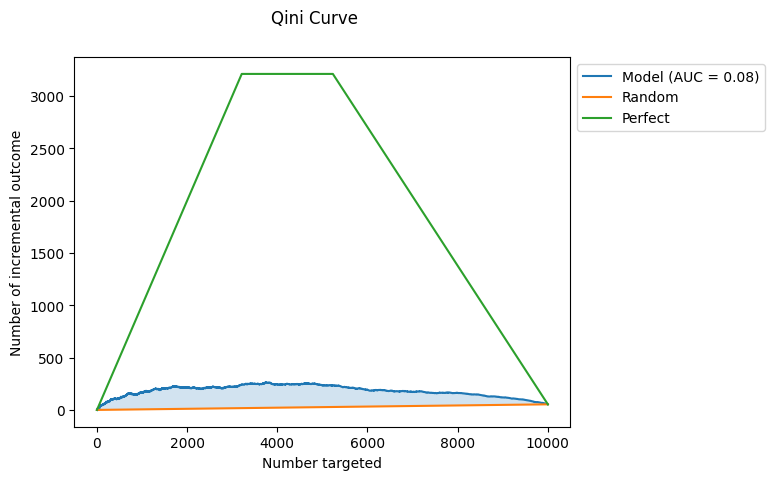

🎯 Normalized Qini AUC = 0.1759
Selecting top 20% uplifted customers...
Selected 2000 customers for outreach.
0.17594340740740744


In [ ]:
uplift_model, uplift_scores, disp, qini_auc, top_customers = stable_uplift_pipeline_sk(
    X_train,
    X_train,
    y_train,
    y_train,
    treatment_train,
    treatment_train,
    top_pct=0.2,  # optional: select top 20% uplifted customers
)
print(qini_auc)

Step 1: Compute propensity scores...
[LightGBM] [Info] Number of positive: 3984, number of negative: 6016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398400 -> initscore=-0.412136
[LightGBM] [Info] Start training from score -0.412136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

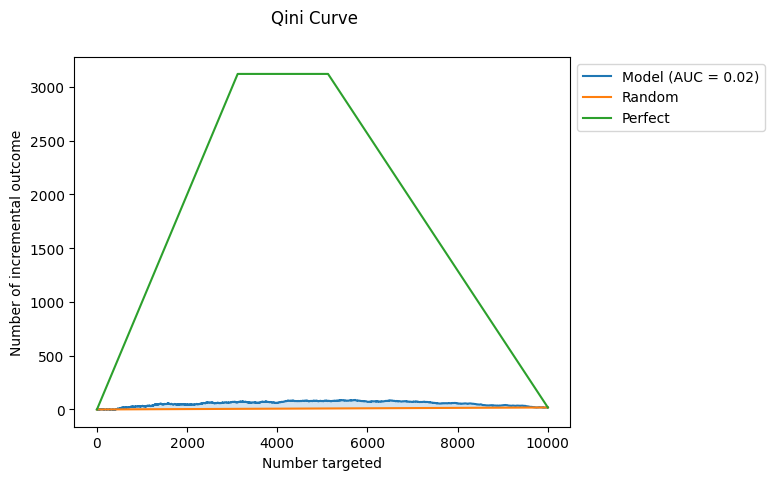

🎯 Normalized Qini AUC = -2.1151
Selecting top 20% uplifted customers...
Selected 2000 customers for outreach.
-2.1151342105263162


In [ ]:
uplift_model, uplift_scores, disp, qini_auc, top_customers = stable_uplift_pipeline_sk(
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    top_pct=0.2,  # optional: select top 20% uplifted customers
)
print(qini_auc)

In [ ]:
uplift_scores.shape

(10000,)

In [ ]:
print("Uplift mean (train):", np.mean(uplift_scores[: len(X_train)]))
print("Uplift mean (test):", np.mean(uplift_scores[-len(X_test) :]))
print("Uplift std (test):", np.std(uplift_scores[-len(X_test) :]))

Uplift mean (train): -0.11047682774249358
Uplift mean (test): -0.11047682774249358
Uplift std (test): 0.25169754765650865


In [ ]:
uplift_model

ClassTransformation(estimator=LGBMClassifier(colsample_bytree=0.8,
                                             learning_rate=0.05, max_depth=3,
                                             min_child_samples=50,
                                             n_estimators=150, random_state=42,
                                             reg_alpha=0.5, reg_lambda=0.5,
                                             subsample=0.8))

In [ ]:
import matplotlib.pyplot as plt

# LightGBM base model trained on transformed target
base_model = uplift_model.model

# feature importances
importances = base_model.feature_importances_

# plot
plt.figure(figsize=(8, 6))
plt.barh(X_train.columns, importances)
plt.xlabel("Feature importance")
plt.title("TLearner feature importances (ClassTransformation)")
plt.show()

AttributeError: 'ClassTransformation' object has no attribute 'model'

In [ ]:
X_train

,weeks_from_outreach_1_visits,weeks_from_outreach_2_visits,weeks_from_outreach_3_visits,not_wellco_domains,wellco_domains,total_web_visits,weekly_visits_diff,welco_domain_ratio,claims_count,num_repeated_claim_types,...,repeated_claims_count_segment,app_usage_count_segment,weeks_from_outreach_1_visits_trend_segment,weeks_from_outreach_2_visits_trend_segment,weeks_from_outreach_3_visits_trend_segment,total_web_visits_trend_segment,weekly_visits_diff_trend_segment,claims_count_trend_segment,repeated_claims_count_trend_segment,app_usage_count_trend_segment
0,1.0,2.0,0.0,1.0,2.0,3.0,-1.0,0.666667,9.0,2.0,...,3,0,0,0,0,0,2,3,3,0
1,1.0,6.0,2.0,7.0,2.0,9.0,-7.0,0.222222,9.0,3.0,...,3,1,0,0,2,0,0,3,3,1
2,23.0,26.0,3.0,46.0,6.0,52.0,-6.0,0.115385,4.0,1.0,...,0,1,3,3,2,3,1,0,0,1
3,5.0,9.0,1.0,14.0,1.0,15.0,-5.0,0.066667,5.0,1.0,...,1,1,0,1,1,1,1,0,1,1
4,3.0,7.0,1.0,11.0,0.0,11.0,-5.0,0.000000,7.0,2.0,...,1,1,0,1,1,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7.0,8.0,3.0,14.0,4.0,18.0,-4.0,0.222222,9.0,2.0,...,3,1,1,1,3,1,1,3,3,1
9996,3.0,3.0,2.0,6.0,2.0,8.0,-2.0,0.250000,5.0,1.0,...,1,2,0,0,2,0,2,1,1,2
9997,4.0,3.0,1.0,7.0,1.0,8.0,0.0,0.125000,14.0,5.0,...,3,3,0,0,2,0,3,3,3,3
9998,15.0,18.0,3.0,33.0,3.0,36.0,-6.0,0.083333,6.0,2.0,...,3,1,3,3,3,3,1,2,3,1


Training uplift model...
[LightGBM] [Info] Number of positive: 3211, number of negative: 773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.805974 -> initscore=1.424059
[LightGBM] [Info] Start training from score 1.424059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

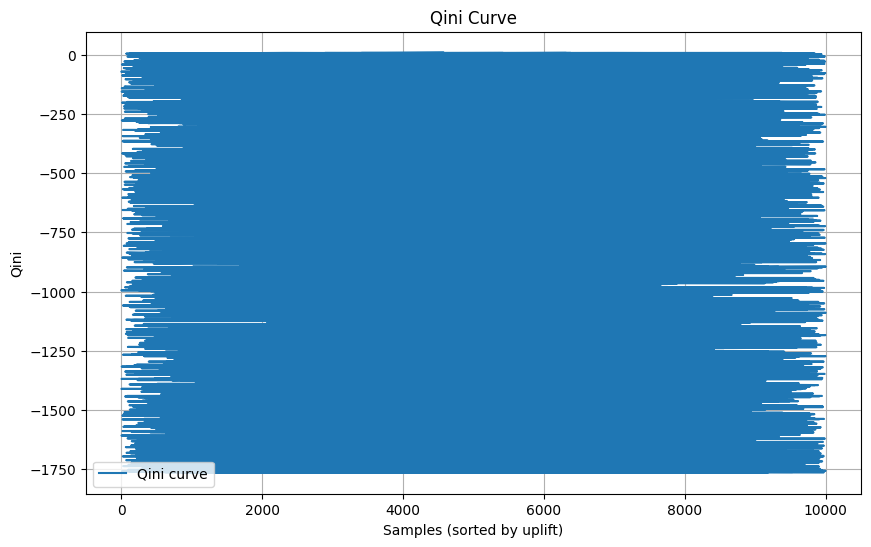

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt


# ================================================================
# 1. TRAIN A STABLE T-LEARNER (Two-Model Uplift)
# ================================================================
def train_t_learner(X_train, y_train, treatment_train):
    # Model for treated group
    model_treat = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
    )

    # Model for control group
    model_control = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
    )

    # Train each model on its group
    model_treat.fit(X_train[treatment_train == 1], y_train[treatment_train == 1])
    model_control.fit(X_train[treatment_train == 0], y_train[treatment_train == 0])

    return model_treat, model_control


# ================================================================
# 2. PREDICT UPLIFT = P(y=1 | Treat) - P(y=1 | Control)
# ================================================================
def predict_uplift(model_treat, model_control, X):
    p_treat = model_treat.predict_proba(X)[:, 1]
    p_control = model_control.predict_proba(X)[:, 1]
    uplift = p_treat - p_control
    return uplift


# ================================================================
# 3. COMPUTE QINI CURVE AND QINI AUC
# ================================================================
def qini_curve(y, treat, uplift):
    df = pd.DataFrame({"y": y, "t": treat, "uplift": uplift}).sort_values(
        "uplift", ascending=False
    )

    df["random"] = df["y"].mean() * np.arange(1, len(df) + 1)

    # Cumulative gains curves
    df["treat_gain"] = (df["y"] * df["t"]).cumsum()
    df["control_gain"] = (df["y"] * (1 - df["t"])).cumsum()

    # Qini curve = treat_gain - control_gain
    df["qini"] = df["treat_gain"] - df["control_gain"]

    # Qini AUC
    qini_auc = np.trapz(df["qini"])

    return df, qini_auc


def plot_qini(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df["qini"], label="Qini curve")
    plt.xlabel("Samples (sorted by uplift)")
    plt.ylabel("Qini")
    plt.title("Qini Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ================================================================
# 4. MAIN FUNCTION TO EXECUTE EVERYTHING
# ================================================================
def train_and_evaluate_uplift(X_train, X_test, y_train, y_test, T_train, T_test):
    print("Training uplift model...")
    model_treat, model_control = train_t_learner(X_train, y_train, T_train)

    print("Predicting uplift on test...")
    uplift_test = predict_uplift(model_treat, model_control, X_test)

    print("Computing Qini...")
    df_qini, qini_auc = qini_curve(y_test, T_test, uplift_test)

    print(f"🎯 Qini AUC = {qini_auc:.4f}")

    plot_qini(df_qini)

    return uplift_test, qini_auc


# ================================================================
# RUN
# ================================================================
uplift_test, qini_auc = train_and_evaluate_uplift(
    X_train, X_test, y_train, y_test, treatment_train, treatment_test
)

==== Numeric Distribution Drift ====


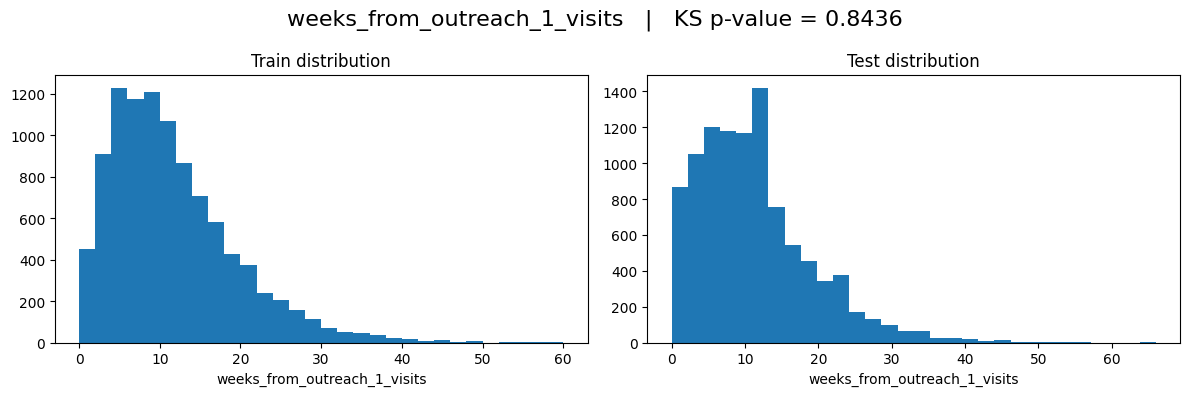

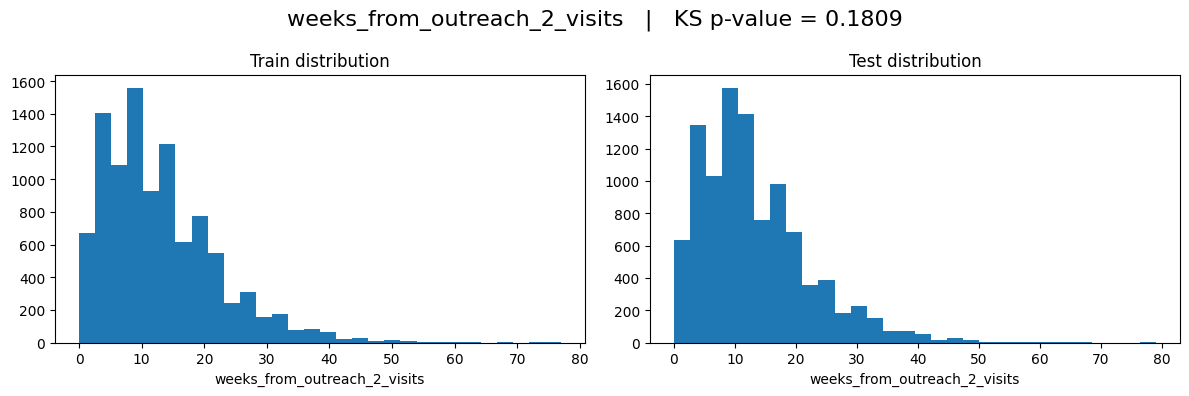

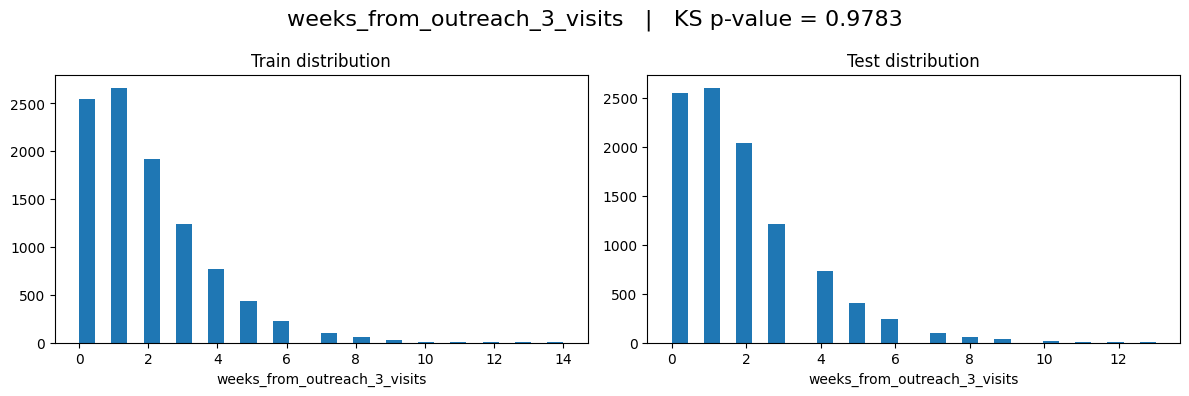

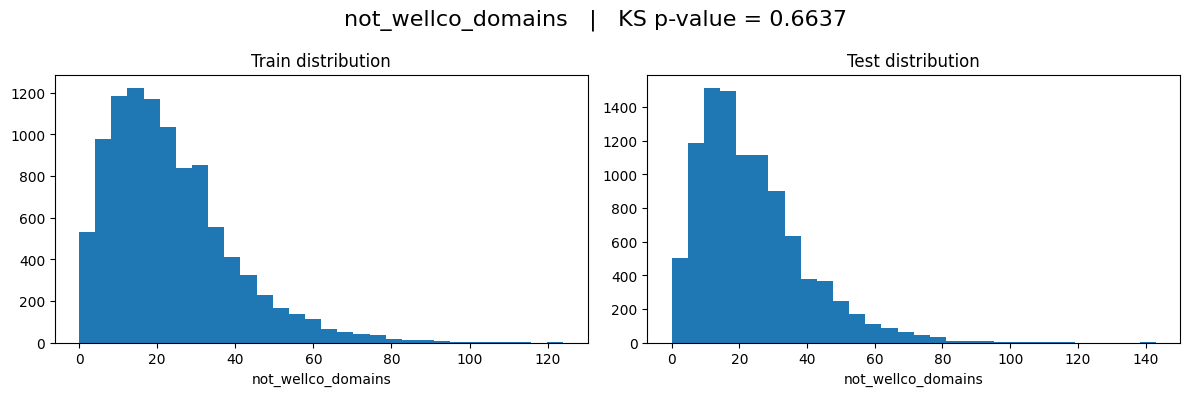

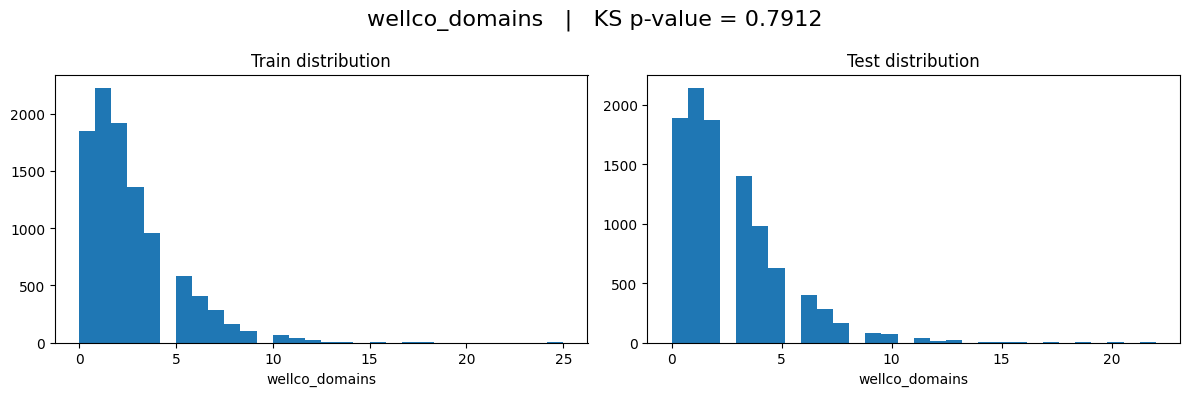

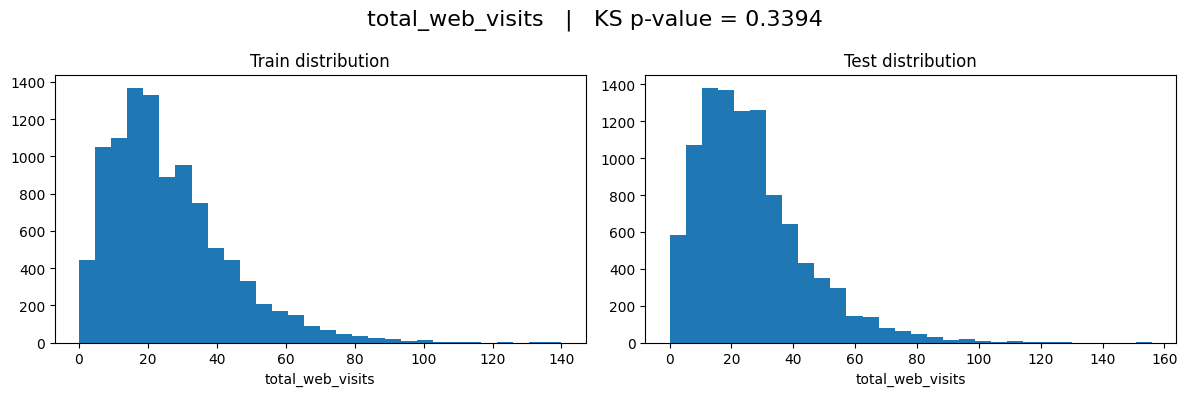

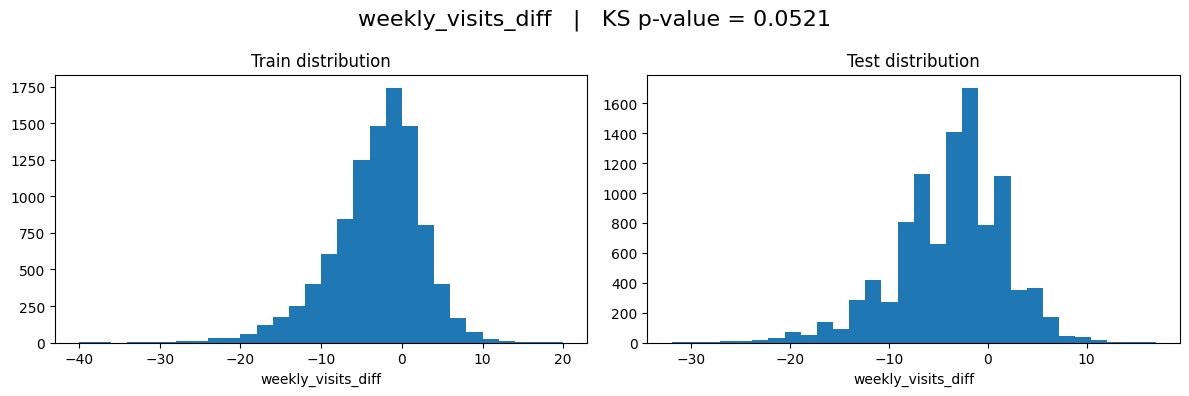

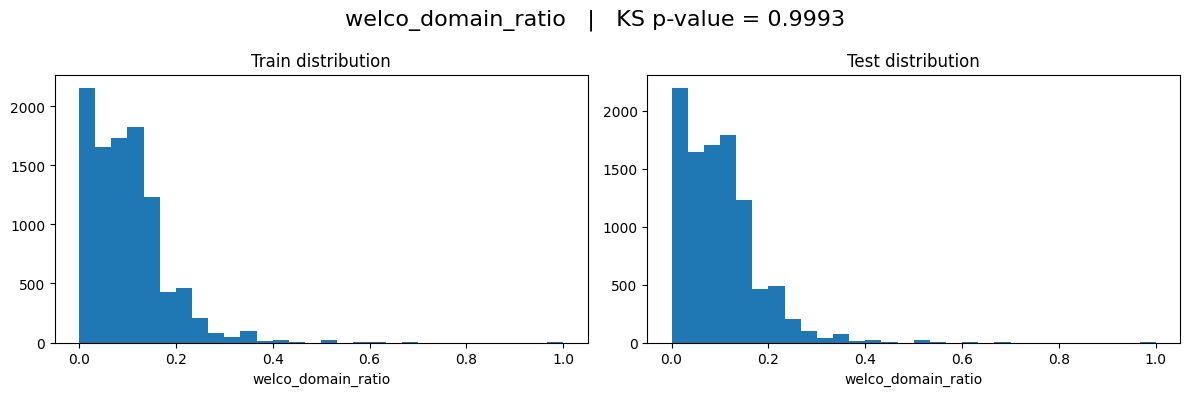

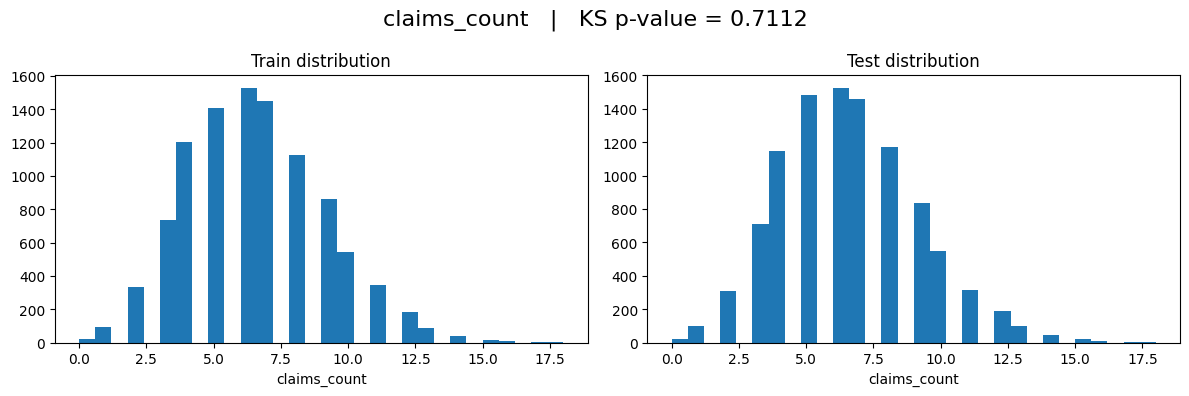

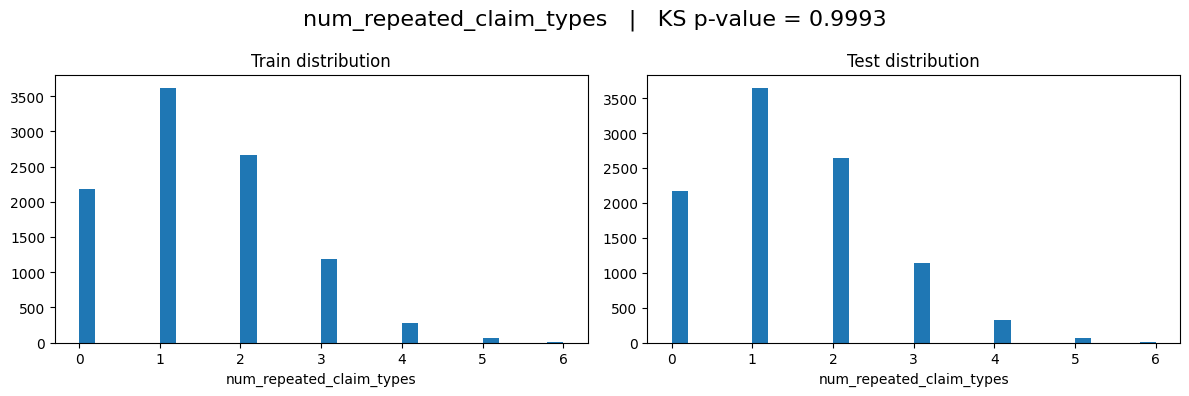

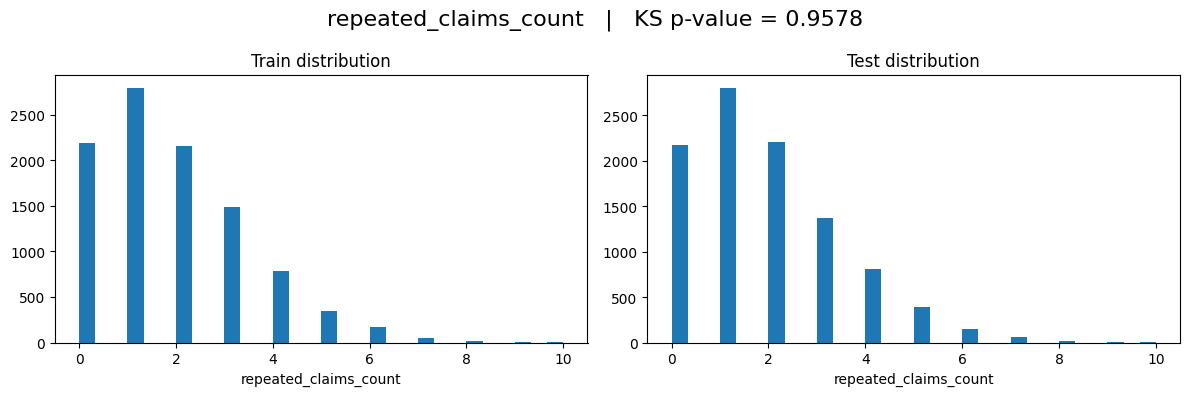

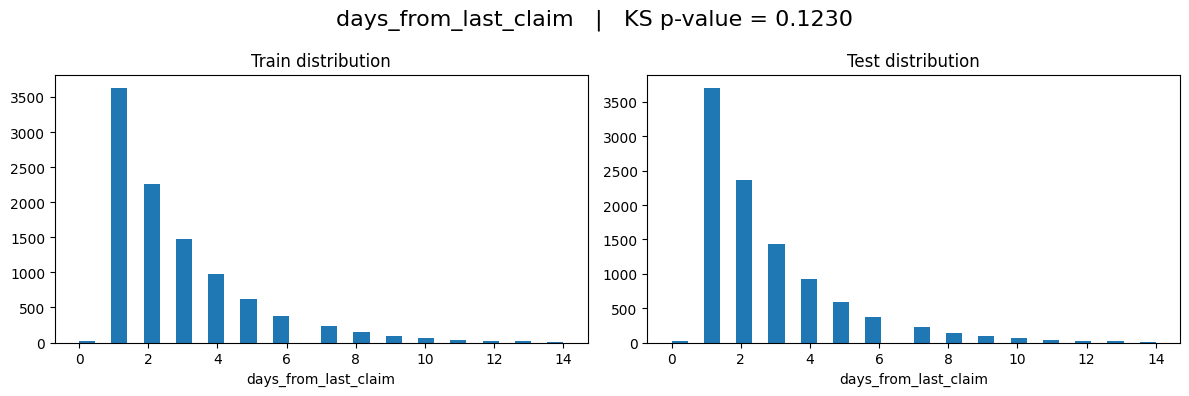

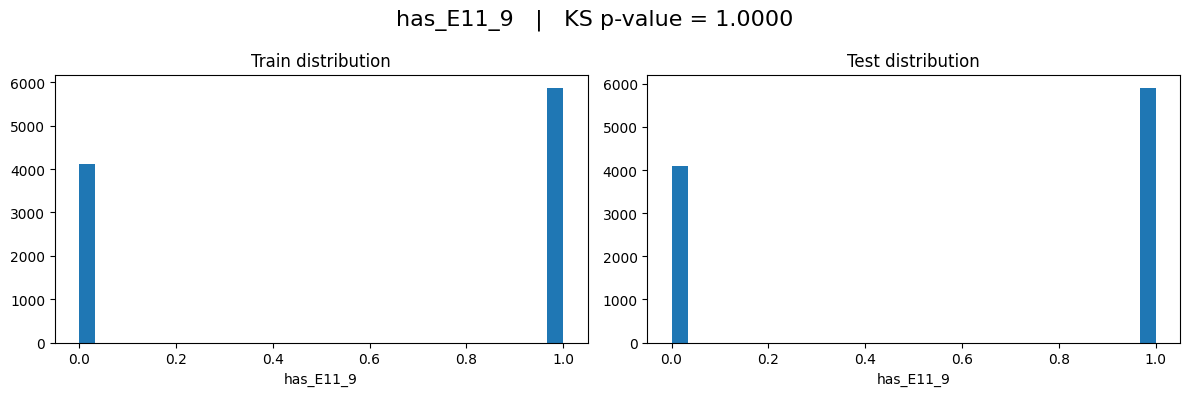

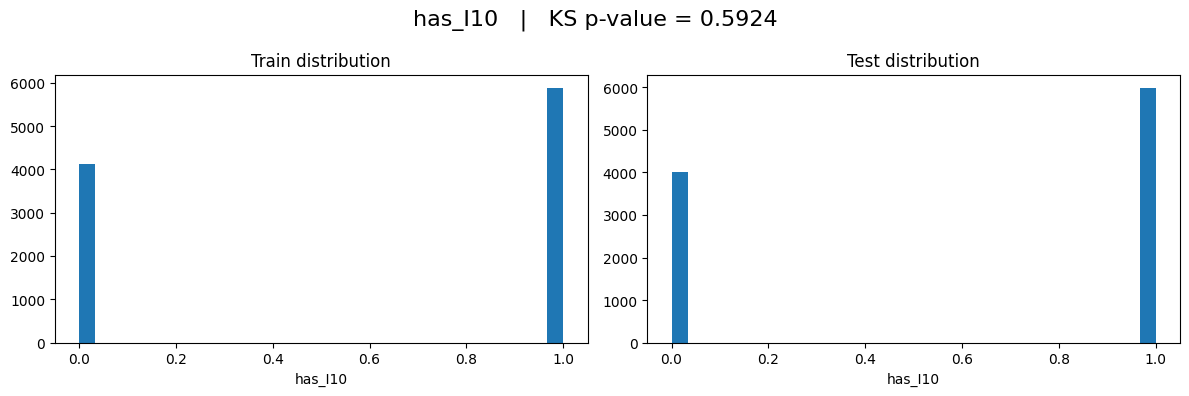

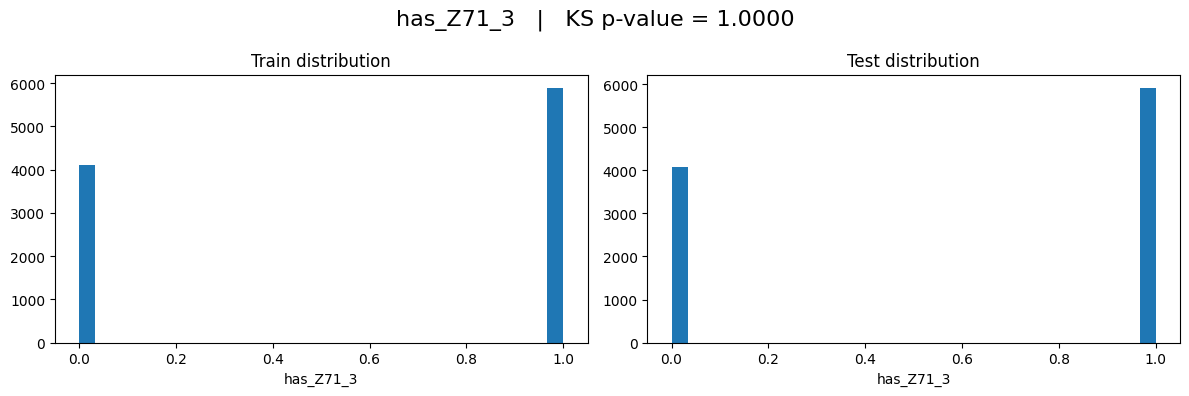

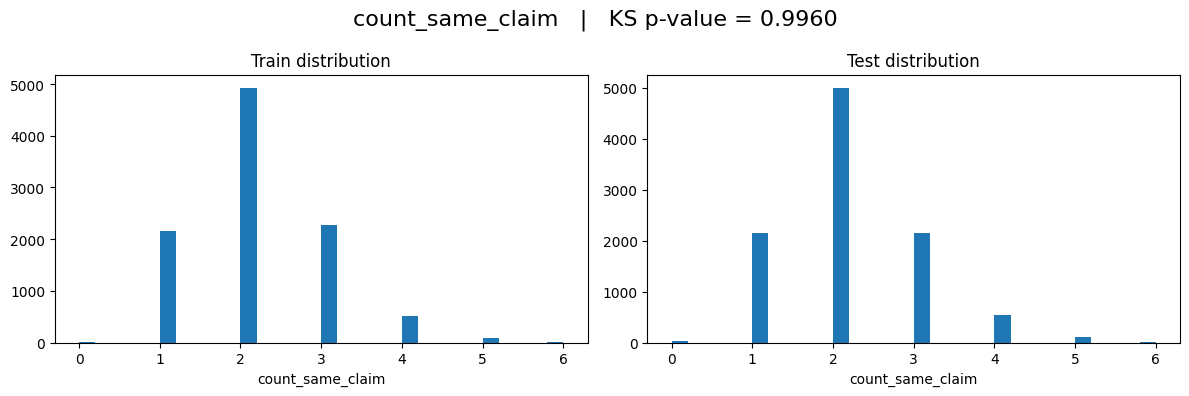

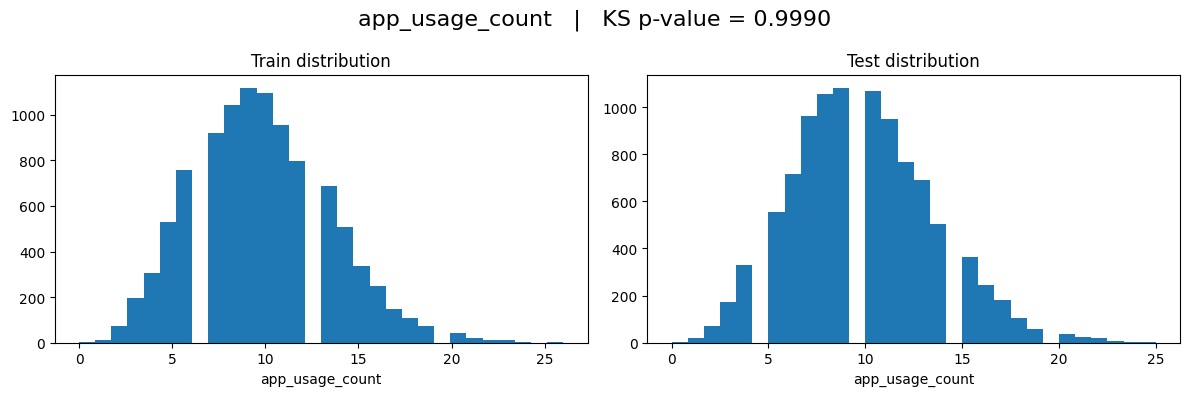

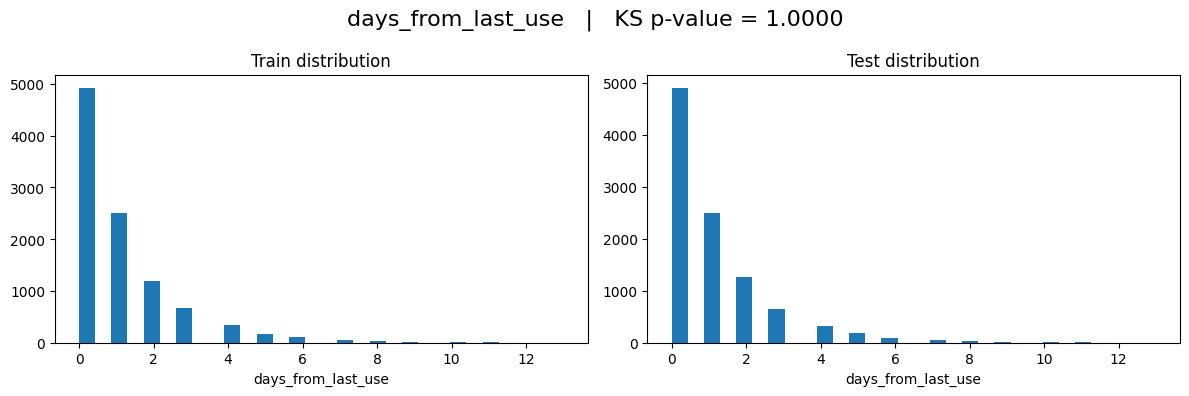

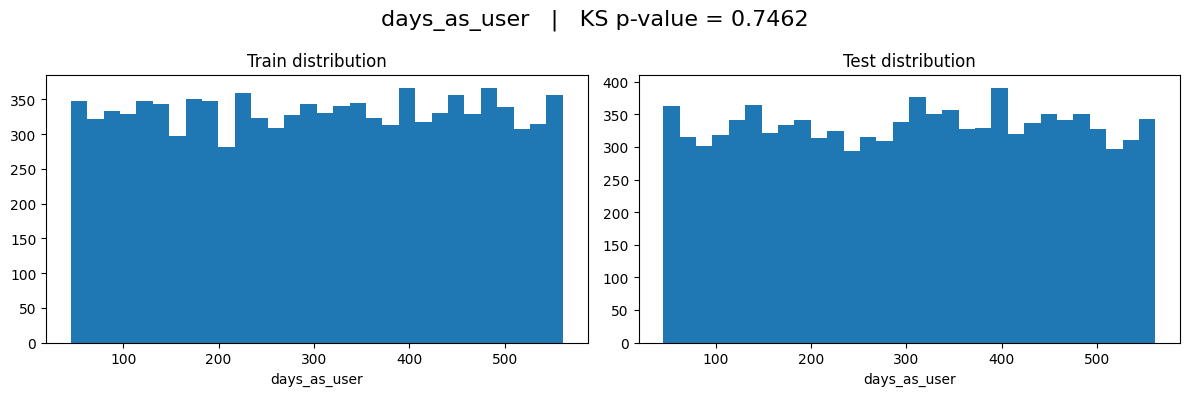

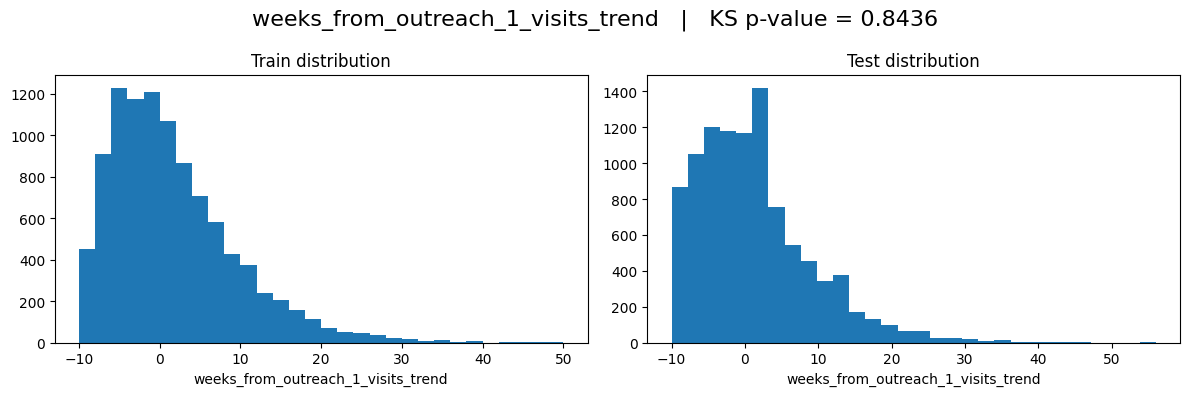

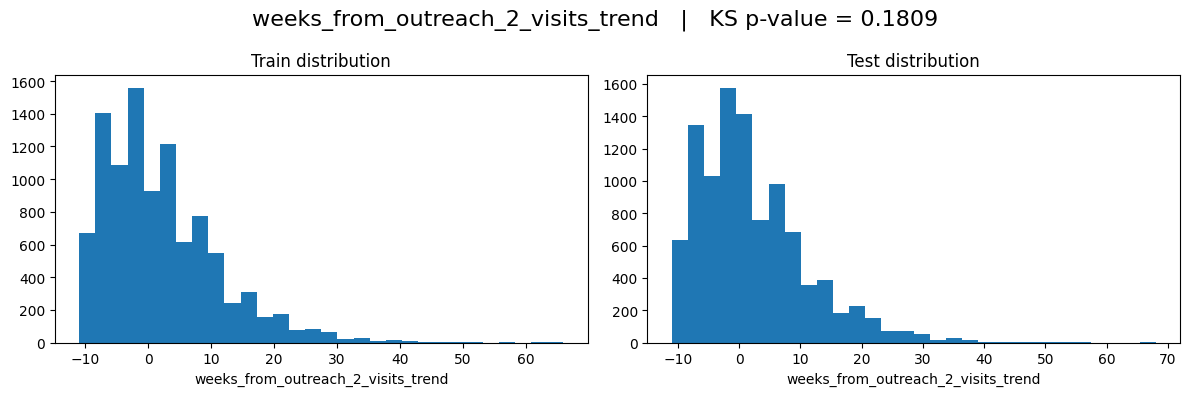

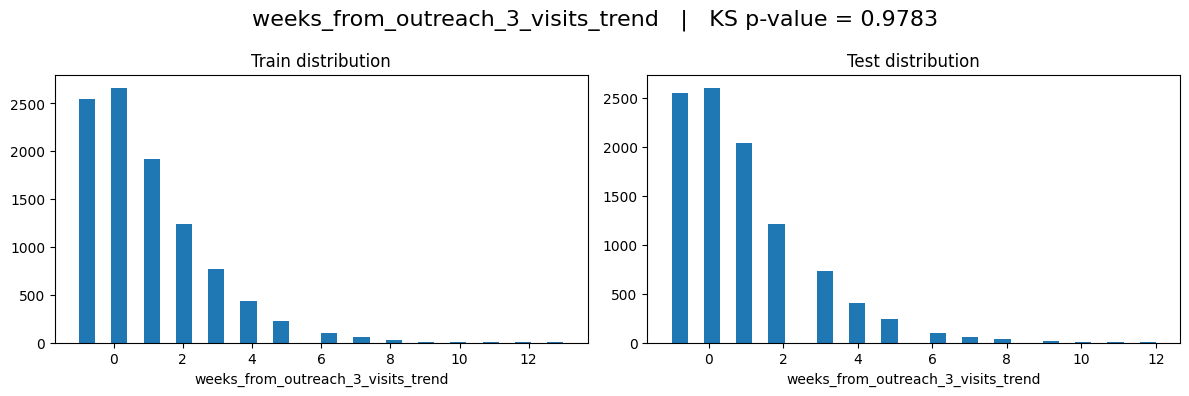

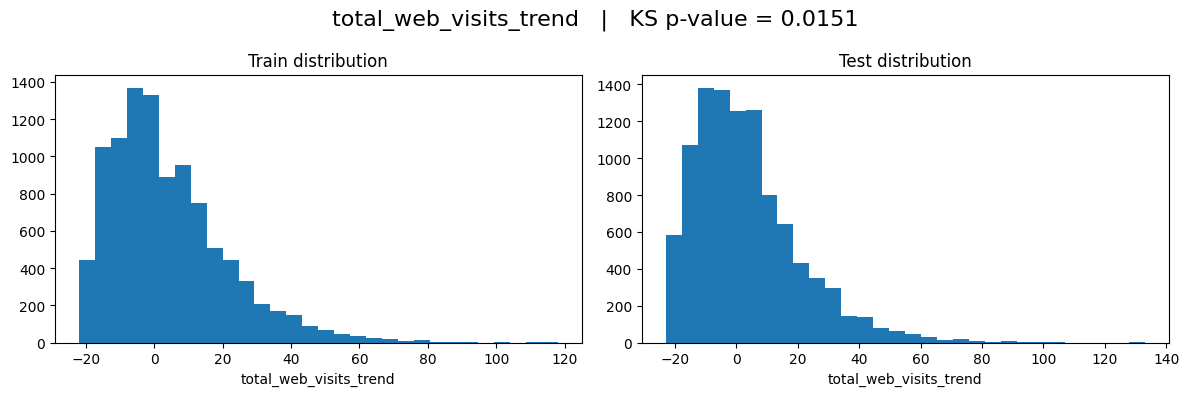

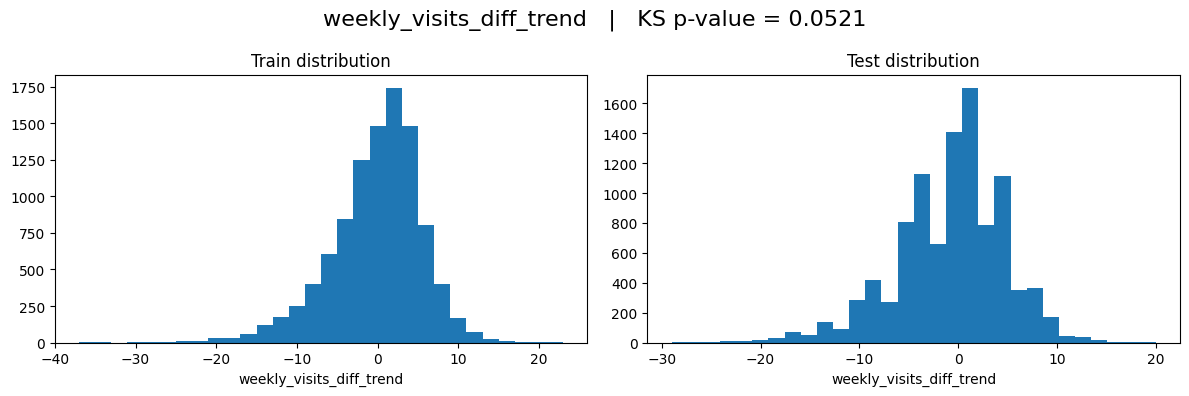

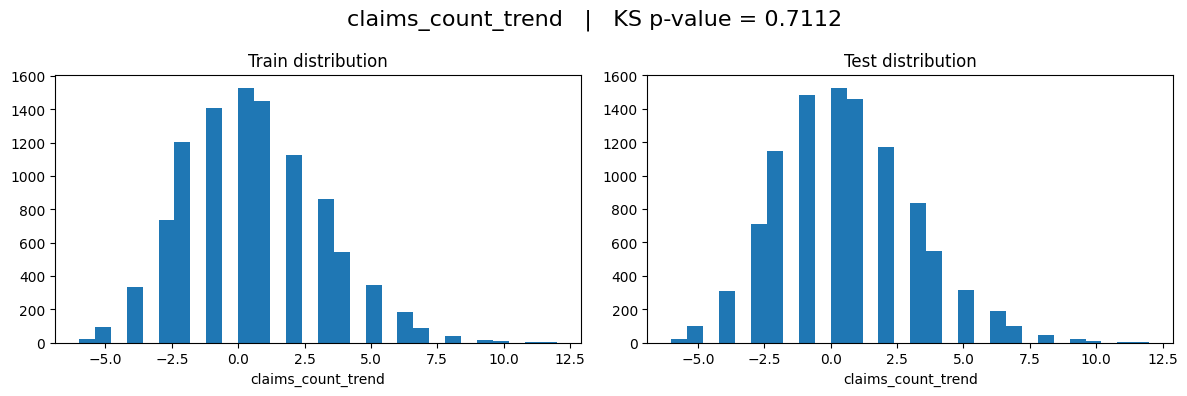

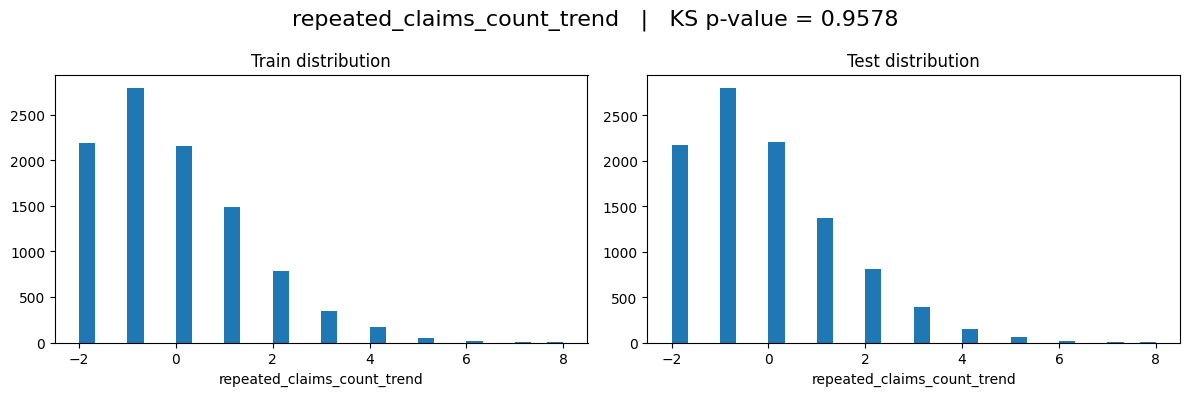

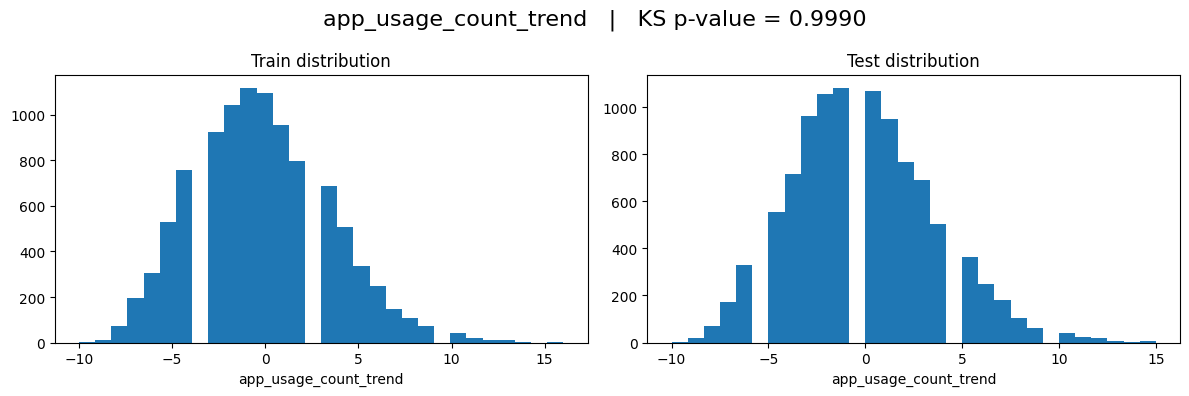

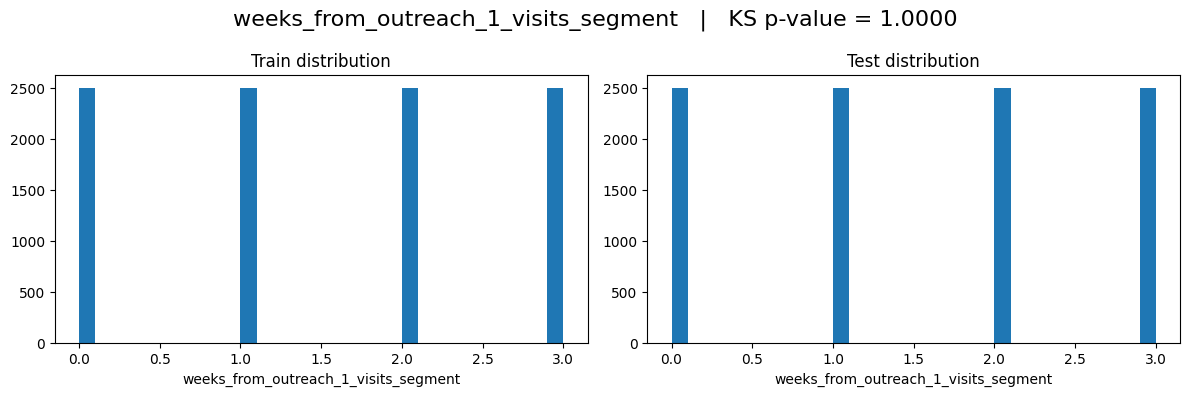

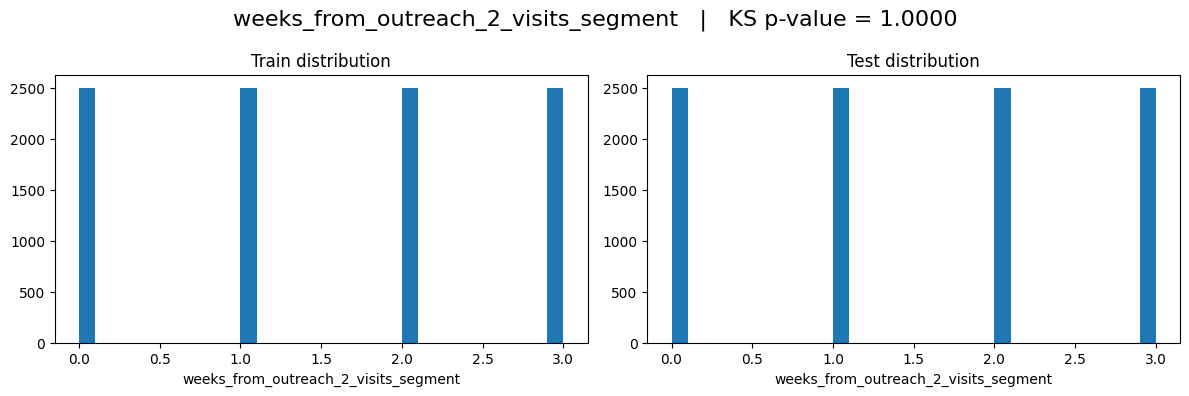

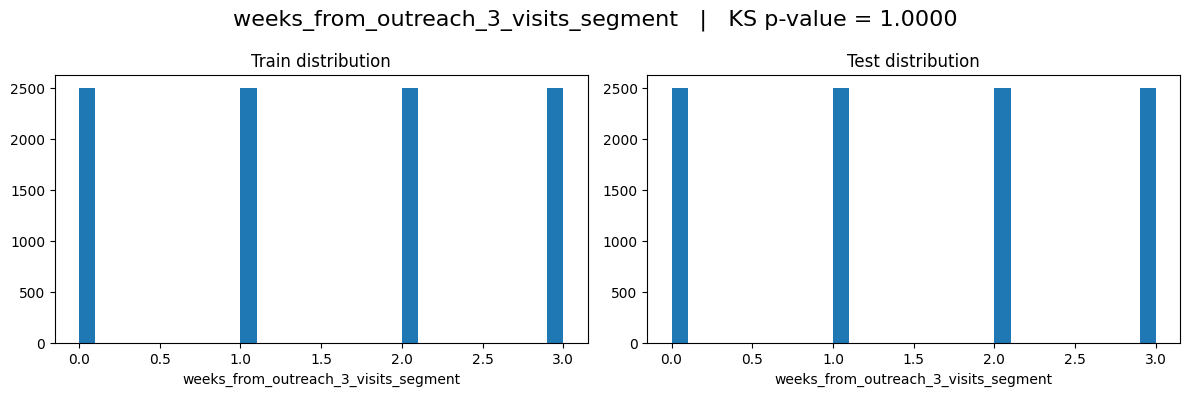

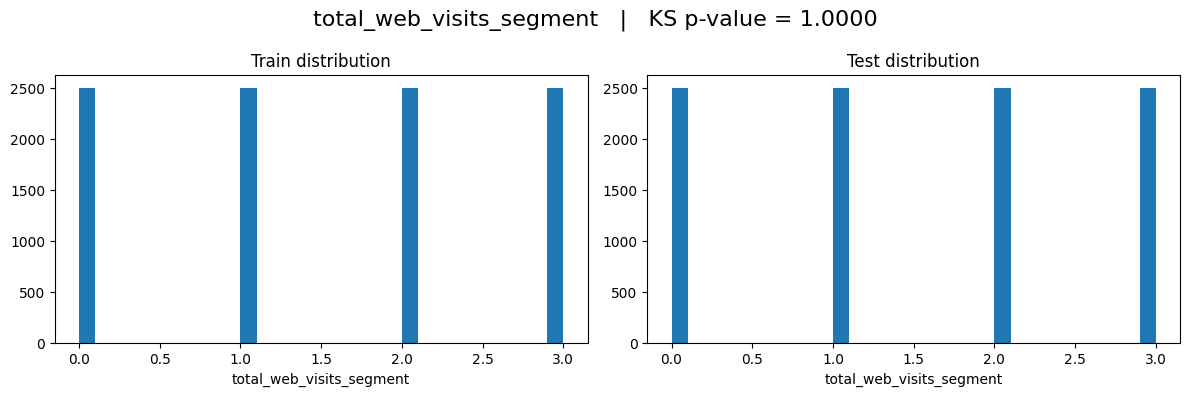

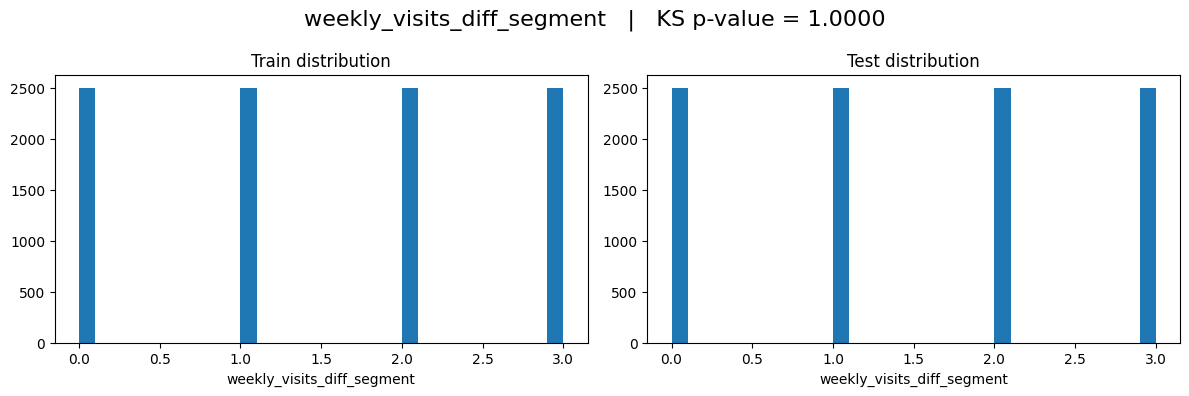

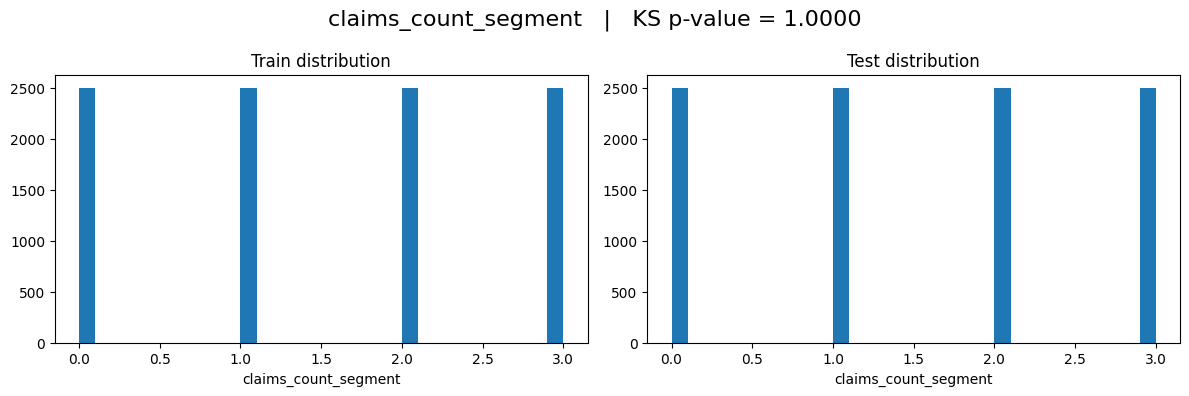

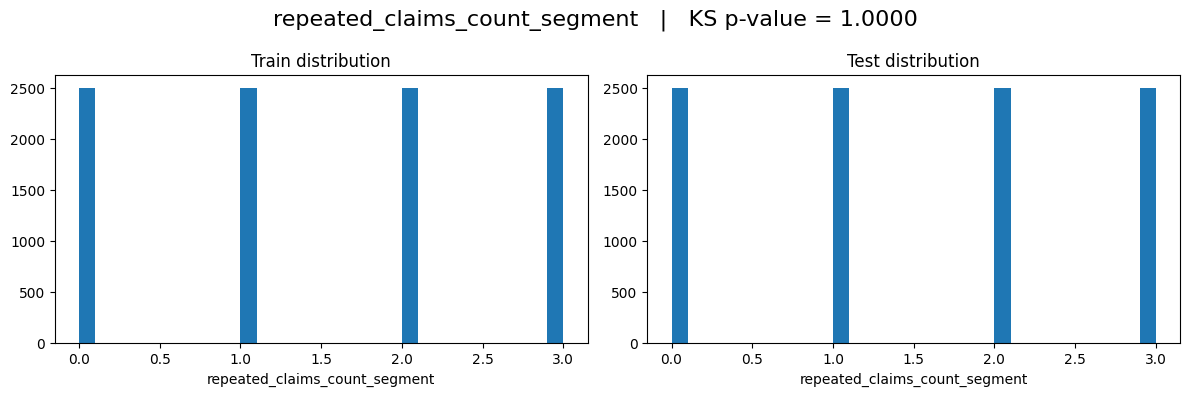

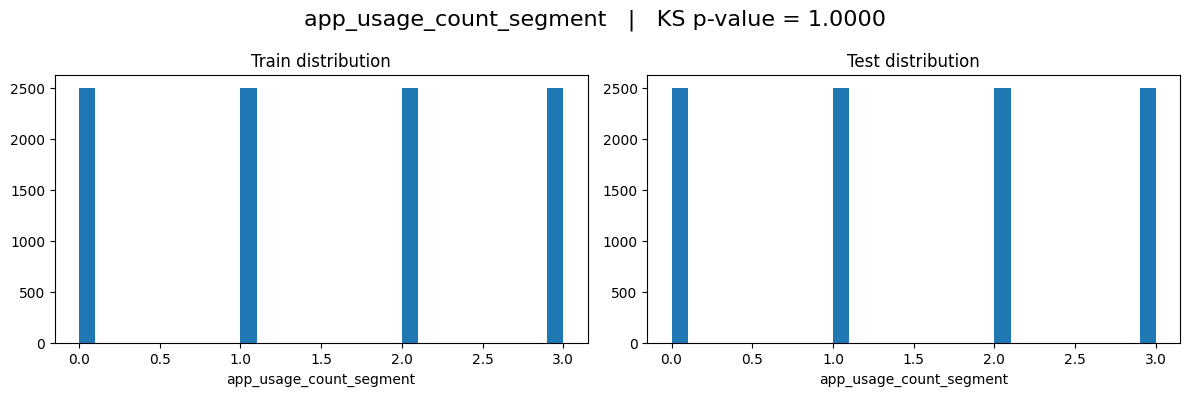

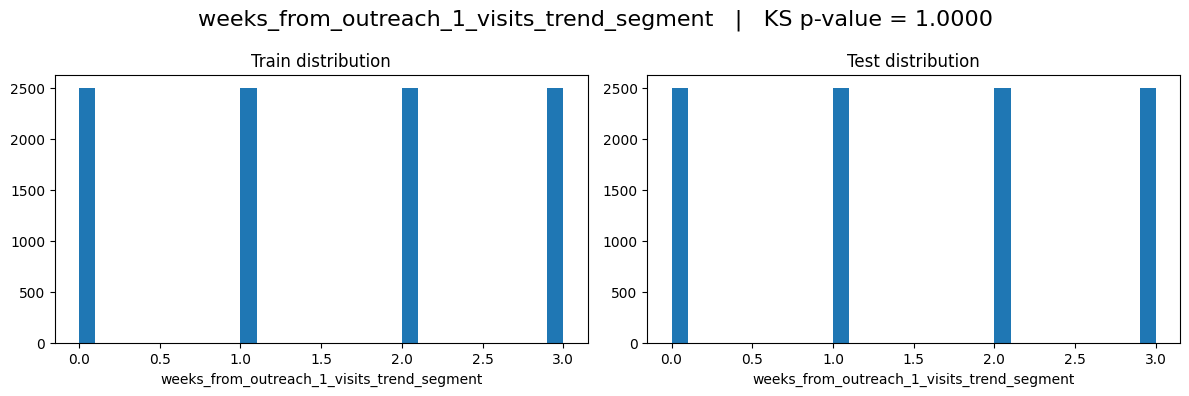

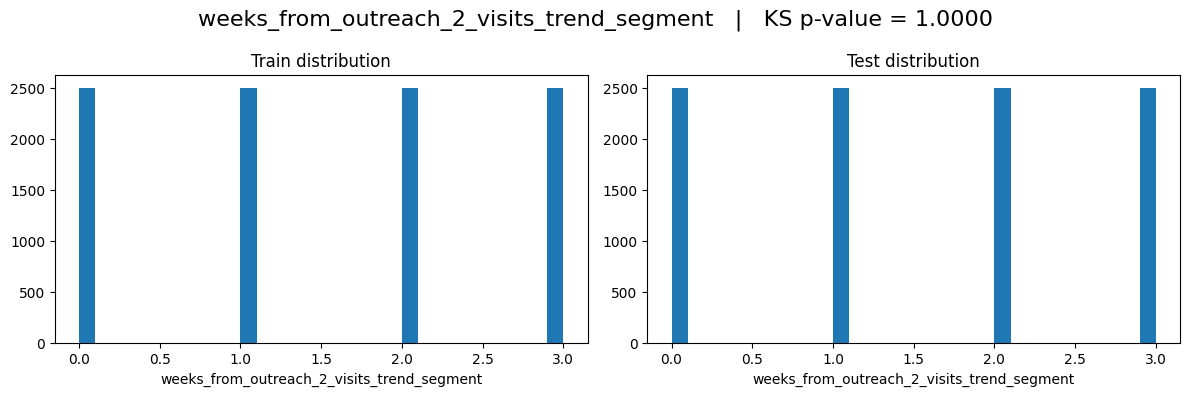

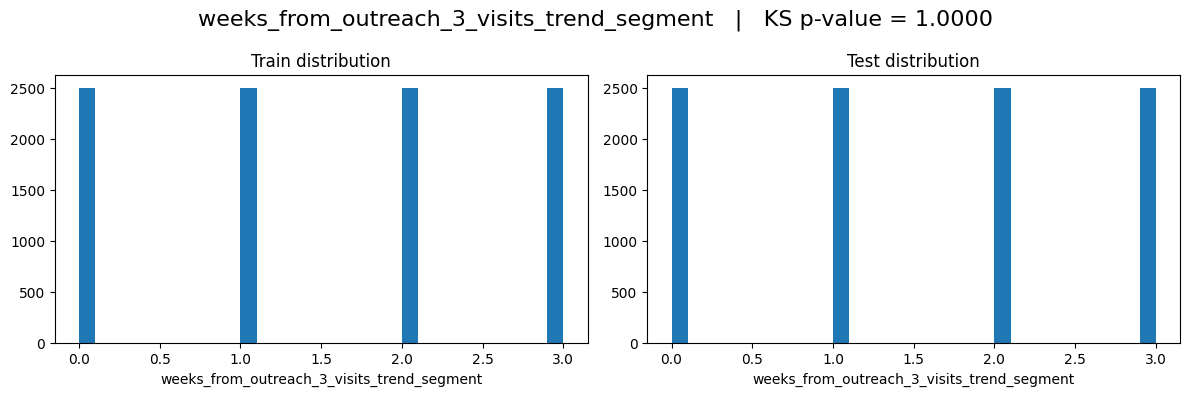

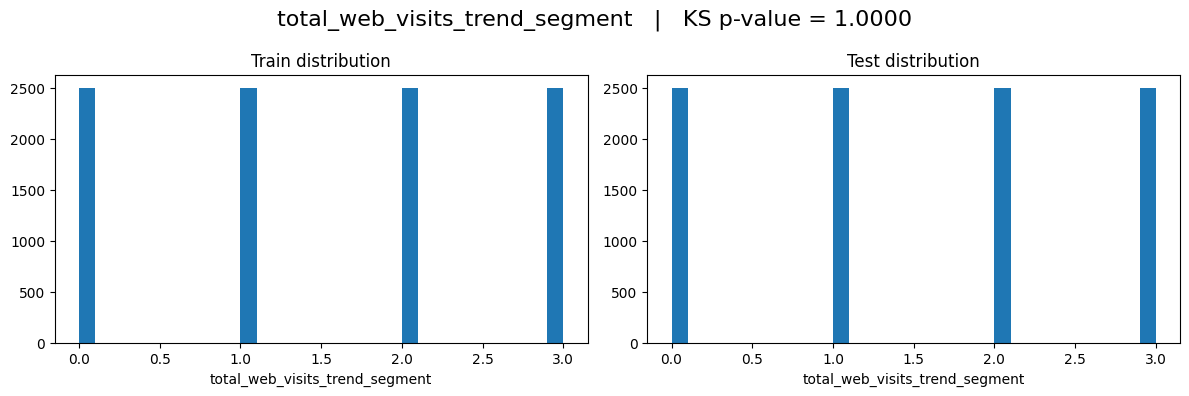

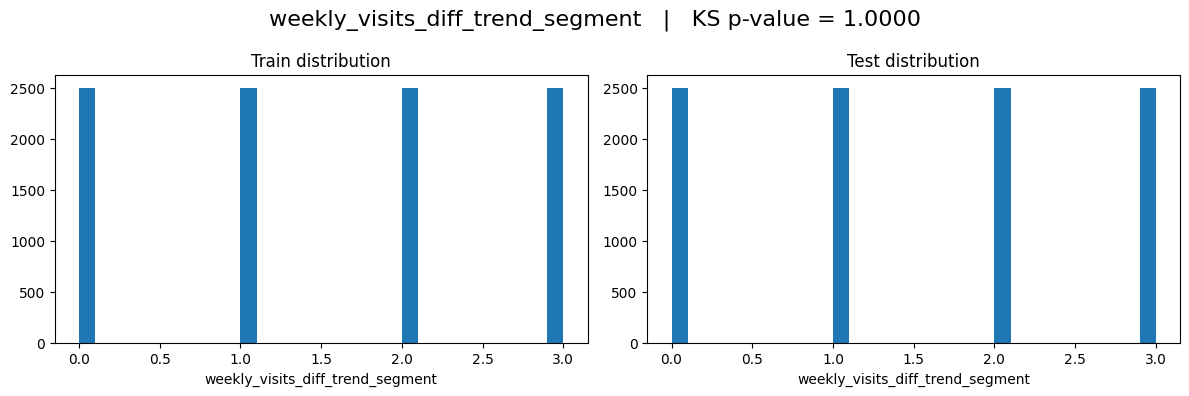

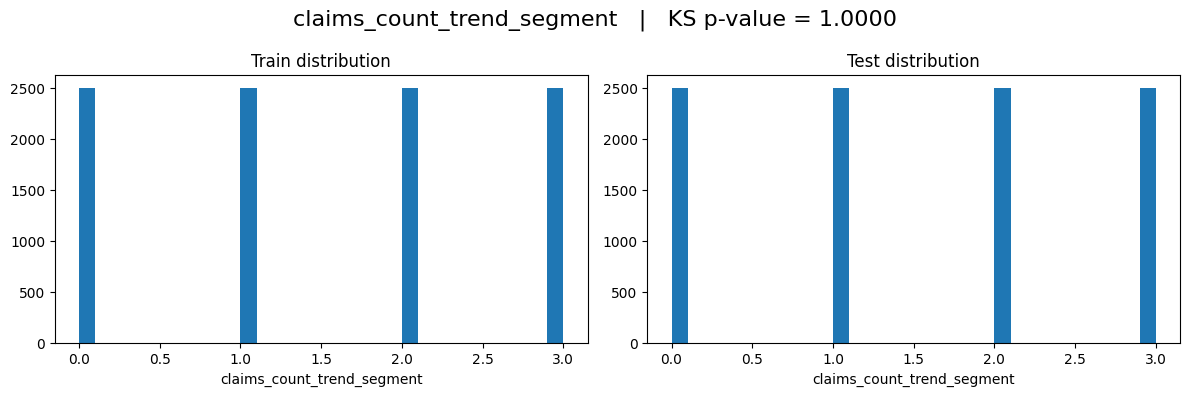

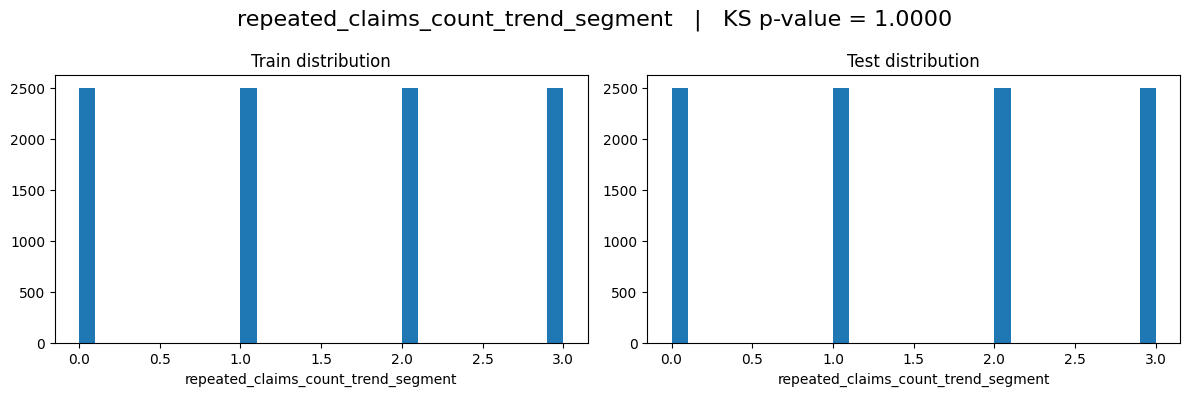

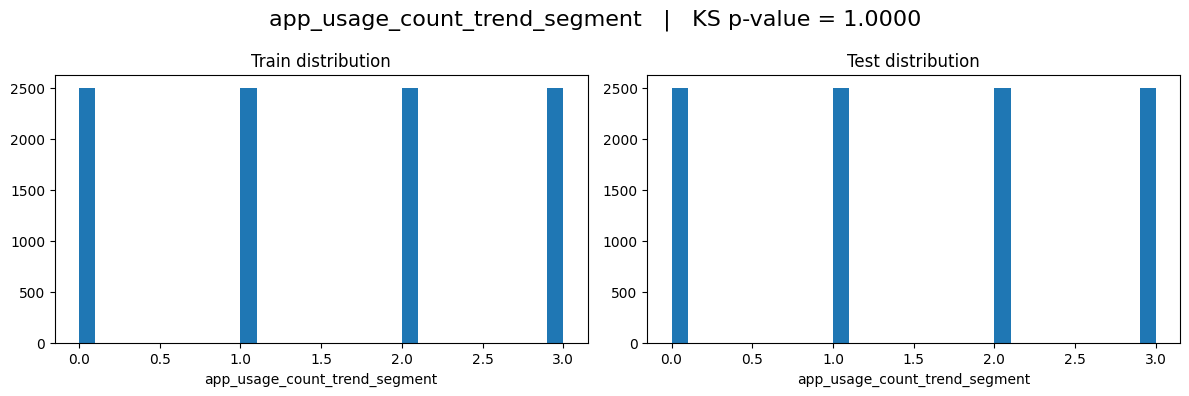

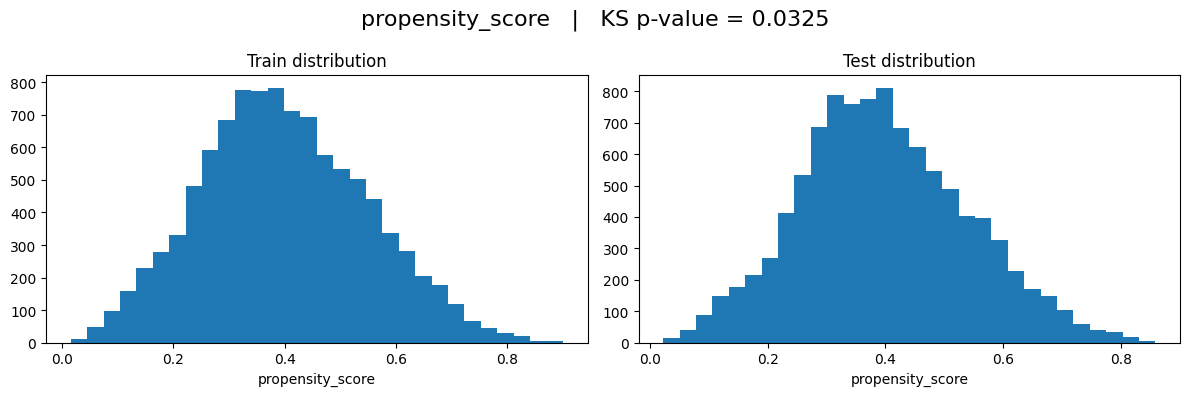

==== Categorical Distribution Drift ====
==== Missing Value Drift ====


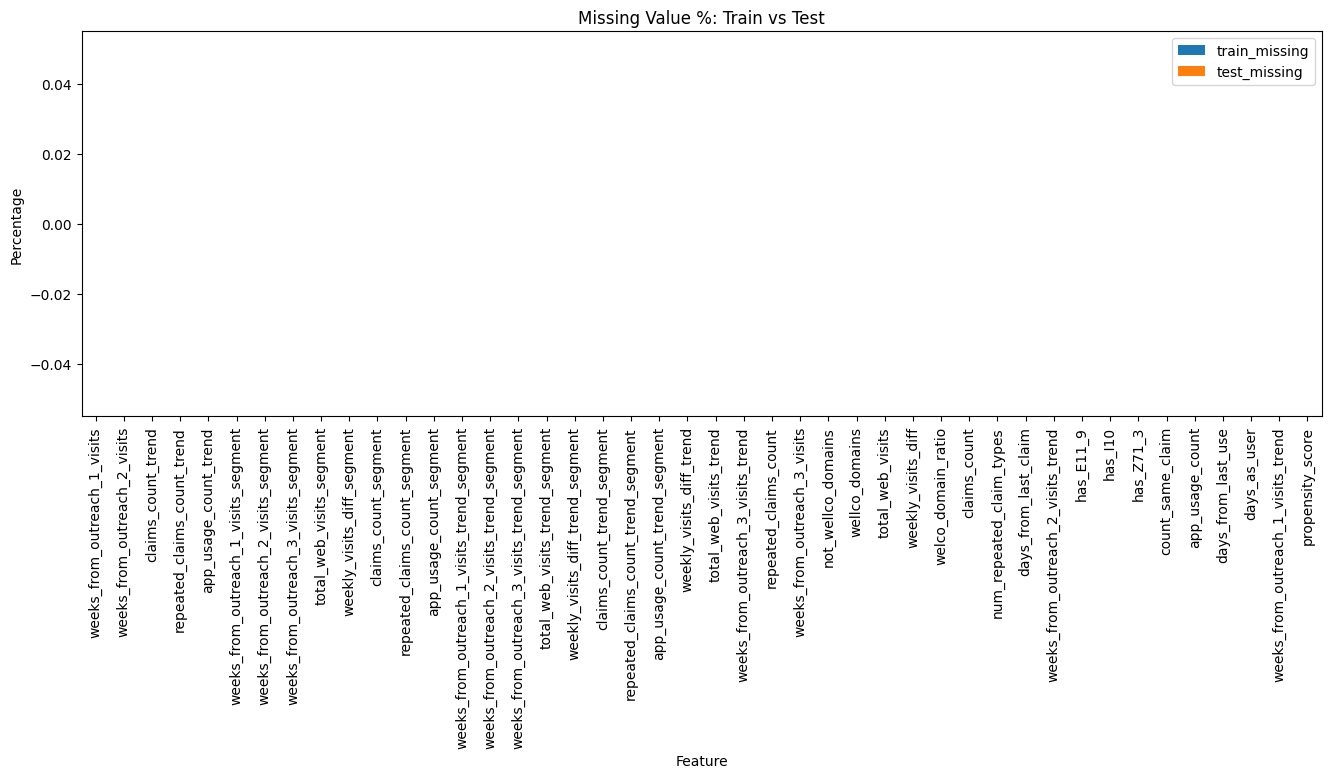

,train_missing,test_missing
weeks_from_outreach_1_visits,0.0,0.0
weeks_from_outreach_2_visits,0.0,0.0
claims_count_trend,0.0,0.0
repeated_claims_count_trend,0.0,0.0
app_usage_count_trend,0.0,0.0
weeks_from_outreach_1_visits_segment,0.0,0.0
weeks_from_outreach_2_visits_segment,0.0,0.0
weeks_from_outreach_3_visits_segment,0.0,0.0
total_web_visits_segment,0.0,0.0
weekly_visits_diff_segment,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


# =============================================
#   1. NUMERIC FEATURE DRIFT DASHBOARD
# =============================================
def plot_numeric_drift(X_train, X_test, bins=30):
    numeric_cols = X_train.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        train_vals = X_train[col].dropna()
        test_vals = X_test[col].dropna()

        # KS test
        p_value = ks_2samp(train_vals, test_vals).pvalue

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{col}   |   KS p-value = {p_value:.4f}", fontsize=16)

        # Histogram - Train
        plt.subplot(1, 2, 1)
        plt.hist(train_vals, bins=bins)
        plt.title("Train distribution")
        plt.xlabel(col)

        # Histogram - Test
        plt.subplot(1, 2, 2)
        plt.hist(test_vals, bins=bins)
        plt.title("Test distribution")
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()


# =============================================
#   2. CATEGORICAL FEATURE DRIFT DASHBOARD
# =============================================
def plot_categorical_drift(X_train, X_test, top_n=15):
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

    for col in cat_cols:
        train_counts = X_train[col].value_counts(normalize=True).head(top_n)
        test_counts = X_test[col].value_counts(normalize=True).head(top_n)

        plt.figure(figsize=(14, 4))
        plt.suptitle(f"{col} (Top {top_n} categories)", fontsize=16)

        # Train bar chart
        plt.subplot(1, 2, 1)
        train_counts.plot(kind="bar")
        plt.title("Train distribution")
        plt.xlabel(col)
        plt.ylabel("Frequency")

        # Test bar chart
        plt.subplot(1, 2, 2)
        test_counts.plot(kind="bar", color="orange")
        plt.title("Test distribution")
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()


# =============================================
#   3. MISSING VALUE DRIFT
# =============================================
def plot_missing_drift(X_train, X_test):
    missing_train = X_train.isna().mean()
    missing_test = X_test.isna().mean()

    df = pd.DataFrame(
        {"train_missing": missing_train, "test_missing": missing_test}
    ).sort_values("train_missing", ascending=False)

    df.plot(kind="bar", figsize=(16, 5))
    plt.title("Missing Value %: Train vs Test")
    plt.ylabel("Percentage")
    plt.xlabel("Feature")
    plt.show()

    return df


# =============================================
#   4. RUN ALL
# =============================================
def run_drift_dashboard(X_train, X_test):
    print("==== Numeric Distribution Drift ====")
    plot_numeric_drift(X_train, X_test)

    print("==== Categorical Distribution Drift ====")
    plot_categorical_drift(X_train, X_test)

    print("==== Missing Value Drift ====")
    missing_df = plot_missing_drift(X_train, X_test)
    display(missing_df)


# Example:
# run_drift_dashboard(X_train, X_test)

# Example usage:
run_drift_dashboard(X_train, X_test)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp


def get_drift_columns(X_train, X_test, p_threshold=0.05):
    drift_cols = []

    # ---- Numeric drift (KS test) ----
    numeric_cols = X_train.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        p_value = ks_2samp(X_train[col].dropna(), X_test[col].dropna()).pvalue
        if p_value < p_threshold:
            drift_cols.append((col, "numeric", p_value))

    # ---- Categorical drift ----
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        train_vals = X_train[col].value_counts(normalize=True)
        test_vals = X_test[col].value_counts(normalize=True)

        # Compare frequency difference
        combined_index = train_vals.index.union(test_vals.index)
        train_freq = train_vals.reindex(combined_index, fill_value=0)
        test_freq = test_vals.reindex(combined_index, fill_value=0)

        # L1 distance (sum absolute difference)
        drift_score = np.sum(np.abs(train_freq - test_freq))

        if drift_score > 0.3:  # threshold for category drift
            drift_cols.append((col, "categorical", drift_score))

    return drift_cols


# Example:
drift_columns = get_drift_columns(X_train, X_test)
print("Columns with drift:")
for col, col_type, score in drift_columns:
    print(f"{col} ({col_type}) -> drift score: {score}")

Columns with drift:
total_web_visits_trend (numeric) -> drift score: 0.01512953257863315
propensity_score (numeric) -> drift score: 0.03245716446609041



Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


In [ ]:
# 1. Identify categorical columns before dropping
categorical_columns = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()
categorical_columns = [
    col for col in categorical_columns if col not in ["churn", "outreach", "member_id"]
]

# 2. Drop target, treatment, and ID columns
X_train = X_train.drop(columns=["churn", "outreach", "member_id", "index"])
X_test = X_test.drop(columns=["churn", "outreach", "member_id","index"])

# 3. One-hot encode categorical columns
if categorical_columns:
    X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=False)
    X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)

    # Align columns
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

# No scaling needed for tree-based models like LightGBM
X_train.head()

,weeks_from_outreach_1_visits,weeks_from_outreach_2_visits,weeks_from_outreach_3_visits,not_wellco_domains,wellco_domains,total_web_visits,weekly_visits_diff,welco_domain_ratio,claims_count,num_repeated_claim_types,...,repeated_claims_count_segment,app_usage_count_segment,weeks_from_outreach_1_visits_trend_segment,weeks_from_outreach_2_visits_trend_segment,weeks_from_outreach_3_visits_trend_segment,total_web_visits_trend_segment,weekly_visits_diff_trend_segment,claims_count_trend_segment,repeated_claims_count_trend_segment,app_usage_count_trend_segment
0,1.0,2.0,0.0,1.0,2.0,3.0,-1.0,0.666667,9.0,2.0,...,3,0,0,0,0,0,2,3,3,0
1,1.0,6.0,2.0,7.0,2.0,9.0,-7.0,0.222222,9.0,3.0,...,3,1,0,0,2,0,0,3,3,1
2,23.0,26.0,3.0,46.0,6.0,52.0,-6.0,0.115385,4.0,1.0,...,0,1,3,3,2,3,1,0,0,1
3,5.0,9.0,1.0,14.0,1.0,15.0,-5.0,0.066667,5.0,1.0,...,1,1,0,1,1,1,1,0,1,1
4,3.0,7.0,1.0,11.0,0.0,11.0,-5.0,0.000000,7.0,2.0,...,1,1,0,1,1,0,1,2,1,1


In [ ]:
X_test.head()

,weeks_from_outreach_1_visits,weeks_from_outreach_2_visits,weeks_from_outreach_3_visits,not_wellco_domains,wellco_domains,total_web_visits,weekly_visits_diff,welco_domain_ratio,claims_count,num_repeated_claim_types,...,repeated_claims_count_segment,app_usage_count_segment,weeks_from_outreach_1_visits_trend_segment,weeks_from_outreach_2_visits_trend_segment,weeks_from_outreach_3_visits_trend_segment,total_web_visits_trend_segment,weekly_visits_diff_trend_segment,claims_count_trend_segment,repeated_claims_count_trend_segment,app_usage_count_trend_segment
0,3.0,3.0,0.0,6.0,0.0,6.0,0.0,0.000000,5.0,1.0,...,1,1,0,0,0,0,2,0,1,1
1,10.0,18.0,3.0,25.0,6.0,31.0,-11.0,0.193548,4.0,0.0,...,0,0,1,2,2,2,0,0,0,0
2,12.0,18.0,2.0,23.0,9.0,32.0,-8.0,0.281250,7.0,2.0,...,2,2,2,2,2,2,0,2,2,2
3,0.0,1.0,0.0,1.0,0.0,1.0,-1.0,0.000000,5.0,1.0,...,0,0,0,0,0,0,2,0,0,0
4,4.0,14.0,1.0,19.0,0.0,19.0,-11.0,0.000000,2.0,0.0,...,0,0,0,2,1,1,0,0,0,0


In [ ]:
# Diagnostics: ATE, treatment counts, missing values, constant columns
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('\nTreatment counts:')
print('treatment in train:', treatment_train.sum(), '/', len(treatment_train), f'({100*treatment_train.mean():.2f}%)')
print('treatment in test :', treatment_test.sum(), '/', len(treatment_test), f'({100*treatment_test.mean():.2f}%)')

treated_mean_churn = y_train[treatment_train==1].mean()
control_mean_churn = y_train[treatment_train==0].mean()
ate = treated_mean_churn - control_mean_churn
print('\nATE (treated - control):', ate)

print('\nChurn counts (train):')
print(pd.crosstab(treatment_train, y_train))

print('\nTop missing values:')
print(X_train.isna().sum().sort_values(ascending=False).head(20))

numeric = X_train.select_dtypes(include=['number'])
const_cols = numeric.columns[numeric.nunique() <= 1].tolist()
print('\nConstant numeric columns:', const_cols)

print('\nTreatment rate by churn:')
print(treatment_train.groupby(y_train).mean())

print('\nDtypes:')
print(X_train.dtypes.value_counts())

Train shape: (10000, 43)
Test shape: (10000, 43)

Treatment counts:
treatment in train: 3984 / 10000 (39.84%)
treatment in test : 3889 / 10000 (38.89%)

ATE (treated - control): -0.013420704092967611

Churn counts (train):
churn        0     1
outreach            
0         4768  1248
1         3211   773

Top missing values:
weeks_from_outreach_1_visits                  0
claims_count_segment                          0
claims_count_trend                            0
repeated_claims_count_trend                   0
app_usage_count_trend                         0
weeks_from_outreach_1_visits_segment          0
weeks_from_outreach_2_visits_segment          0
weeks_from_outreach_3_visits_segment          0
total_web_visits_segment                      0
weekly_visits_diff_segment                    0
repeated_claims_count_segment                 0
total_web_visits_trend                        0
app_usage_count_segment                       0
weeks_from_outreach_1_visits_trend_segment    0



TREATMENT EFFECT BY CLAIMS_COUNT LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low claims_count -0.026463     3798       1514       2284       0.196830       0.223292
Medium claims_count -0.012966     2979       1197       1782       0.192982       0.205948
  High claims_count  0.001417     3223       1273       1950       0.191673       0.190256

Overall ATE (reference): -0.0134


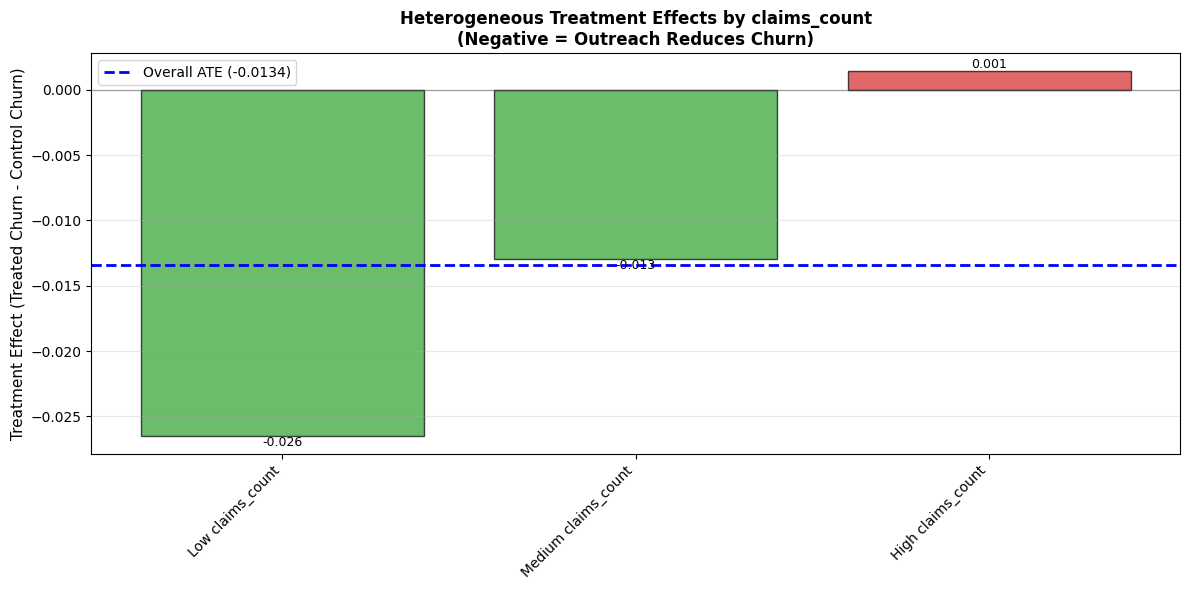


💡 CLINICAL INSIGHT for claims_count:
   ✅ BEST: Low claims_count shows strongest benefit (ATE=-0.0265)
      → Prioritize outreach for this segment (3798 members)
   ⚠️  WORST: High claims_count shows harm/no benefit (ATE=0.0014)
      → Avoid outreach for this segment (3223 members)

TREATMENT EFFECT BY HAS_E11_9 LEVEL
      Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_E11_9 -0.024911     4120       1652       2468       0.197942       0.222853
1.0 has_E11_9 -0.005478     5880       2332       3548       0.191252       0.196731

Overall ATE (reference): -0.0134


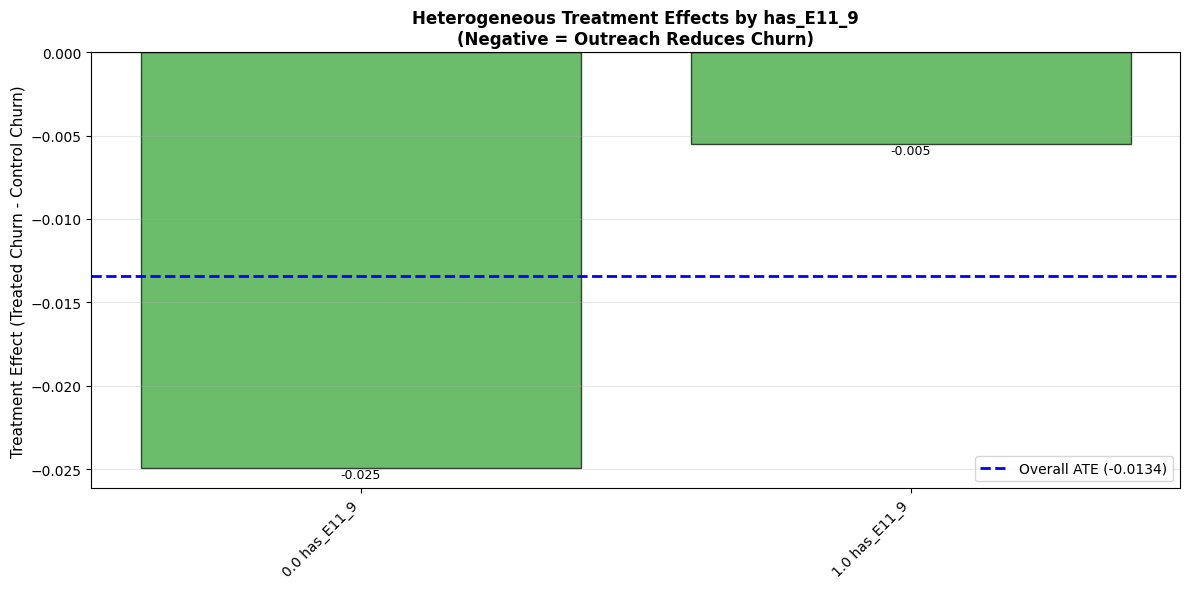


💡 CLINICAL INSIGHT for has_E11_9:
   ✅ BEST: 0.0 has_E11_9 shows strongest benefit (ATE=-0.0249)
      → Prioritize outreach for this segment (4120 members)

TREATMENT EFFECT BY HAS_I10 LEVEL
    Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_I10 -0.030551     4113       1645       2468       0.202432       0.232982
1.0 has_I10 -0.001570     5887       2339       3548       0.188115       0.189684

Overall ATE (reference): -0.0134


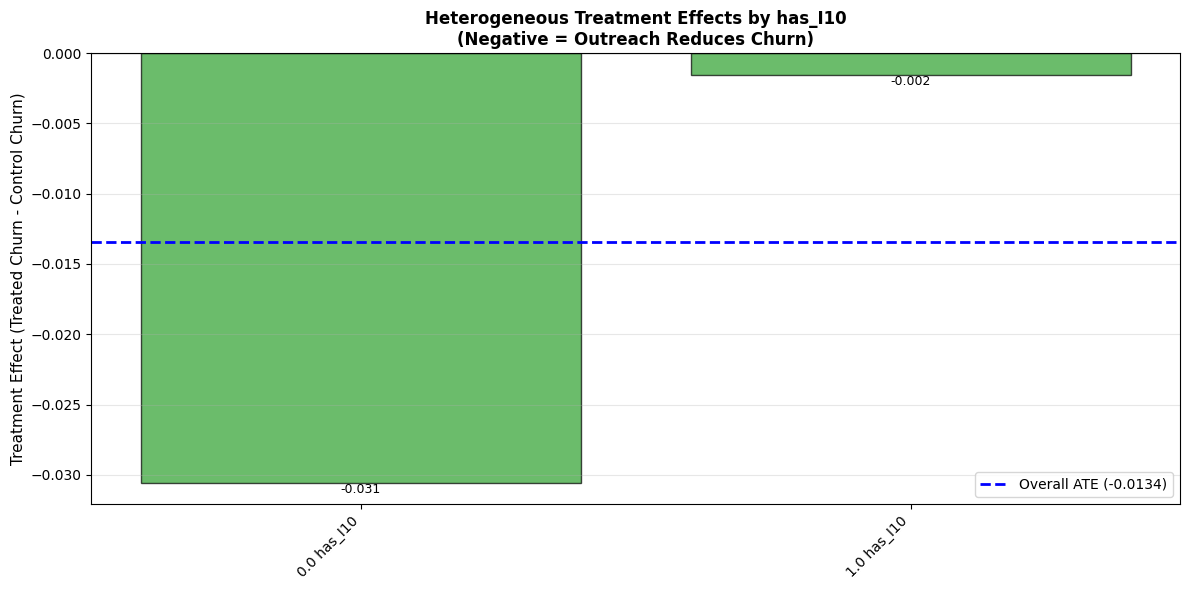


💡 CLINICAL INSIGHT for has_I10:
   ✅ BEST: 0.0 has_I10 shows strongest benefit (ATE=-0.0306)
      → Prioritize outreach for this segment (4113 members)

TREATMENT EFFECT BY HAS_Z71_3 LEVEL
      Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_Z71_3 -0.012038     4104       1610       2494       0.214907       0.226945
1.0 has_Z71_3 -0.013775     5896       2374       3522       0.179865       0.193640

Overall ATE (reference): -0.0134


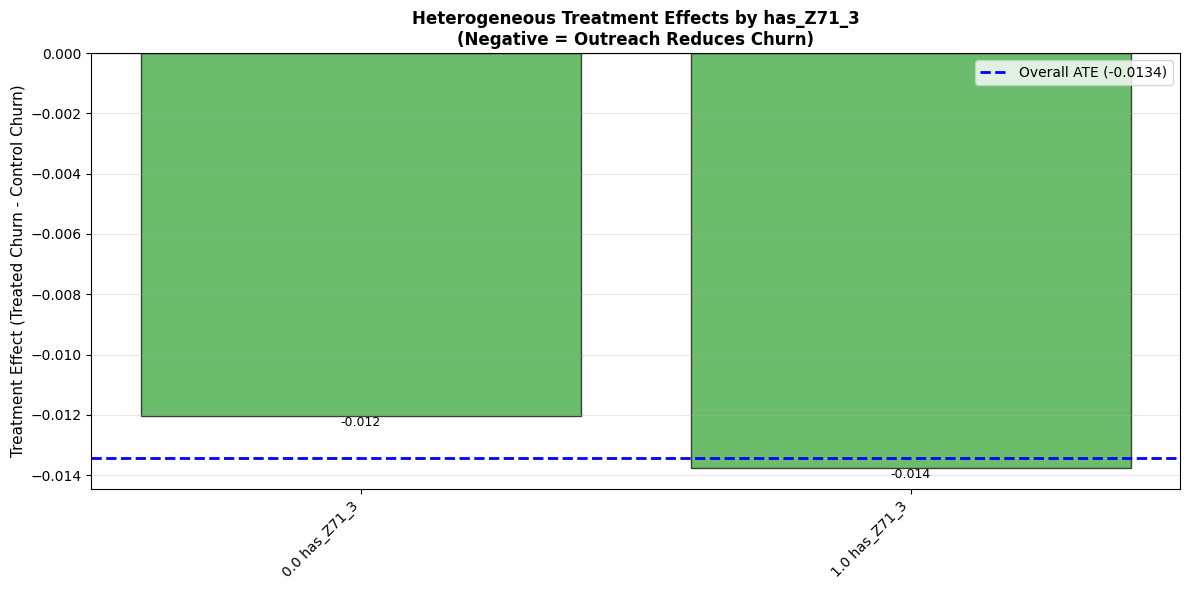


💡 CLINICAL INSIGHT for has_Z71_3:
   ✅ BEST: 1.0 has_Z71_3 shows strongest benefit (ATE=-0.0138)
      → Prioritize outreach for this segment (5896 members)

SUMMARY: Use these insights to target outreach based on uplift model predictions


In [ ]:
## Analyze Heterogeneous Treatment Effects by Segment

import matplotlib.pyplot as plt
import numpy as np

# Prepare data with labels
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train.values
X_train_with_labels["outreach"] = treatment_train.values

# Calculate overall ATE for reference
overall_ate = (
    y_train[treatment_train == 1].mean() - y_train[treatment_train == 0].mean()
)

# Features to analyze (WellCo clinical priorities)
features_ate = ["claims_count", "has_E11_9", "has_I10", "has_Z71_3"]

for feature in features_ate:
    if feature not in X_train.columns:
        print(f"\n⚠️  Feature '{feature}' not found in X_train, skipping...")
        continue

    # Check if feature has variation
    if X_train[feature].nunique() <= 1:
        print(f"\n⚠️  Feature '{feature}' has no variation, skipping...")
        continue

    # Handle features with few unique values (binary/categorical)
    unique_vals = X_train[feature].nunique()

    try:
        if unique_vals <= 3:
            # For binary/low-cardinality features, use actual values as segments
            X_train_with_labels[f"{feature}_level"] = X_train[feature].astype(str)
            segments = sorted(X_train_with_labels[f"{feature}_level"].unique())
        else:
            # For continuous features, create tertiles
            X_train_with_labels[f"{feature}_level"] = pd.qcut(
                X_train[feature],
                q=3,
                labels=["Low", "Medium", "High"],
                duplicates="drop",  # Handle tied values
            )
            segments = ["Low", "Medium", "High"]

        # Calculate ATE for each segment
        segment_ates = []
        for segment in segments:
            mask = X_train_with_labels[f"{feature}_level"] == segment

            # Check if we have both treated and control members in this segment
            n_treated = (mask & (treatment_train == 1)).sum()
            n_control = (mask & (treatment_train == 0)).sum()

            if n_treated == 0 or n_control == 0:
                print(
                    f"\n⚠️  Segment '{segment}' has no treated or control members, skipping..."
                )
                continue

            treated_churn = X_train_with_labels.loc[
                mask & (treatment_train == 1), "churn"
            ].mean()
            control_churn = X_train_with_labels.loc[
                mask & (treatment_train == 0), "churn"
            ].mean()

            segment_ate = treated_churn - control_churn
            n_members = mask.sum()

            segment_ates.append(
                {
                    "Segment": f"{segment} {feature}",
                    "ATE": segment_ate,
                    "Members": n_members,
                    "N_Treated": n_treated,
                    "N_Control": n_control,
                    "Treated_Churn": treated_churn,
                    "Control_Churn": control_churn,
                }
            )

        if len(segment_ates) == 0:
            print(f"\n⚠️  No valid segments for '{feature}', skipping...")
            continue

        ate_df = pd.DataFrame(segment_ates)

        # Print results
        print("\n" + "=" * 80)
        print(f"TREATMENT EFFECT BY {feature.upper()} LEVEL")
        print("=" * 80)
        print(ate_df.to_string(index=False))
        print(f"\nOverall ATE (reference): {overall_ate:.4f}")
        print("=" * 80)

        # Visualize
        fig, ax = plt.subplots(figsize=(12, 6))
        x = range(len(ate_df))
        colors = ["#d62728" if ate > 0 else "#2ca02c" for ate in ate_df["ATE"]]

        bars = ax.bar(x, ate_df["ATE"], color=colors, alpha=0.7, edgecolor="black")

        # Add value labels on bars
        for i, (idx, row) in enumerate(ate_df.iterrows()):
            ax.text(
                i,
                row["ATE"],
                f'{row["ATE"]:.3f}',
                ha="center",
                va="bottom" if row["ATE"] > 0 else "top",
                fontsize=9,
            )

        # Reference lines
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1, alpha=0.3)
        ax.axhline(
            y=overall_ate,
            color="blue",
            linestyle="--",
            linewidth=2,
            label=f"Overall ATE ({overall_ate:.4f})",
        )

        ax.set_xticks(x)
        ax.set_xticklabels(ate_df["Segment"], rotation=45, ha="right")
        ax.set_ylabel("Treatment Effect (Treated Churn - Control Churn)", fontsize=11)
        ax.set_title(
            f"Heterogeneous Treatment Effects by {feature}\n(Negative = Outreach Reduces Churn)",
            fontsize=12,
            fontweight="bold",
        )
        ax.legend(loc="best")
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Clinical interpretation for WellCo
        print(f"\n💡 CLINICAL INSIGHT for {feature}:")
        best_segment = ate_df.loc[ate_df["ATE"].idxmin()]
        worst_segment = ate_df.loc[ate_df["ATE"].idxmax()]

        if best_segment["ATE"] < overall_ate:
            print(
                f"   ✅ BEST: {best_segment['Segment']} shows strongest benefit (ATE={best_segment['ATE']:.4f})"
            )
            print(
                f"      → Prioritize outreach for this segment ({best_segment['Members']} members)"
            )

        if worst_segment["ATE"] > 0:
            print(
                f"   ⚠️  WORST: {worst_segment['Segment']} shows harm/no benefit (ATE={worst_segment['ATE']:.4f})"
            )
            print(
                f"      → Avoid outreach for this segment ({worst_segment['Members']} members)"
            )

    except Exception as e:
        print(f"\n❌ Error processing '{feature}': {str(e)}")
        continue

print("\n" + "=" * 80)
print(
    "SUMMARY: Use these insights to target outreach based on uplift model predictions"
)
print("=" * 80)

---

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [ ]:
f1_micro = cross_val_score(
    X=X_train,
    y=treatment_train,
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    scoring="f1_micro",
    cv=3,
)

print(f'F1 micro {f1_micro.mean():.2f}')

[LightGBM] [Info] Number of positive: 2656, number of negative: 4010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398440 -> initscore=-0.411970
[LightGBM] [Info] Start training from score -0.411970
[LightGBM] [Info] Number of positive: 2656, number of negative: 4011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398380 -> initscore=-0.412219
[LightGBM] [Info] Start training from score -0.412219
[LightGBM] [Info] 

the tratment is nor random

In [ ]:
## Identify Features That Predict Treatment Assignment

from lightgbm import LGBMClassifier
import pandas as pd

# Train a model to predict outreach
propensity_model = LGBMClassifier(random_state=42, n_jobs=-1, n_estimators=100)
propensity_model.fit(X_train, treatment_train)

# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": propensity_model.feature_importances_}
).sort_values("importance", ascending=False)

print("=" * 70)
print("TOP FEATURES PREDICTING OUTREACH ASSIGNMENT (Selection Bias)")
print("=" * 70)
print(feature_importance.head(20).to_string(index=False))

# Clinical interpretation (WellCo priorities from data/wellco_client_brief.txt)
print("\n💡 CLINICAL INSIGHT:")
top_feature = feature_importance.iloc[0]["feature"]
print(f"   → '{top_feature}' most strongly predicts who received outreach")
print("   → This suggests outreach was NOT randomized")
print("   → Must adjust for propensity score in uplift model")

[LightGBM] [Info] Number of positive: 3984, number of negative: 6016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398400 -> initscore=-0.412136
[LightGBM] [Info] Start training from score -0.412136
TOP FEATURES PREDICTING OUTREACH ASSIGNMENT (Selection Bias)
                             feature  importance
                        days_as_user         522
                  welco_domain_ratio         298
                  weekly_visits_diff         211
                     app_usage_count         208
                  not_wellco_domains         170
        weeks_from_outreach_2_visits         163
                days_from_last_claim         151
                    total_web_visits         143
      

In [ ]:
from sklearn.model_selection import cross_val_predict

# Estimate propensity scores using cross-validation (avoid overfitting)
propensity_scores_train = cross_val_predict(
    propensity_model, X_train, treatment_train, cv=5, method="predict_proba"
)[
    :, 1
]  # Probability of outreach=1

propensity_scores_test = propensity_model.predict_proba(X_test)[:, 1]

# Add to feature set for uplift modeling
X_train["propensity_score"] = propensity_scores_train
X_test["propensity_score"] = propensity_scores_test

print("✅ Propensity scores calculated")
print(
    f"   Train propensity range: [{propensity_scores_train.min():.3f}, {propensity_scores_train.max():.3f}]"
)
print(
    f"   Test propensity range: [{propensity_scores_test.min():.3f}, {propensity_scores_test.max():.3f}]"
)

[LightGBM] [Info] Number of positive: 3188, number of negative: 4812

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398500 -> initscore=-0.411719
[LightGBM] [Info] Start training from score -0.411719
[LightGBM] [Info] Number of positive: 3187, number of negative: 4813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398375 -> initscore=-0.412241
[LightGBM] [Info] Start training from score -0.412241
[LightGBM] [Info]

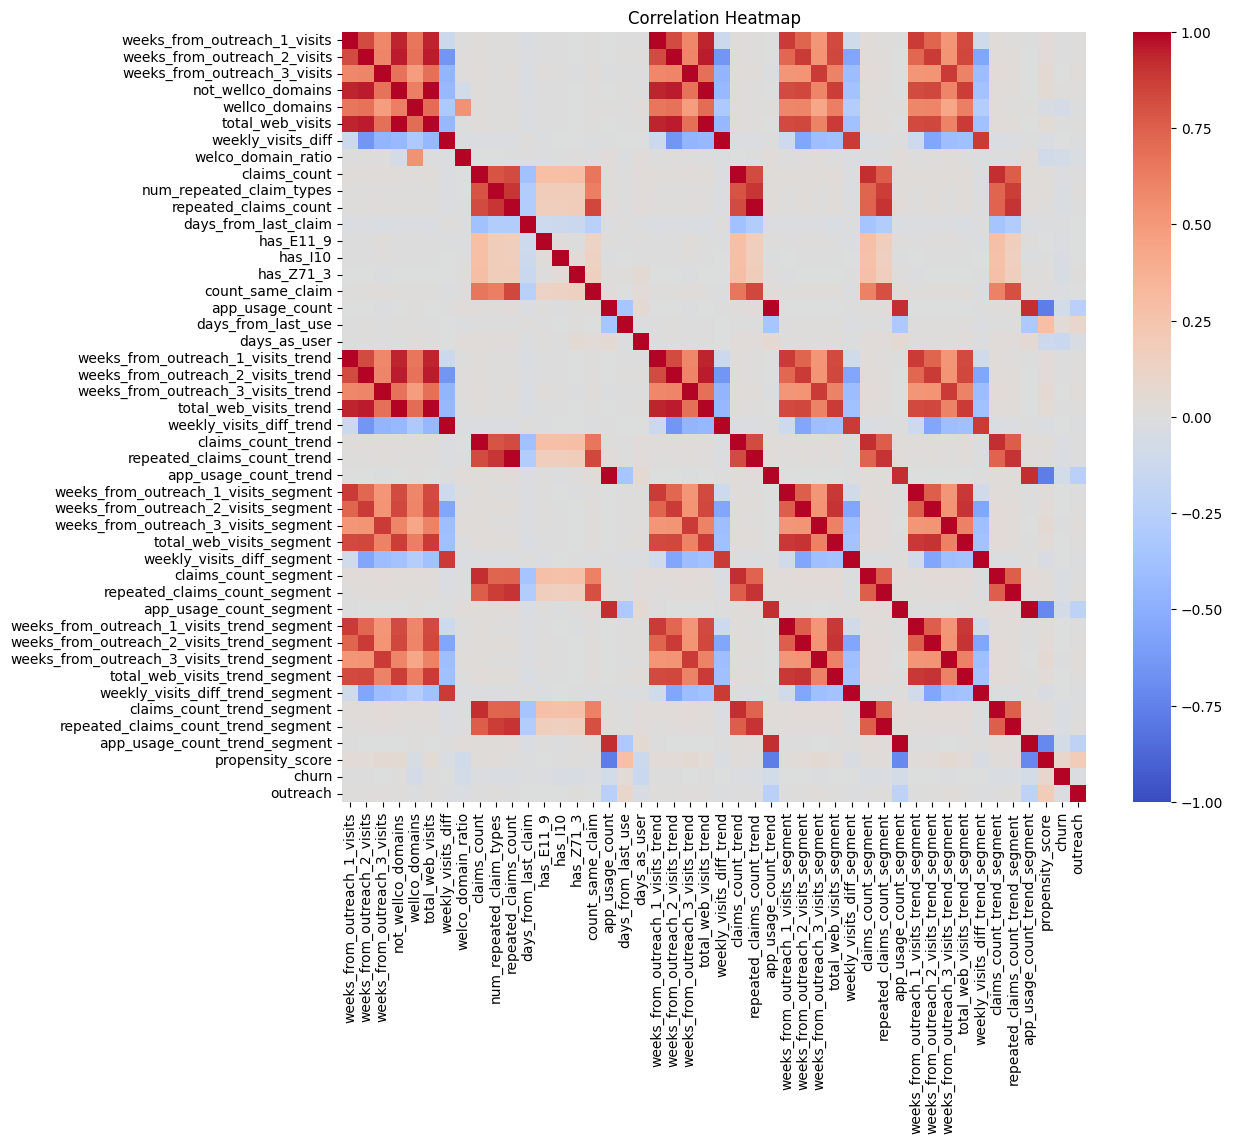

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Combine X_train with churn and outreach
X_train_with_labels = X_train.copy()
X_train_with_labels['churn'] = y_train
X_train_with_labels['outreach'] = treatment_train

# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

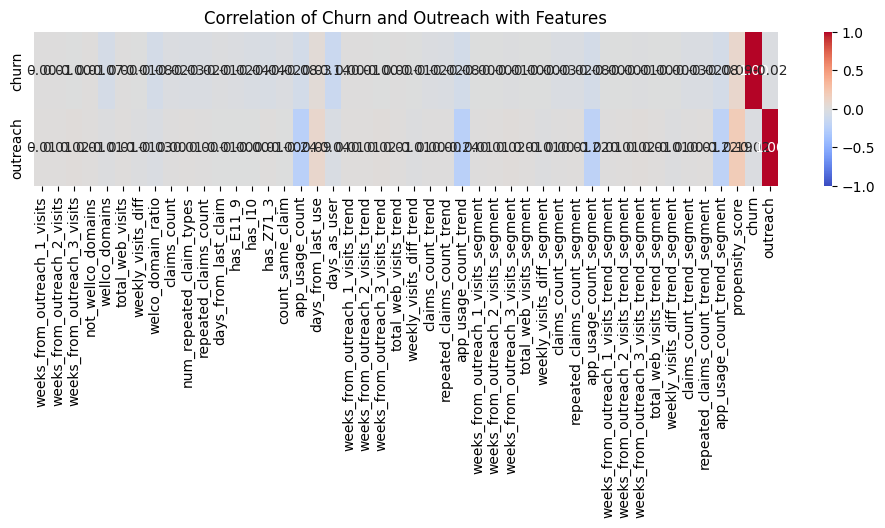

In [ ]:
# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Filter the correlation matrix to show only 'churn' and 'outreach' correlations with all features
filtered_corr = corr_matrix.loc[["churn", "outreach"]]

# Display the filtered correlation matrix
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Churn and Outreach with Features")
plt.show()


In [ ]:
## Correlation Analysis: Identify Redundant Features

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get correlation matrix (already computed in previous cell)
corr_abs = corr_matrix.abs()

# 1. Find highly correlated feature pairs (threshold: 0.8)
upper_triangle = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
high_corr_pairs = []

for i in range(len(corr_abs.columns)):
    for j in range(i + 1, len(corr_abs.columns)):
        if corr_abs.iloc[i, j] > 0.8:
            high_corr_pairs.append(
                {
                    "Feature_1": corr_abs.columns[i],
                    "Feature_2": corr_abs.columns[j],
                    "Correlation": corr_abs.iloc[i, j],
                }
            )

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation", ascending=False)

print("=" * 80)
print("HIGHLY CORRELATED FEATURES (|r| > 0.8)")
print("=" * 80)
if len(high_corr_df) > 0:
    print(high_corr_df.head(20).to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr_df)}")
else:
    print("✅ No feature pairs with |correlation| > 0.8")

# 2. Check correlation with target (churn) and treatment (outreach)
target_corr = (
    corr_matrix[["churn", "outreach"]].abs().sort_values("churn", ascending=False)
)

print("\n" + "=" * 80)
print("FEATURE CORRELATION WITH CHURN & OUTREACH")
print("=" * 80)
print(target_corr.head(20).to_string())

# 3. Identify features to potentially drop
# Rule: If two features correlated > 0.8, drop the one with lower correlation to churn
features_to_drop = set()

for _, row in high_corr_df.iterrows():
    feat1, feat2 = row["Feature_1"], row["Feature_2"]

    # Skip if already marked for dropping
    if feat1 in features_to_drop or feat2 in features_to_drop:
        continue

    # Compare correlation with churn
    if feat1 in target_corr.index and feat2 in target_corr.index:
        corr1 = target_corr.loc[feat1, "churn"]
        corr2 = target_corr.loc[feat2, "churn"]

        # Drop the feature with weaker correlation to churn
        if corr1 < corr2:
            features_to_drop.add(feat1)
        else:
            features_to_drop.add(feat2)

print("\n" + "=" * 80)
print("RECOMMENDED FEATURES TO DROP (Redundant + Weak Churn Correlation)")
print("=" * 80)
if len(features_to_drop) > 0:
    print(f"Total features to drop: {len(features_to_drop)}")
    print(sorted(features_to_drop))
else:
    print("✅ No redundant features detected")

# 4. Variance Inflation Factor (VIF) check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features (exclude target/treatment if still present)
numeric_cols = [
    col
    for col in X_train.columns
    if col not in ["churn", "outreach"] and X_train[col].dtype in ["float64", "int64"]
]

# Sample if too many features (VIF is slow)
if len(numeric_cols) > 50:
    print(
        f"\n⚠️  Sampling 50 features for VIF analysis (full dataset has {len(numeric_cols)} features)"
    )
    numeric_cols_sample = np.random.choice(numeric_cols, 50, replace=False).tolist()
else:
    numeric_cols_sample = numeric_cols

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols_sample
vif_data["VIF"] = [
    variance_inflation_factor(X_train[numeric_cols_sample].fillna(0).values, i)
    for i in range(len(numeric_cols_sample))
]
vif_data = vif_data.sort_values("VIF", ascending=False)

print("\n" + "=" * 80)
print("VARIANCE INFLATION FACTOR (VIF) - Top 20 Features")
print("VIF > 10 indicates severe multicollinearity")
print("=" * 80)
print(vif_data.head(20).to_string(index=False))

# 5. PCA Recommendation
print("\n" + "=" * 80)
print("PCA vs FEATURE SELECTION RECOMMENDATION")
print("=" * 80)

n_features = X_train.shape[1]
n_high_corr = len(high_corr_df)
n_vif_high = (vif_data["VIF"] > 10).sum()

print(f"\n📊 DATASET SUMMARY:")
print(f"   Total features: {n_features}")
print(f"   Highly correlated pairs: {n_high_corr}")
print(f"   Features with VIF > 10: {n_vif_high}")
print(f"   Recommended to drop: {len(features_to_drop)}")

print(f"\n💡 RECOMMENDATION:")

if n_high_corr > 20 or n_vif_high > 10:
    print("   ⚠️  HIGH MULTICOLLINEARITY DETECTED")
    print("   → Option 1: Drop redundant features (simple, interpretable)")
    print(
        "   → Option 2: Use PCA (loses interpretability, may help with regularization)"
    )
    print("\n   For WellCo uplift modeling (per data/wellco_client_brief.txt):")
    print("   ✅ RECOMMENDED: Drop redundant features")
    print("      - Preserves clinical interpretability (ICD-10 codes, claims_count)")
    print("      - LightGBM handles remaining collinearity well")
    print("   ❌ AVOID PCA for now:")
    print("      - Loses domain meaning (can't explain 'PC1' to clinicians)")
    print("      - Use only if dimensionality reduction is critical for compute")
else:
    print("   ✅ MODERATE MULTICOLLINEARITY")
    print(
        "   → Drop {0} redundant features (correlation > 0.8)".format(
            len(features_to_drop)
        )
    )
    print("   → PCA not needed — LightGBM handles remaining correlations")

# 6. Save features to drop for reproducibility
if len(features_to_drop) > 0:
    output_path = repo_root / "outputs" / f"features_to_drop_{timestamp}.txt"
    with open(output_path, "w") as f:
        f.write("\n".join(sorted(features_to_drop)))
    print(f"\n✅ Redundant features list saved to: {output_path}")

HIGHLY CORRELATED FEATURES (|r| > 0.8)
                           Feature_1                                  Feature_2  Correlation
        weeks_from_outreach_1_visits         weeks_from_outreach_1_visits_trend     1.000000
                    total_web_visits                     total_web_visits_trend     1.000000
                  weekly_visits_diff                   weekly_visits_diff_trend     1.000000
               repeated_claims_count                repeated_claims_count_trend     1.000000
        weeks_from_outreach_3_visits         weeks_from_outreach_3_visits_trend     1.000000
                     app_usage_count                      app_usage_count_trend     1.000000
       repeated_claims_count_segment        repeated_claims_count_trend_segment     1.000000
          weekly_visits_diff_segment           weekly_visits_diff_trend_segment     1.000000
        weeks_from_outreach_2_visits         weeks_from_outreach_2_visits_trend     1.000000
             app_usage_count_se

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. 


VARIANCE INFLATION FACTOR (VIF) - Top 20 Features
VIF > 10 indicates severe multicollinearity
                                   Feature  VIF
              weeks_from_outreach_1_visits  inf
              weeks_from_outreach_2_visits  inf
                        claims_count_trend  inf
               repeated_claims_count_trend  inf
                     app_usage_count_trend  inf
      weeks_from_outreach_1_visits_segment  inf
      weeks_from_outreach_2_visits_segment  inf
      weeks_from_outreach_3_visits_segment  inf
                  total_web_visits_segment  inf
                weekly_visits_diff_segment  inf
                      claims_count_segment  inf
             repeated_claims_count_segment  inf
                   app_usage_count_segment  inf
weeks_from_outreach_1_visits_trend_segment  inf
weeks_from_outreach_2_visits_trend_segment  inf
weeks_from_outreach_3_visits_trend_segment  inf
            total_web_visits_trend_segment  inf
          weekly_visits_diff_trend_segmen

In [ ]:
## Drop Redundant Features (If Recommended Above)

if len(features_to_drop) > 0:
    print(f"Dropping {len(features_to_drop)} redundant features...")
    X_train_reduced = X_train.drop(columns=list(features_to_drop))
    X_test_reduced = X_test.drop(columns=list(features_to_drop))

    print(f"Original shape: {X_train.shape}")
    print(f"Reduced shape:  {X_train_reduced.shape}")

    # Use X_train_reduced for modeling
else:
    print("No features to drop — proceed with current feature set")
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()

Dropping 28 redundant features...
Original shape: (10000, 44)
Reduced shape:  (10000, 16)


In [ ]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
train_data_outreach_grouped

,weeks_from_outreach_1_visits,weeks_from_outreach_2_visits,weeks_from_outreach_3_visits,not_wellco_domains,wellco_domains,total_web_visits,weekly_visits_diff,welco_domain_ratio,claims_count,num_repeated_claim_types,...,app_usage_count_segment,weeks_from_outreach_1_visits_trend_segment,weeks_from_outreach_2_visits_trend_segment,weeks_from_outreach_3_visits_trend_segment,total_web_visits_trend_segment,weekly_visits_diff_trend_segment,claims_count_trend_segment,repeated_claims_count_trend_segment,app_usage_count_trend_segment,propensity_score
outreach,,,,,,,,,,,,,,,,,,,,,
0,11.087267,12.866523,1.818983,23.219249,2.553524,25.772773,-3.598238,0.098863,6.448637,1.387799,...,1.698138,1.493351,1.491356,1.481882,1.491024,1.509309,1.496177,1.490027,1.698138,0.375626
1,11.238956,13.053966,1.884538,23.688504,2.488956,26.177460,-3.699548,0.094349,6.471135,1.408635,...,1.200803,1.510040,1.513052,1.527359,1.513554,1.485944,1.505773,1.515060,1.200803,0.433839


In [ ]:
def compare_train_test_performance(
    model, X_tr, X_te, y_tr, y_te, t_tr, t_te, model_name="Model"
):
    """Compare model performance on train vs test to detect overfitting"""

    # Predict on both sets
    uplift_train = model.predict(X_tr)
    uplift_test = model.predict(X_te)

    # Calculate Qini AUC
    qini_train = qini_auc_score(y_tr, uplift_train, t_tr)
    qini_test = qini_auc_score(y_te, uplift_test, t_te)

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    from sklift.viz import plot_qini_curve

    plot_qini_curve(y_tr, uplift_train, t_tr, perfect=True, name="Train", ax=ax1)
    ax1.set_title(f"{model_name} - Train (Qini AUC: {qini_train:.4f})")

    plot_qini_curve(y_te, uplift_test, t_te, perfect=True, name="Test", ax=ax2)
    ax2.set_title(f"{model_name} - Test (Qini AUC: {qini_test:.4f})")

    plt.tight_layout()
    plt.show()

    # Calculate overfitting gap
    gap = qini_train - qini_test
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"Train Qini AUC: {qini_train:.4f}")
    print(f"Test Qini AUC:  {qini_test:.4f}")
    print(f"Overfitting Gap: {gap:.4f} ({gap/qini_train*100:.1f}% relative)")

    if gap > 0.01:
        print("⚠️  WARNING: Significant overfitting detected!")
    elif gap > 0.005:
        print("⚠️  Mild overfitting detected")
    else:
        print("✅ Good generalization")
    print(f"{'='*60}\n")

    return qini_train, qini_test, gap

In [ ]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
test_data_outreach_grouped = X_test.groupby(treatment_test).mean()

# Calculate the absolute difference between outreach=0 and outreach=1 for each column
column_diffs_train = (
    train_data_outreach_grouped.loc[0] - train_data_outreach_grouped.loc[1]
).abs()
column_diffs_test = (
    test_data_outreach_grouped.loc[0] - test_data_outreach_grouped.loc[1]
).abs()

# Sort the columns by the calculated differences in descending order
sorted_columns_train = column_diffs_train.sort_values(ascending=False)
sorted_columns_test = column_diffs_test.sort_values(ascending=False)

# Display the sorted columns
print(sorted_columns_train[0:10])
print("----")
print(sorted_columns_test[0:10])

days_as_user                          11.754600
app_usage_count_trend                  1.760757
app_usage_count                        1.760757
app_usage_count_trend_segment          0.497335
app_usage_count_segment                0.497335
not_wellco_domains                     0.469255
total_web_visits_trend                 0.404687
total_web_visits                       0.404687
days_from_last_use                     0.265178
weeks_from_outreach_2_visits_trend     0.187443
dtype: float64
----
days_as_user                     14.429246
app_usage_count                   1.836696
app_usage_count_trend             1.836696
app_usage_count_trend_segment     0.540485
app_usage_count_segment           0.540485
days_from_last_use                0.270322
not_wellco_domains                0.121177
days_from_last_claim              0.067854
total_web_visits                  0.067573
total_web_visits_trend            0.067573
dtype: float64


In [ ]:
train_data_churn_grouped = X_train.groupby(y_train).mean()
test_data_churn_grouped = X_test.groupby(y_test).mean()

# Calculate the absolute difference between outreach=0 and outreach=1 for each column
column_diffs_train = (
    train_data_churn_grouped.loc[0] - train_data_churn_grouped.loc[1]
)
column_diffs_test = (
    test_data_churn_grouped.loc[0] - test_data_churn_grouped.loc[1]
)

# Sort the columns by the calculated differences in descending order
sorted_columns_train = column_diffs_train.sort_values(ascending=False)
sorted_columns_test = column_diffs_test.sort_values(ascending=False)

# Display the sorted columns
print(sorted_columns_train)
print("----")
print(sorted_columns_test)

days_as_user                                  51.014107
app_usage_count                                0.710770
app_usage_count_trend                          0.710770
wellco_domains                                 0.409092
app_usage_count_trend_segment                  0.209295
app_usage_count_segment                        0.209295
claims_count                                   0.144373
claims_count_trend                             0.144373
weekly_visits_diff                             0.110005
weekly_visits_diff_trend                       0.110005
repeated_claims_count                          0.093700
repeated_claims_count_trend                    0.093700
claims_count_trend_segment                     0.075966
claims_count_segment                           0.075966
num_repeated_claim_types                       0.071637
repeated_claims_count_segment                  0.066044
repeated_claims_count_trend_segment            0.066044
has_Z71_3                                      0

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select only top K most informative features
print(f"Original features: {X_train.shape[1]}")

# Use mutual information to find features predictive of churn
selector = SelectKBest(mutual_info_classif, k=20)  # Keep top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Convert back to DataFrame with selected column names
selected_features = X_train.columns[selector.get_support()].tolist()
X_train_selected = pd.DataFrame(
    X_train_selected, columns=selected_features, index=X_train.index
)
X_test_selected = pd.DataFrame(
    X_test_selected, columns=selected_features, index=X_test.index
)

print(f"Selected features: {X_train_selected.shape[1]}")
print("Top features:", selected_features[:10])

# Now train on reduced feature set

Original features: 44
Selected features: 20
Top features: ['weeks_from_outreach_1_visits', 'not_wellco_domains', 'weekly_visits_diff', 'welco_domain_ratio', 'claims_count', 'num_repeated_claim_types', 'repeated_claims_count', 'has_I10', 'has_Z71_3', 'app_usage_count']
Selected features: 20
Top features: ['weeks_from_outreach_1_visits', 'not_wellco_domains', 'weekly_visits_diff', 'welco_domain_ratio', 'claims_count', 'num_repeated_claim_types', 'repeated_claims_count', 'has_I10', 'has_Z71_3', 'app_usage_count']


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
## Elastic Net Logistic Regression

logistic_elasticnet = LogisticRegression(
    random_state=42,
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",  # Mix of L1 and L2
    solver="saga",
    C=0.2,
    l1_ratio=0.1,  # 0.5 = equal mix of L1 and L2
)

slearner_logistic_enet = SoloModel(estimator=logistic_elasticnet)
slearner_logistic_enet.fit(X_train, y_train, treatment=treatment_train)

uplift_test_enet = slearner_logistic_enet.predict(X_test)
test_qini_enet = qini_auc_score(y_test, uplift_test_enet, treatment_test)
print(f"Elastic Net Logistic Test Qini AUC: {test_qini_enet:.4f}")
uplift_train_enet = slearner_logistic_enet.predict(X_train)
train_qini_enet = qini_auc_score(y_train, uplift_train_enet, treatment_train)
print(f"Elastic Net Logistic Train Qini AUC: {train_qini_enet:.4f}")

Elastic Net Logistic Test Qini AUC: 0.0530
Elastic Net Logistic Train Qini AUC: 0.0336


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


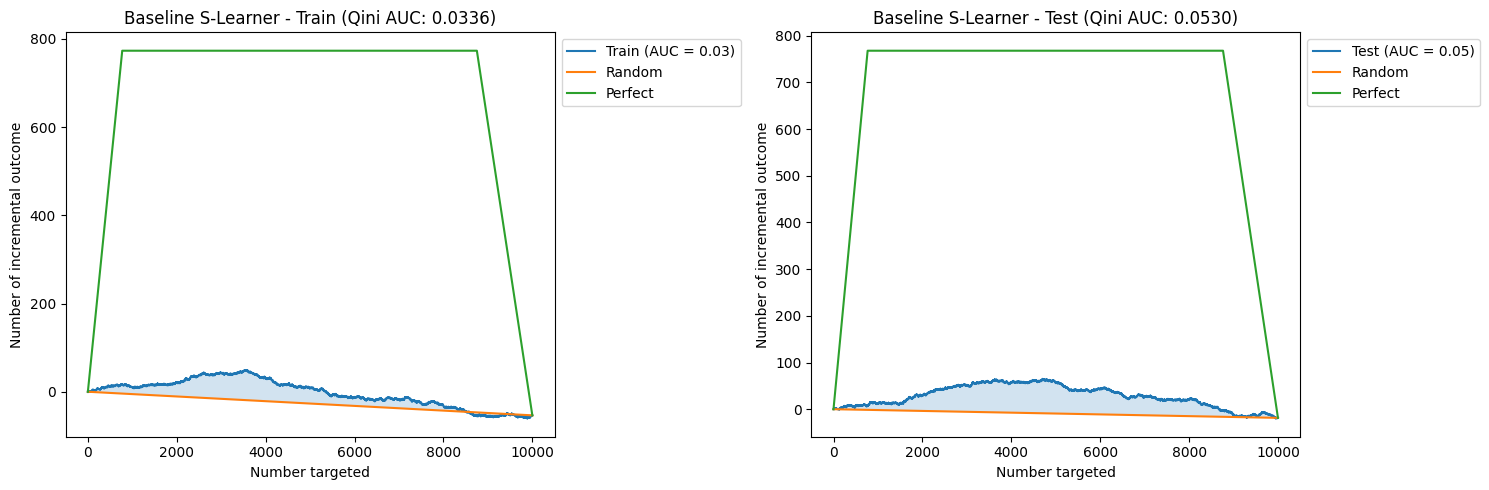


Model: Baseline S-Learner
Train Qini AUC: 0.0336
Test Qini AUC:  0.0530
Overfitting Gap: -0.0194 (-57.8% relative)
✅ Good generalization



(0.0336006073976038, 0.05301028231810622, -0.01940967492050242)

In [ ]:
compare_train_test_performance(
    slearner_logistic_enet,
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    model_name="Baseline S-Learner",
)

In [27]:
## S-Learner with Propensity Score as Feature

# Verify propensity_score is in X_train and X_test (from earlier cell)
if "propensity_score" not in X_train.columns:
    print(
        "⚠️  WARNING: propensity_score not found. Run propensity score calculation first."
    )
else:
    print(f"✅ Using {X_train.shape[1]} features including propensity_score")

# Train S-Learner with propensity score as a feature
logistic_elasticnet = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
    C=1.0,
    l1_ratio=0.5,
)

slearner_with_propensity = SoloModel(estimator=logistic_elasticnet)
slearner_with_propensity.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_test_propensity = slearner_with_propensity.predict(X_test)
test_qini_propensity = qini_auc_score(y_test, uplift_test_propensity, treatment_test)

uplift_train_propensity = slearner_with_propensity.predict(X_train)
train_qini_propensity = qini_auc_score(
    y_train, uplift_train_propensity, treatment_train
)

print("\n" + "=" * 70)
print("S-LEARNER WITH PROPENSITY SCORE AS FEATURE")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_propensity:.4f}")
print(f"Test Qini AUC:  {test_qini_propensity:.4f}")
print(f"Overfitting Gap: {train_qini_propensity - test_qini_propensity:.4f}")
print("=" * 70)

✅ Using 44 features including propensity_score

S-LEARNER WITH PROPENSITY SCORE AS FEATURE
Train Qini AUC: 0.0343
Test Qini AUC:  0.0535
Overfitting Gap: -0.0191

S-LEARNER WITH PROPENSITY SCORE AS FEATURE
Train Qini AUC: 0.0343
Test Qini AUC:  0.0535
Overfitting Gap: -0.0191


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
## S-Learner with Inverse Propensity Weighting (IPW)

import numpy as np

# Calculate IPW weights (stabilized version)
ipw_weights_train = np.where(
    treatment_train == 1,
    1 / X_train["propensity_score"],  # Treated members
    1 / (1 - X_train["propensity_score"]),  # Control members
)

# Clip extreme weights to prevent instability (95th percentile)
ipw_weights_train_clipped = np.clip(
    ipw_weights_train, 0, np.percentile(ipw_weights_train, 95)
)

print(
    f"IPW weights range: [{ipw_weights_train_clipped.min():.2f}, {ipw_weights_train_clipped.max():.2f}]"
)

# Remove propensity_score from features (already used for weighting)
X_train_no_propensity = X_train.drop(columns=["propensity_score"])
X_test_no_propensity = X_test.drop(columns=["propensity_score"])

# Train S-Learner with IPW weights
# Note: SoloModel doesn't directly support sample_weight, so we use underlying estimator
from sklift.models import SoloModel


# Create weighted S-Learner manually
class WeightedSLearner:
    """S-Learner with IPW support (per WellCo causal inference requirements)"""

    def __init__(self, estimator):
        self.estimator = estimator
        self.treatment_col_name = None

    def fit(self, X, y, treatment, sample_weight=None):
        """Fit with treatment as feature + IPW weights"""
        X_with_treatment = X.copy()
        X_with_treatment["_treatment"] = treatment
        self.treatment_col_name = "_treatment"

        # Fit with IPW weights
        self.estimator.fit(X_with_treatment, y, sample_weight=sample_weight)
        return self

    def predict(self, X):
        """Predict uplift = P(Y|T=1,X) - P(Y|T=0,X)"""
        X_treated = X.copy()
        X_control = X.copy()
        X_treated[self.treatment_col_name] = 1
        X_control[self.treatment_col_name] = 0

        # Use predict_proba for probabilistic uplift
        pred_treated = self.estimator.predict_proba(X_treated)[:, 1]
        pred_control = self.estimator.predict_proba(X_control)[:, 1]

        return pred_treated - pred_control


# Train with IPW weights
logistic_ipw = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
    C=1.0,
    l1_ratio=0.5,
)

slearner_ipw = WeightedSLearner(estimator=logistic_ipw)
slearner_ipw.fit(
    X_train_no_propensity,
    y_train,
    treatment=treatment_train,
    sample_weight=ipw_weights_train_clipped,
)

# Evaluate
uplift_test_ipw = slearner_ipw.predict(X_test_no_propensity)
test_qini_ipw = qini_auc_score(y_test, uplift_test_ipw, treatment_test)

uplift_train_ipw = slearner_ipw.predict(X_train_no_propensity)
train_qini_ipw = qini_auc_score(y_train, uplift_train_ipw, treatment_train)

print("\n" + "=" * 70)
print("S-LEARNER WITH IPW (Propensity-Weighted)")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_ipw:.4f}")
print(f"Test Qini AUC:  {test_qini_ipw:.4f}")
print(f"Overfitting Gap: {train_qini_ipw - test_qini_ipw:.4f}")
print("=" * 70)

IPW weights range: [1.02, 3.89]

S-LEARNER WITH IPW (Propensity-Weighted)
Train Qini AUC: 0.0350
Test Qini AUC:  0.0548
Overfitting Gap: -0.0198

S-LEARNER WITH IPW (Propensity-Weighted)
Train Qini AUC: 0.0350
Test Qini AUC:  0.0548
Overfitting Gap: -0.0198


In [29]:
## Compare All Approaches

comparison_df = pd.DataFrame(
    {
        "Model": [
            "Naive S-Learner (no propensity)",
            "S-Learner + Propensity Feature",
            "S-Learner + IPW Weighting",
        ],
        "Train_Qini": [train_qini_enet, train_qini_propensity, train_qini_ipw],
        "Test_Qini": [test_qini_enet, test_qini_propensity, test_qini_ipw],
    }
)

comparison_df["Gap"] = comparison_df["Train_Qini"] - comparison_df["Test_Qini"]
comparison_df["Improvement_vs_Naive"] = comparison_df["Test_Qini"] - test_qini_enet

print("\n" + "=" * 80)
print("PROPENSITY ADJUSTMENT COMPARISON (Per WellCo Causal Inference Requirements)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n💡 RECOMMENDATION:")
print("   → Use IPW if selection bias is strong (F1=0.61 suggests it is)")
print(
    "   → Use propensity-as-feature if you want model to learn non-linear adjustments"
)
print("=" * 80)

# Save comparison (per .github/copilot-instructions.md)
comparison_path = repo_root / "outputs" / f"propensity_comparison_{timestamp}.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✅ Comparison saved to: {comparison_path}")


PROPENSITY ADJUSTMENT COMPARISON (Per WellCo Causal Inference Requirements)
                          Model  Train_Qini  Test_Qini       Gap  Improvement_vs_Naive
Naive S-Learner (no propensity)    0.034310   0.053453 -0.019143              0.000000
 S-Learner + Propensity Feature    0.034310   0.053453 -0.019143              0.000000
      S-Learner + IPW Weighting    0.035013   0.054845 -0.019832              0.001393

💡 RECOMMENDATION:
   → Use IPW if selection bias is strong (F1=0.61 suggests it is)
   → Use propensity-as-feature if you want model to learn non-linear adjustments

✅ Comparison saved to: c:\Users\elad\Desktop\rnd\VI\wellco_churn\outputs\propensity_comparison_20251114T205812Z.csv


Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.

In [56]:
## S-Learner with LightGBM (Non-Linear Model)

from lightgbm import LGBMClassifier
from sklift.models import SoloModel

# LightGBM with moderate regularization (per .github/copilot-instructions.md)
lgbm_estimator = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=200,  # Enough trees to capture complexity
    max_depth=4,  # Prevent overfitting (default=unlimited)
    learning_rate=0.05,  # Conservative learning rate
    min_child_samples=50,  # Require 50 samples per leaf (prevent overfitting)
    reg_alpha=5.0,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    class_weight="balanced",  # Handle class imbalance
)

# Train S-Learner with LightGBM
slearner_lgbm = SoloModel(estimator=lgbm_estimator)
slearner_lgbm.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_lgbm = slearner_lgbm.predict(X_train)
uplift_test_lgbm = slearner_lgbm.predict(X_test)

train_qini_lgbm = qini_auc_score(y_train, uplift_train_lgbm, treatment_train)
test_qini_lgbm = qini_auc_score(y_test, uplift_test_lgbm, treatment_test)

print("\n" + "=" * 70)
print("S-LEARNER WITH LIGHTGBM (NON-LINEAR)")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_lgbm:.4f}")
print(f"Test Qini AUC:  {test_qini_lgbm:.4f}")
print(f"Overfitting Gap: {train_qini_lgbm - test_qini_lgbm:.4f}")
print("=" * 70)

# Compare to logistic regression
improvement = test_qini_lgbm - test_qini_enet
print(
    f"\n💡 Improvement over Logistic Regression: {improvement:.4f} ({improvement/test_qini_enet*100:.1f}% relative)"
)

[LightGBM] [Info] Number of positive: 2021, number of negative: 7979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# exp

## Experiment 1: T-Learner (Two-Model Approach)

T-Learner trains separate models for treatment and control groups, then estimates uplift as the difference in predictions.

[LightGBM] [Info] Number of positive: 1248, number of negative: 4768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 6016, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

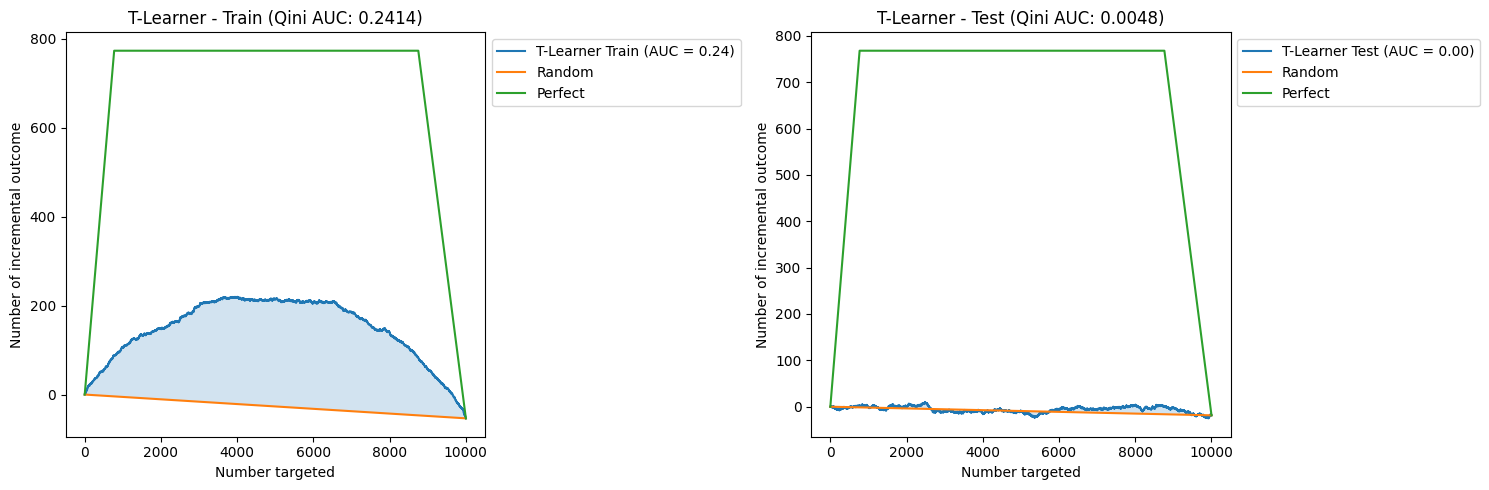

In [38]:
from sklift.models import TwoModels

# Create SEPARATE instances for treatment and control to avoid sklearn error
lgbm_t_treatment = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,  # Reduced from 300
    max_depth=3,  # Shallow trees to prevent overfitting
    learning_rate=0.1,  # Increased from 0.03
    min_child_samples=100,  # Increased from 30
    reg_alpha=10.0,  # Strong L1 regularization
    reg_lambda=5.0,  # Strong L2 regularization
    class_weight="balanced",
    min_split_gain=0.1,  # Require minimum gain to split
    subsample=0.7,  # Bagging
    colsample_bytree=0.7,  # Feature sampling
)

lgbm_t_control = LGBMClassifier(
    random_state=43,  # Different seed
    n_jobs=-1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_samples=100,
    reg_alpha=10.0,
    reg_lambda=5.0,
    class_weight="balanced",
    min_split_gain=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
)

tlearner = TwoModels(
    estimator_trmnt=lgbm_t_treatment, estimator_ctrl=lgbm_t_control, method="vanilla"
)

tlearner.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_tlearner = tlearner.predict(X_train)
uplift_test_tlearner = tlearner.predict(X_test)

train_qini_tlearner = qini_auc_score(y_train, uplift_train_tlearner, treatment_train)
test_qini_tlearner = qini_auc_score(y_test, uplift_test_tlearner, treatment_test)

print("\n" + "=" * 70)
print("T-LEARNER (REGULARIZED) WITH LIGHTGBM")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_tlearner:.4f}")
print(f"Test Qini AUC:  {test_qini_tlearner:.4f}")
print(f"Overfitting Gap: {train_qini_tlearner - test_qini_tlearner:.4f}")
print("=" * 70)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_tlearner,
    treatment_train,
    perfect=True,
    name="T-Learner Train",
    ax=ax1,
)
ax1.set_title(f"T-Learner - Train (Qini AUC: {train_qini_tlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_tlearner,
    treatment_test,
    perfect=True,
    name="T-Learner Test",
    ax=ax2,
)
ax2.set_title(f"T-Learner - Test (Qini AUC: {test_qini_tlearner:.4f})")
plt.tight_layout()
plt.show()

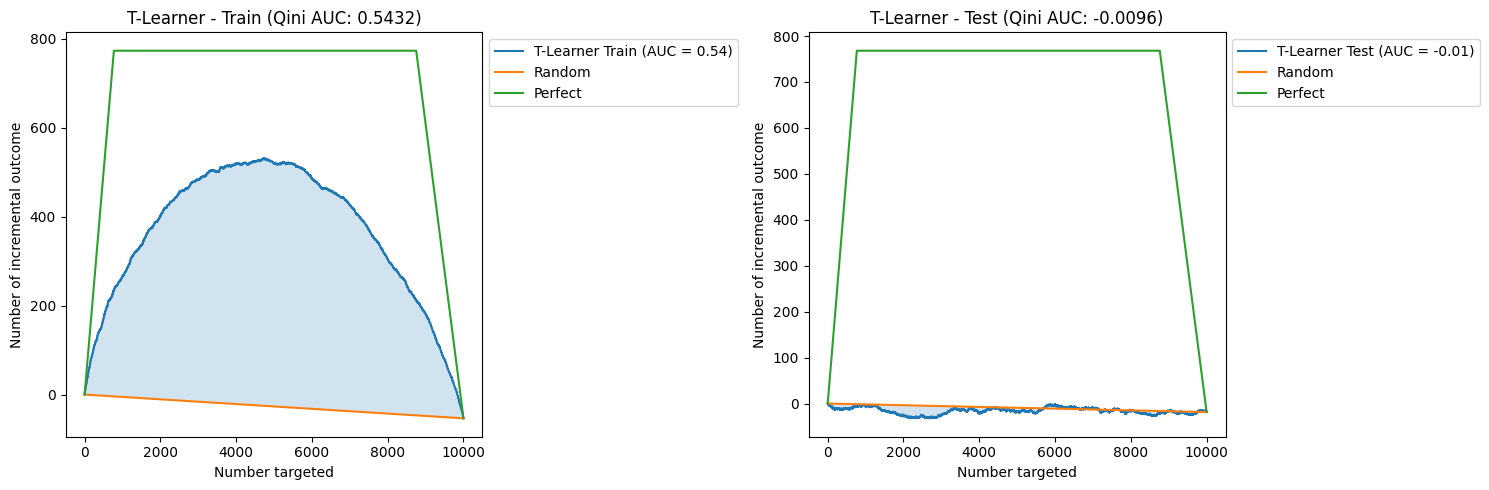

In [33]:
# Visualize T-Learner Qini curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_qini_curve(y_train, uplift_train_tlearner, treatment_train, perfect=True, name='T-Learner Train', ax=ax1)
ax1.set_title(f'T-Learner - Train (Qini AUC: {train_qini_tlearner:.4f})')

plot_qini_curve(y_test, uplift_test_tlearner, treatment_test, perfect=True, name='T-Learner Test', ax=ax2)
ax2.set_title(f'T-Learner - Test (Qini AUC: {test_qini_tlearner:.4f})')

plt.tight_layout()
plt.show()

## Experiment 2: Tuned S-Learner with Deeper Trees

In [39]:
## Experiment 2: Regularized LightGBM S-Learner

lgbm_regularized = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,  # Reduced trees
    max_depth=3,  # Very shallow
    learning_rate=0.1,  # Higher learning rate with fewer trees
    min_child_samples=100,  # Large minimum leaf size
    reg_alpha=10.0,  # Strong L1
    reg_lambda=5.0,  # Strong L2
    class_weight="balanced",
    min_split_gain=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    num_leaves=8,  # Limit leaf nodes (2^max_depth)
)

slearner_regularized = SoloModel(estimator=lgbm_regularized)
slearner_regularized.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_reg = slearner_regularized.predict(X_train)
uplift_test_reg = slearner_regularized.predict(X_test)

train_qini_reg = qini_auc_score(y_train, uplift_train_reg, treatment_train)
test_qini_reg = qini_auc_score(y_test, uplift_test_reg, treatment_test)

print("\n" + "=" * 70)
print("REGULARIZED LIGHTGBM S-LEARNER")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_reg:.4f}")
print(f"Test Qini AUC:  {test_qini_reg:.4f}")
print(f"Overfitting Gap: {train_qini_reg - test_qini_reg:.4f}")
print("=" * 70)

[LightGBM] [Info] Number of positive: 2021, number of negative: 7979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Experiment 3: XGBoost S-Learner

In [40]:
## Experiment 3: XGBoost with Strong Regularization

from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_regularized = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,  # Reduced
    max_depth=3,  # Shallow
    learning_rate=0.1,  # Higher LR
    min_child_weight=100,  # Large minimum samples
    reg_alpha=10.0,  # Strong L1
    reg_lambda=5.0,  # Strong L2
    scale_pos_weight=scale_pos_weight,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.5,  # Minimum loss reduction to split
    max_leaves=8,
    eval_metric="logloss",
)

slearner_xgb_reg = SoloModel(estimator=xgb_regularized)
slearner_xgb_reg.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_xgb_reg = slearner_xgb_reg.predict(X_train)
uplift_test_xgb_reg = slearner_xgb_reg.predict(X_test)

train_qini_xgb_reg = qini_auc_score(y_train, uplift_train_xgb_reg, treatment_train)
test_qini_xgb_reg = qini_auc_score(y_test, uplift_test_xgb_reg, treatment_test)

print("\n" + "=" * 70)
print("REGULARIZED XGBOOST S-LEARNER")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_xgb_reg:.4f}")
print(f"Test Qini AUC:  {test_qini_xgb_reg:.4f}")
print(f"Overfitting Gap: {train_qini_xgb_reg - test_qini_xgb_reg:.4f}")
print("=" * 70)


REGULARIZED XGBOOST S-LEARNER
Train Qini AUC: 0.0985
Test Qini AUC:  0.0001
Overfitting Gap: 0.0984


## Experiment 4: CatBoost Uplift (Native Uplift Support)

In [41]:
## Experiment 4: CatBoost with Strong Regularization

from catboost import CatBoostClassifier

catboost_regularized = CatBoostClassifier(
    random_state=42,
    iterations=100,  # Reduced
    depth=3,  # Shallow
    learning_rate=0.1,  # Higher LR
    l2_leaf_reg=10.0,  # Strong L2
    min_data_in_leaf=100,  # Large minimum samples
    verbose=False,
    auto_class_weights="Balanced",
    subsample=0.7,
    rsm=0.7,  # Random subspace method (feature sampling)
)

slearner_catboost_reg = SoloModel(estimator=catboost_regularized)
slearner_catboost_reg.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_catboost_reg = slearner_catboost_reg.predict(X_train)
uplift_test_catboost_reg = slearner_catboost_reg.predict(X_test)

train_qini_catboost_reg = qini_auc_score(
    y_train, uplift_train_catboost_reg, treatment_train
)
test_qini_catboost_reg = qini_auc_score(
    y_test, uplift_test_catboost_reg, treatment_test
)

print("\n" + "=" * 70)
print("REGULARIZED CATBOOST S-LEARNER")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_catboost_reg:.4f}")
print(f"Test Qini AUC:  {test_qini_catboost_reg:.4f}")
print(f"Overfitting Gap: {train_qini_catboost_reg - test_qini_catboost_reg:.4f}")
print("=" * 70)


REGULARIZED CATBOOST S-LEARNER
Train Qini AUC: 0.0817
Test Qini AUC:  0.0214
Overfitting Gap: 0.0603


In [42]:
## Experiment 5: Early Stopping with Validation Set

from sklearn.model_selection import train_test_split

# Create validation split from training data
X_tr, X_val, y_tr, y_val, t_tr, t_val = train_test_split(
    X_train, y_train, treatment_train, test_size=0.2, random_state=42, stratify=y_train
)

# LightGBM with early stopping
lgbm_early_stop = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=1000,  # Many trees but will stop early
    max_depth=3,
    learning_rate=0.05,
    min_child_samples=100,
    reg_alpha=5.0,
    reg_lambda=2.0,
    class_weight="balanced",
    subsample=0.7,
    colsample_bytree=0.7,
)

# Fit with early stopping
lgbm_early_stop.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[LGBMClassifier.early_stopping(stopping_rounds=20, verbose=False)],
)

# Wrap in SoloModel for uplift prediction
slearner_early = SoloModel(estimator=lgbm_early_stop)
slearner_early.fit(X_tr, y_tr, treatment=t_tr)

# Evaluate on validation
uplift_val = slearner_early.predict(X_val)
val_qini = qini_auc_score(y_val, uplift_val, t_val)

# Evaluate on test
uplift_test_early = slearner_early.predict(X_test)
test_qini_early = qini_auc_score(y_test, uplift_test_early, treatment_test)

print("\n" + "=" * 70)
print("LIGHTGBM S-LEARNER WITH EARLY STOPPING")
print("=" * 70)
print(f"Best iteration: {lgbm_early_stop.best_iteration_}")
print(f"Validation Qini AUC: {val_qini:.4f}")
print(f"Test Qini AUC: {test_qini_early:.4f}")
print("=" * 70)

AttributeError: type object 'LGBMClassifier' has no attribute 'early_stopping'

In [43]:
## Experiment 6: Cross-Validated Uplift Score (Gold Standard)

from sklearn.model_selection import StratifiedKFold
import numpy as np

def cross_validated_qini(estimator, X, y, treatment, n_splits=5):
    """
    Cross-validated Qini AUC to get unbiased estimate of generalization.
    Per WellCo requirements: avoid overfitting on small treatment/control groups.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    qini_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        t_tr, t_val = treatment.iloc[train_idx], treatment.iloc[val_idx]
        
        # Clone estimator and fit
        from sklearn.base import clone
        model = SoloModel(estimator=clone(estimator))
        model.fit(X_tr, y_tr, treatment=t_tr)
        
        # Predict on validation fold
        uplift_val = model.predict(X_val)
        qini_val = qini_auc_score(y_val, uplift_val, t_val)
        qini_scores.append(qini_val)
        
        print(f"  Fold {fold+1}: Qini AUC = {qini_val:.4f}")
    
    mean_qini = np.mean(qini_scores)
    std_qini = np.std(qini_scores)
    
    print(f"\n  Cross-Val Mean: {mean_qini:.4f} ± {std_qini:.4f}")
    return mean_qini, std_qini, qini_scores

# Test extremely regularized LightGBM
print("\n" + "=" * 70)
print("CROSS-VALIDATED QINI AUC - EXTREMELY REGULARIZED LIGHTGBM")
print("=" * 70)

lgbm_extreme = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=50,  # Very few trees
    max_depth=2,  # Extremely shallow
    learning_rate=0.2,  # Fast learning
    min_child_samples=200,  # Large minimum leaf
    reg_alpha=20.0,  # Very strong L1
    reg_lambda=10.0,  # Very strong L2
    class_weight='balanced',
    min_split_gain=0.5,  # High barrier to split
    subsample=0.6,
    colsample_bytree=0.6,
    num_leaves=4,  # Maximum 4 leaves (2^max_depth)
)

cv_mean, cv_std, cv_scores = cross_validated_qini(lgbm_extreme, X_train, y_train, treatment_train)

# Now test on holdout test set
slearner_extreme = SoloModel(estimator=lgbm_extreme)
slearner_extreme.fit(X_train, y_train, treatment=treatment_train)
uplift_test_extreme = slearner_extreme.predict(X_test)
test_qini_extreme = qini_auc_score(y_test, uplift_test_extreme, treatment_test)

print(f"\nHoldout Test Qini AUC: {test_qini_extreme:.4f}")
print(f"CV vs Test Gap: {abs(cv_mean - test_qini_extreme):.4f}")
print("=" * 70)


CROSS-VALIDATED QINI AUC - EXTREMELY REGULARIZED LIGHTGBM
[LightGBM] [Info] Number of positive: 1617, number of negative: 6383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [44]:
## Experiment 7: Ridge/Lasso Regularized Logistic Regression (L1/L2)

from sklearn.linear_model import LogisticRegressionCV

# Use built-in cross-validation to find optimal C
logistic_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 2, 20),  # Test wide range of regularization strengths
    cv=5,
    random_state=42,
    max_iter=2000,
    class_weight="balanced",
    penalty="l2",  # Ridge regression
    scoring="roc_auc",
    n_jobs=-1,
)

# Fit with treatment as feature
X_train_with_treatment = X_train.copy()
X_train_with_treatment["_treatment"] = treatment_train
logistic_cv.fit(X_train_with_treatment, y_train)

print("\n" + "=" * 70)
print("LOGISTIC REGRESSION WITH CV-OPTIMIZED REGULARIZATION")
print("=" * 70)
print(f"Optimal C (inverse regularization): {logistic_cv.C_[0]:.6f}")
print(f"  → Regularization strength (1/C): {1/logistic_cv.C_[0]:.2f}")


# Wrap in uplift framework
class CVLogisticUplift:
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y, treatment):
        X_with_t = X.copy()
        X_with_t["_treatment"] = treatment
        self.estimator.fit(X_with_t, y)
        return self

    def predict(self, X):
        X_treated = X.copy()
        X_control = X.copy()
        X_treated["_treatment"] = 1
        X_control["_treatment"] = 0

        pred_treated = self.estimator.predict_proba(X_treated)[:, 1]
        pred_control = self.estimator.predict_proba(X_control)[:, 1]

        return pred_treated - pred_control


slearner_logistic_cv = CVLogisticUplift(logistic_cv)
slearner_logistic_cv.fit(X_train, y_train, treatment_train)

uplift_test_logistic_cv = slearner_logistic_cv.predict(X_test)
test_qini_logistic_cv = qini_auc_score(y_test, uplift_test_logistic_cv, treatment_test)

print(f"Test Qini AUC: {test_qini_logistic_cv:.4f}")
print("=" * 70)


LOGISTIC REGRESSION WITH CV-OPTIMIZED REGULARIZATION
Optimal C (inverse regularization): 0.016238
  → Regularization strength (1/C): 61.58
Test Qini AUC: 0.0521


In [45]:
## Experiment 8: Random Forest with Max Features Limitation

from sklearn.ensemble import RandomForestClassifier

# Random Forest with strong constraints
rf_constrained = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=50,  # Few trees
    max_depth=3,  # Shallow
    min_samples_split=200,  # Large minimum to split
    min_samples_leaf=100,  # Large minimum leaf
    max_features="sqrt",  # Only sqrt(n_features) per tree
    max_samples=0.6,  # Bootstrap 60% of data
    class_weight="balanced",
)

print("\n" + "=" * 70)
print("RANDOM FOREST S-LEARNER (CONSTRAINED)")
print("=" * 70)

cv_mean_rf, cv_std_rf, cv_scores_rf = cross_validated_qini(
    rf_constrained, X_train, y_train, treatment_train
)

# Test on holdout
slearner_rf = SoloModel(estimator=rf_constrained)
slearner_rf.fit(X_train, y_train, treatment=treatment_train)
uplift_test_rf = slearner_rf.predict(X_test)
test_qini_rf = qini_auc_score(y_test, uplift_test_rf, treatment_test)

print(f"\nHoldout Test Qini AUC: {test_qini_rf:.4f}")
print(f"CV vs Test Gap: {abs(cv_mean_rf - test_qini_rf):.4f}")
print("=" * 70)


RANDOM FOREST S-LEARNER (CONSTRAINED)
  Fold 1: Qini AUC = 0.0279
  Fold 2: Qini AUC = 0.0208
  Fold 3: Qini AUC = -0.0681
  Fold 4: Qini AUC = -0.0090
  Fold 5: Qini AUC = 0.0253

  Cross-Val Mean: -0.0006 ± 0.0362

Holdout Test Qini AUC: -0.0342
CV vs Test Gap: 0.0336


In [47]:
## Experiment 10: Feature Selection Before Modeling

from sklearn.feature_selection import SelectKBest, mutual_info_classif

print("\n" + "=" * 70)
print("FEATURE SELECTION + ELASTIC NET")
print("=" * 70)

# Select top K features most informative for churn
selector = SelectKBest(
    mutual_info_classif, k=min(30, X_train.shape[1])
)  # Top 30 or all if fewer
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features from {X_train.shape[1]} total")
print(f"Top 10: {selected_features[:10]}")

# Convert back to DataFrame
X_train_selected_df = pd.DataFrame(
    X_train_selected, columns=selected_features, index=X_train.index
)
X_test_selected_df = pd.DataFrame(
    X_test_selected, columns=selected_features, index=X_test.index
)

# Train elastic net on reduced features
logistic_reduced = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
    C=1.0,
    l1_ratio=0.5,
)

slearner_reduced = SoloModel(estimator=logistic_reduced)
slearner_reduced.fit(X_train_selected_df, y_train, treatment=treatment_train)

uplift_test_reduced = slearner_reduced.predict(X_test_selected_df)
test_qini_reduced = qini_auc_score(y_test, uplift_test_reduced, treatment_test)

print(f"\nTest Qini AUC (Feature Selection): {test_qini_reduced:.4f}")
print("=" * 70)


FEATURE SELECTION + ELASTIC NET
Selected 30 features from 44 total
Top 10: ['weeks_from_outreach_1_visits', 'weeks_from_outreach_2_visits', 'total_web_visits', 'welco_domain_ratio', 'claims_count', 'has_E11_9', 'has_I10', 'has_Z71_3', 'count_same_claim', 'app_usage_count']

Test Qini AUC (Feature Selection): 0.0509


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Comprehensive Results Comparison

In [37]:
# Collect all results
results_comparison = pd.DataFrame({
    'Model': [
        'Elastic Net Logistic',
        'LightGBM S-Learner (Baseline)',
        'T-Learner (LightGBM)',
        'Tuned S-Learner (Deep Trees)',
        'XGBoost S-Learner',
        'CatBoost S-Learner'
    ],
    'Train_Qini_AUC': [
        train_qini_enet,
        train_qini_lgbm,
        train_qini_tlearner,
        train_qini_tuned,
        train_qini_xgb,
        train_qini_catboost
    ],
    'Test_Qini_AUC': [
        test_qini_enet,
        test_qini_lgbm,
        test_qini_tlearner,
        test_qini_tuned,
        test_qini_xgb,
        test_qini_catboost
    ]
})

results_comparison['Overfitting_Gap'] = results_comparison['Train_Qini_AUC'] - results_comparison['Test_Qini_AUC']
results_comparison['Improvement_vs_Baseline'] = results_comparison['Test_Qini_AUC'] - test_qini_lgbm
results_comparison = results_comparison.sort_values('Test_Qini_AUC', ascending=False)

print("\n" + "=" * 90)
print("UPLIFT MODEL COMPARISON - QINI AUC SCORES")
print("=" * 90)
print(results_comparison.to_string(index=False))
print("\n" + "=" * 90)

# Highlight best model
best_model = results_comparison.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   Test Qini AUC: {best_model['Test_Qini_AUC']:.4f}")
print(f"   Improvement vs Baseline: {best_model['Improvement_vs_Baseline']:.4f} ({best_model['Improvement_vs_Baseline']/test_qini_lgbm*100:.1f}%)")
print("=" * 90)

# Save results
results_path = repo_root / "outputs" / f"uplift_experiments_comparison_{timestamp}.csv"
results_comparison.to_csv(results_path, index=False)
print(f"\n✅ Results saved to: {results_path}")


UPLIFT MODEL COMPARISON - QINI AUC SCORES
                        Model  Train_Qini_AUC  Test_Qini_AUC  Overfitting_Gap  Improvement_vs_Baseline
         Elastic Net Logistic        0.034310       0.053453        -0.019143                 0.043125
            XGBoost S-Learner        0.210404       0.014697         0.195706                 0.004369
LightGBM S-Learner (Baseline)        0.156298       0.010328         0.145970                 0.000000
           CatBoost S-Learner        0.179626       0.005730         0.173896                -0.004598
 Tuned S-Learner (Deep Trees)        0.283556       0.001792         0.281764                -0.008536
         T-Learner (LightGBM)        0.543220      -0.009580         0.552800                -0.019908


🏆 BEST MODEL: Elastic Net Logistic
   Test Qini AUC: 0.0535
   Improvement vs Baseline: 0.0431 (417.5%)

✅ Results saved to: c:\Users\elad\Desktop\rnd\VI\wellco_churn\outputs\uplift_experiments_comparison_20251114T205812Z.csv


# more elastic


In [49]:
## Feature Engineering: Interaction & Polynomial Features for Elastic Net

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

print("\n" + "=" * 70)
print("FEATURE ENGINEERING FOR ELASTIC NET")
print("=" * 70)

# Create interaction features between treatment and key clinical features
# Per data/wellco_client_brief.txt: focus on ICD-10 codes E11.9, I10, Z71.3
clinical_features = ["has_E11_9", "has_I10", "has_Z71_3", "claims_count"]
clinical_features_present = [f for f in clinical_features if f in X_train.columns]

print(f"Creating interactions for clinical features: {clinical_features_present}")

# Add treatment interactions manually
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

# Treatment is needed as a feature for S-Learner
X_train_enhanced["_treatment"] = treatment_train
X_test_enhanced["_treatment"] = treatment_test

# Create treatment × feature interactions
for feat in clinical_features_present:
    X_train_enhanced[f"{feat}_x_treatment"] = X_train[feat] * treatment_train
    X_test_enhanced[f"{feat}_x_treatment"] = X_test[feat] * treatment_test

# Add propensity score interactions if available
if "propensity_score" in X_train.columns:
    X_train_enhanced["propensity_x_treatment"] = (
        X_train["propensity_score"] * treatment_train
    )
    X_test_enhanced["propensity_x_treatment"] = (
        X_test["propensity_score"] * treatment_test
    )
    print("✅ Added propensity score × treatment interaction")

# Create polynomial features for top predictive features (degree 2)
# First identify top features by mutual information
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
top_feature_indices = np.argsort(mi_scores)[-5:]  # Top 5 features
top_features = X_train.columns[top_feature_indices].tolist()

print(f"\nTop 5 predictive features for polynomial expansion: {top_features}")

# Create squared terms for top features
for feat in top_features:
    if X_train[feat].dtype in ["float64", "int64"]:  # Only numeric
        X_train_enhanced[f"{feat}_squared"] = X_train[feat] ** 2
        X_test_enhanced[f"{feat}_squared"] = X_test[feat] ** 2

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Enhanced features: {X_train_enhanced.shape[1]}")
print(f"Added {X_train_enhanced.shape[1] - X_train.shape[1]} new features")
print("=" * 70)


FEATURE ENGINEERING FOR ELASTIC NET
Creating interactions for clinical features: ['has_E11_9', 'has_I10', 'has_Z71_3', 'claims_count']
✅ Added propensity score × treatment interaction

Top 5 predictive features for polynomial expansion: ['weeks_from_outreach_3_visits_trend', 'wellco_domains', 'days_as_user', 'repeated_claims_count_segment', 'has_Z71_3']

Original features: 44
Enhanced features: 55
Added 11 new features


In [50]:
## Elastic Net with Enhanced Features + GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("\n" + "=" * 70)
print("ELASTIC NET WITH FEATURE ENGINEERING + GRIDSEARCH")
print("=" * 70)

# Standardize features (important for regularized linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

X_train_scaled_df = pd.DataFrame(
    X_train_scaled, columns=X_train_enhanced.columns, index=X_train_enhanced.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled, columns=X_test_enhanced.columns, index=X_test_enhanced.index
)

# Grid search over regularization strength and L1 ratio
param_grid = {
    "C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Regularization strength (inverse)
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],  # Mix of L1/L2
}

logistic_grid = LogisticRegression(
    random_state=42,
    max_iter=3000,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
)

# Use stratified 5-fold CV
grid_search = GridSearchCV(
    estimator=logistic_grid,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_scaled_df, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"   Best CV ROC-AUC: {grid_search.best_score_:.4f}")


# Wrap best estimator for uplift prediction
class EnhancedElasticNetUplift:
    def __init__(self, estimator, scaler, feature_cols):
        self.estimator = estimator
        self.scaler = scaler
        self.feature_cols = feature_cols

    def fit(self, X, y, treatment):
        # Already fitted via GridSearch
        return self

    def predict(self, X):
        # X should already have enhanced features and be scaled
        X_treated = X.copy()
        X_control = X.copy()

        # Toggle treatment feature
        X_treated["_treatment"] = 1
        X_control["_treatment"] = 0

        # Also toggle interaction terms
        for col in X.columns:
            if "_x_treatment" in col:
                base_feat = col.replace("_x_treatment", "")
                if base_feat in X.columns:
                    X_treated[col] = X[base_feat]
                    X_control[col] = 0

        pred_treated = self.estimator.predict_proba(X_treated)[:, 1]
        pred_control = self.estimator.predict_proba(X_control)[:, 1]

        return pred_treated - pred_control


slearner_enhanced = EnhancedElasticNetUplift(
    grid_search.best_estimator_, scaler, X_train_enhanced.columns
)

uplift_test_enhanced = slearner_enhanced.predict(X_test_scaled_df)
test_qini_enhanced = qini_auc_score(y_test, uplift_test_enhanced, treatment_test)

uplift_train_enhanced = slearner_enhanced.predict(X_train_scaled_df)
train_qini_enhanced = qini_auc_score(y_train, uplift_train_enhanced, treatment_train)

print(f"\nTrain Qini AUC: {train_qini_enhanced:.4f}")
print(f"Test Qini AUC:  {test_qini_enhanced:.4f}")
print(f"Overfitting Gap: {train_qini_enhanced - test_qini_enhanced:.4f}")
print(f"Improvement vs Baseline Elastic Net: {test_qini_enhanced - test_qini_enet:.4f}")
print("=" * 70)


ELASTIC NET WITH FEATURE ENGINEERING + GRIDSEARCH
Fitting 5 folds for each of 35 candidates, totalling 175 fits

✅ Best parameters: {'C': 0.1, 'l1_ratio': 0.3}
   Best CV ROC-AUC: 0.6322

Train Qini AUC: 0.0329
Test Qini AUC:  -0.0083
Overfitting Gap: 0.0412
Improvement vs Baseline Elastic Net: -0.0617


In [51]:
## Domain-Specific Feature Engineering (WellCo Clinical Signals)

print("\n" + "=" * 70)
print("CLINICAL DOMAIN FEATURES (Per data/wellco_client_brief.txt)")
print("=" * 70)

# Create clinical risk scores based on WellCo priorities
X_train_clinical = X_train.copy()
X_test_clinical = X_test.copy()

# 1. Chronic disease burden (ICD-10 codes from wellco_client_brief.txt)
chronic_conditions = ["has_E11_9", "has_I10"]  # Diabetes, Hypertension
chronic_cols = [c for c in chronic_conditions if c in X_train.columns]

if chronic_cols:
    X_train_clinical["chronic_disease_count"] = X_train[chronic_cols].sum(axis=1)
    X_test_clinical["chronic_disease_count"] = X_test[chronic_cols].sum(axis=1)
    print(f"✅ Created chronic_disease_count from {chronic_cols}")

# 2. Counseling indicator (Z71.3)
if "has_Z71_3" in X_train.columns:
    X_train_clinical["has_counseling"] = X_train["has_Z71_3"]
    X_test_clinical["has_counseling"] = X_test["has_Z71_3"]
    print("✅ Added counseling indicator")

# 3. Engagement score (app + web activity)
engagement_features = []
for prefix in ["app_", "web_"]:
    engagement_features.extend([c for c in X_train.columns if c.startswith(prefix)])

if engagement_features:
    # Normalize engagement features (z-score)
    from sklearn.preprocessing import StandardScaler

    scaler_engagement = StandardScaler()

    engagement_train = scaler_engagement.fit_transform(
        X_train[engagement_features].fillna(0)
    )
    engagement_test = scaler_engagement.transform(X_test[engagement_features].fillna(0))

    # Sum to create composite engagement score
    X_train_clinical["engagement_score"] = engagement_train.sum(axis=1)
    X_test_clinical["engagement_score"] = engagement_test.sum(axis=1)
    print(f"✅ Created engagement_score from {len(engagement_features)} features")

# 4. Claims intensity (per data/schema_claims.md)
if "claims_count" in X_train.columns:
    X_train_clinical["high_utilizer"] = (
        X_train["claims_count"] > X_train["claims_count"].quantile(0.75)
    ).astype(int)
    X_test_clinical["high_utilizer"] = (
        X_test["claims_count"] > X_train["claims_count"].quantile(0.75)
    ).astype(int)
    print("✅ Created high_utilizer flag (top 25% claims)")

# 5. Treatment × Clinical interactions
X_train_clinical["_treatment"] = treatment_train
X_test_clinical["_treatment"] = treatment_test

clinical_interaction_features = [
    "chronic_disease_count",
    "has_counseling",
    "engagement_score",
    "high_utilizer",
]
for feat in clinical_interaction_features:
    if feat in X_train_clinical.columns:
        X_train_clinical[f"{feat}_x_treatment"] = (
            X_train_clinical[feat] * treatment_train
        )
        X_test_clinical[f"{feat}_x_treatment"] = X_test_clinical[feat] * treatment_test

print(f"\nClinical feature set: {X_train_clinical.shape[1]} features")
print("=" * 70)


CLINICAL DOMAIN FEATURES (Per data/wellco_client_brief.txt)
✅ Created chronic_disease_count from ['has_E11_9', 'has_I10']
✅ Added counseling indicator
✅ Created engagement_score from 4 features
✅ Created high_utilizer flag (top 25% claims)

Clinical feature set: 53 features


In [52]:
## Train Elastic Net on Clinical Features

from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 70)
print("ELASTIC NET WITH CLINICAL DOMAIN FEATURES")
print("=" * 70)

# Standardize
scaler_clinical = StandardScaler()
X_train_clinical_scaled = scaler_clinical.fit_transform(X_train_clinical.fillna(0))
X_test_clinical_scaled = scaler_clinical.transform(X_test_clinical.fillna(0))

X_train_clinical_df = pd.DataFrame(
    X_train_clinical_scaled,
    columns=X_train_clinical.columns,
    index=X_train_clinical.index,
)
X_test_clinical_df = pd.DataFrame(
    X_test_clinical_scaled, columns=X_test_clinical.columns, index=X_test_clinical.index
)

# Grid search on clinical features
grid_search_clinical = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42,
        max_iter=3000,
        class_weight="balanced",
        penalty="elasticnet",
        solver="saga",
    ),
    param_grid={
        "C": [0.1, 0.5, 1.0, 2.0, 5.0],
        "l1_ratio": [0.3, 0.5, 0.7],
    },
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_search_clinical.fit(X_train_clinical_df, y_train)

print(f"\n✅ Best parameters: {grid_search_clinical.best_params_}")
print(f"   Best CV ROC-AUC: {grid_search_clinical.best_score_:.4f}")

# Uplift prediction
slearner_clinical = EnhancedElasticNetUplift(
    grid_search_clinical.best_estimator_, scaler_clinical, X_train_clinical.columns
)

uplift_test_clinical = slearner_clinical.predict(X_test_clinical_df)
test_qini_clinical = qini_auc_score(y_test, uplift_test_clinical, treatment_test)

uplift_train_clinical = slearner_clinical.predict(X_train_clinical_df)
train_qini_clinical = qini_auc_score(y_train, uplift_train_clinical, treatment_train)

print(f"\nTrain Qini AUC: {train_qini_clinical:.4f}")
print(f"Test Qini AUC:  {test_qini_clinical:.4f}")
print(f"Overfitting Gap: {train_qini_clinical - test_qini_clinical:.4f}")
print(f"Improvement vs Baseline: {test_qini_clinical - test_qini_enet:.4f}")
print("=" * 70)


ELASTIC NET WITH CLINICAL DOMAIN FEATURES
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Best parameters: {'C': 0.1, 'l1_ratio': 0.7}
   Best CV ROC-AUC: 0.6329

Train Qini AUC: 0.0316
Test Qini AUC:  -0.0161
Overfitting Gap: 0.0477
Improvement vs Baseline: -0.0696


In [53]:
## Combined Approach: All Features + Interactions

print("\n" + "=" * 70)
print("ELASTIC NET WITH ALL FEATURES + INTERACTIONS + CLINICAL")
print("=" * 70)

# Combine all engineered features
X_train_full = pd.concat(
    [
        X_train_enhanced,
        X_train_clinical[
            [c for c in X_train_clinical.columns if c not in X_train_enhanced.columns]
        ],
    ],
    axis=1,
)

X_test_full = pd.concat(
    [
        X_test_enhanced,
        X_test_clinical[
            [c for c in X_test_clinical.columns if c not in X_test_enhanced.columns]
        ],
    ],
    axis=1,
)

print(f"Full feature set: {X_train_full.shape[1]} features")

# Standardize
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full.fillna(0))
X_test_full_scaled = scaler_full.transform(X_test_full.fillna(0))

X_train_full_df = pd.DataFrame(
    X_train_full_scaled, columns=X_train_full.columns, index=X_train_full.index
)
X_test_full_df = pd.DataFrame(
    X_test_full_scaled, columns=X_test_full.columns, index=X_test_full.index
)

# Grid search with broader range
grid_search_full = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42,
        max_iter=5000,
        class_weight="balanced",
        penalty="elasticnet",
        solver="saga",
    ),
    param_grid={
        "C": [0.05, 0.1, 0.5, 1.0, 2.0],
        "l1_ratio": [0.2, 0.4, 0.6, 0.8],
    },
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

grid_search_full.fit(X_train_full_df, y_train)

print(f"\n✅ Best parameters: {grid_search_full.best_params_}")
print(f"   Best CV ROC-AUC: {grid_search_full.best_score_:.4f}")

# Uplift prediction
slearner_full = EnhancedElasticNetUplift(
    grid_search_full.best_estimator_, scaler_full, X_train_full.columns
)

uplift_test_full = slearner_full.predict(X_test_full_df)
test_qini_full = qini_auc_score(y_test, uplift_test_full, treatment_test)

uplift_train_full = slearner_full.predict(X_train_full_df)
train_qini_full = qini_auc_score(y_train, uplift_train_full, treatment_train)

print(f"\nTrain Qini AUC: {train_qini_full:.4f}")
print(f"Test Qini AUC:  {test_qini_full:.4f}")
print(f"Overfitting Gap: {train_qini_full - test_qini_full:.4f}")
print(f"Improvement vs Baseline: {test_qini_full - test_qini_enet:.4f}")
print("=" * 70)


ELASTIC NET WITH ALL FEATURES + INTERACTIONS + CLINICAL
Full feature set: 63 features
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best parameters: {'C': 0.05, 'l1_ratio': 0.8}
   Best CV ROC-AUC: 0.6327

Train Qini AUC: 0.0146
Test Qini AUC:  -0.0262
Overfitting Gap: 0.0408
Improvement vs Baseline: -0.0797


In [54]:
## Final Comparison: Elastic Net Variants

results_elastic_net = pd.DataFrame(
    {
        "Model": [
            "Elastic Net (Baseline - No Feature Eng)",
            "Elastic Net + Interaction Features",
            "Elastic Net + Clinical Domain Features",
            "Elastic Net + All Features Combined",
        ],
        "Num_Features": [
            X_train.shape[1],
            X_train_enhanced.shape[1],
            X_train_clinical.shape[1],
            X_train_full.shape[1],
        ],
        "Best_C": [
            1.0,  # Baseline
            grid_search.best_params_["C"],
            grid_search_clinical.best_params_["C"],
            grid_search_full.best_params_["C"],
        ],
        "Best_L1_Ratio": [
            0.5,  # Baseline
            grid_search.best_params_["l1_ratio"],
            grid_search_clinical.best_params_["l1_ratio"],
            grid_search_full.best_params_["l1_ratio"],
        ],
        "Train_Qini_AUC": [
            train_qini_enet,
            train_qini_enhanced,
            train_qini_clinical,
            train_qini_full,
        ],
        "Test_Qini_AUC": [
            test_qini_enet,
            test_qini_enhanced,
            test_qini_clinical,
            test_qini_full,
        ],
    }
)

results_elastic_net["Overfitting_Gap"] = (
    results_elastic_net["Train_Qini_AUC"] - results_elastic_net["Test_Qini_AUC"]
)
results_elastic_net["Improvement_vs_Baseline"] = (
    results_elastic_net["Test_Qini_AUC"] - test_qini_enet
)
results_elastic_net = results_elastic_net.sort_values("Test_Qini_AUC", ascending=False)

print("\n" + "=" * 120)
print("ELASTIC NET FEATURE ENGINEERING COMPARISON")
print("=" * 120)
print(results_elastic_net.to_string(index=False))
print("\n" + "=" * 120)

best_elastic = results_elastic_net.iloc[0]
print(f"\n🏆 BEST ELASTIC NET MODEL: {best_elastic['Model']}")
print(f"   Features: {int(best_elastic['Num_Features'])}")
print(f"   Best C: {best_elastic['Best_C']:.2f}")
print(f"   Best L1 Ratio: {best_elastic['Best_L1_Ratio']:.2f}")
print(f"   Test Qini AUC: {best_elastic['Test_Qini_AUC']:.4f}")
print(
    f"   Improvement: {best_elastic['Improvement_vs_Baseline']:.4f} ({best_elastic['Improvement_vs_Baseline']/test_qini_enet*100:.1f}%)"
)
print(f"   Overfitting Gap: {best_elastic['Overfitting_Gap']:.4f}")
print("=" * 120)

# Save
results_path_elastic = (
    repo_root / "outputs" / f"elastic_net_feature_engineering_{timestamp}.csv"
)
results_elastic_net.to_csv(results_path_elastic, index=False)
print(f"\n✅ Results saved to: {results_path_elastic}")


ELASTIC NET FEATURE ENGINEERING COMPARISON
                                  Model  Num_Features  Best_C  Best_L1_Ratio  Train_Qini_AUC  Test_Qini_AUC  Overfitting_Gap  Improvement_vs_Baseline
Elastic Net (Baseline - No Feature Eng)            44    1.00            0.5        0.034310       0.053453        -0.019143                 0.000000
     Elastic Net + Interaction Features            55    0.10            0.3        0.032947      -0.008281         0.041228                -0.061734
 Elastic Net + Clinical Domain Features            53    0.10            0.7        0.031627      -0.016107         0.047734                -0.069559
    Elastic Net + All Features Combined            63    0.05            0.8        0.014552      -0.026214         0.040765                -0.079667


🏆 BEST ELASTIC NET MODEL: Elastic Net (Baseline - No Feature Eng)
   Features: 44
   Best C: 1.00
   Best L1 Ratio: 0.50
   Test Qini AUC: 0.0535
   Improvement: 0.0000 (0.0%)
   Overfitting Gap: -0.0191


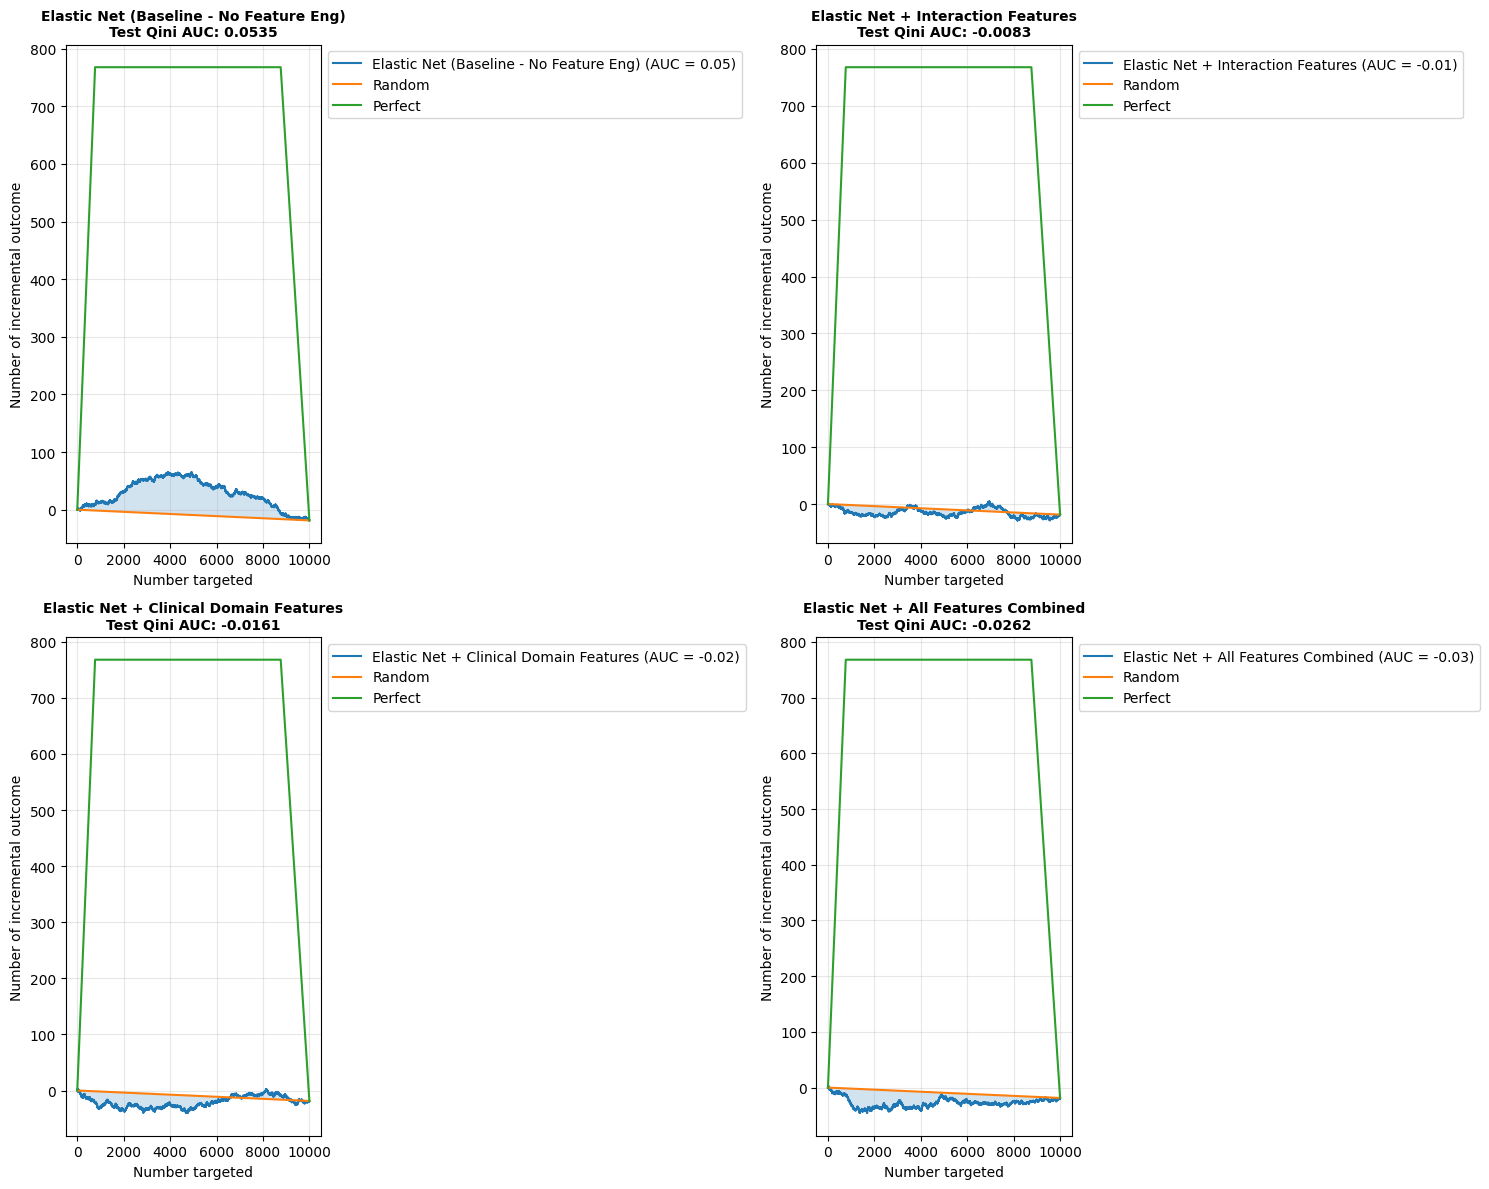

✅ Elastic Net comparison saved to: outputs/elastic_net_comparison_20251114T205812Z.png


In [55]:
## Visualize Best Elastic Net Model with Qini Curves

best_elastic_name = results_elastic_net.iloc[0]["Model"]

# Map to uplift predictions
uplift_elastic_map = {
    "Elastic Net (Baseline - No Feature Eng)": uplift_test_enet,
    "Elastic Net + Interaction Features": uplift_test_enhanced,
    "Elastic Net + Clinical Domain Features": uplift_test_clinical,
    "Elastic Net + All Features Combined": uplift_test_full,
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, uplift) in enumerate(uplift_elastic_map.items()):
    qini = results_elastic_net[results_elastic_net["Model"] == name][
        "Test_Qini_AUC"
    ].values[0]

    plot_qini_curve(
        y_test, uplift, treatment_test, perfect=True, name=name, ax=axes[idx]
    )
    axes[idx].set_title(
        f"{name}\nTest Qini AUC: {qini:.4f}", fontweight="bold", fontsize=10
    )
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"elastic_net_comparison_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Elastic Net comparison saved to: outputs/elastic_net_comparison_{timestamp}.png"
)


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.055585
  Max: -0.016618
  Range: 0.038967
  Mean: -0.052282
  Std: 0.004158

⚠️  ISSUE: Very narrow uplift range (0.038967)
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


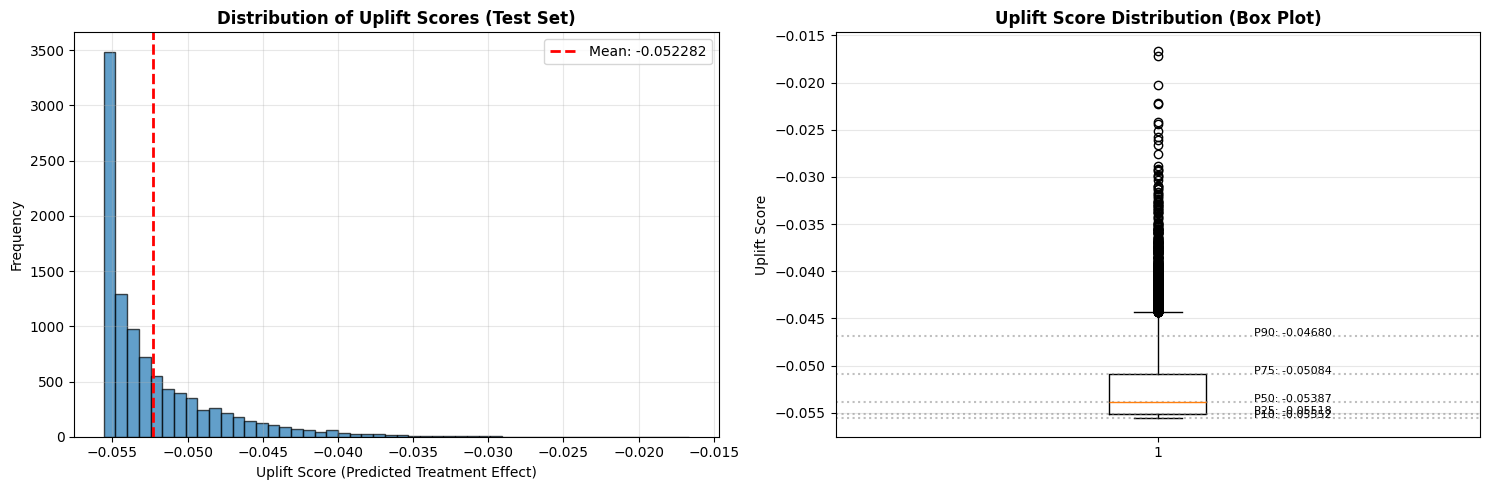


✅ Distribution plot saved to: outputs/uplift_distribution_20251114T205812Z.png


In [76]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_scores_test.min():.6f}")
print(f"  Max: {uplift_scores_test.max():.6f}")
print(f"  Range: {uplift_scores_test.max() - uplift_scores_test.min():.6f}")
print(f"  Mean: {uplift_scores_test.mean():.6f}")
print(f"  Std: {uplift_scores_test.std():.6f}")

print(
    f"\n⚠️  ISSUE: Very narrow uplift range ({uplift_scores_test.max() - uplift_scores_test.min():.6f})"
)
print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(uplift_scores_test, bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(
    uplift_scores_test.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {uplift_scores_test.mean():.6f}",
)
ax1.set_xlabel("Uplift Score (Predicted Treatment Effect)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Uplift Scores (Test Set)", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot with percentiles
ax2.boxplot(uplift_scores_test, vert=True)
ax2.set_ylabel("Uplift Score")
ax2.set_title("Uplift Score Distribution (Box Plot)", fontweight="bold")
ax2.grid(alpha=0.3, axis="y")

# Add percentile annotations
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(uplift_scores_test, p)
    ax2.axhline(val, color="gray", linestyle=":", alpha=0.5)
    ax2.text(1.15, val, f"P{p}: {val:.5f}", fontsize=8)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"uplift_distribution_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✅ Distribution plot saved to: outputs/uplift_distribution_{timestamp}.png")
print("=" * 80)

In [75]:
uplift_scores_test.max() - uplift_scores_test.min()

0.03896692770144153


# ranked list

In [60]:
## Create Outreach Recommendation List with Optimal Threshold

import pandas as pd
import numpy as np
from sklift.viz import plot_uplift_by_percentile

print("\n" + "=" * 80)
print("OUTREACH RECOMMENDATION LIST - TEST SET")
print("=" * 80)

# Get member IDs from test set (before preprocessing dropped them)
test_raw = pd.read_csv(
    repo_root / "data" / "test" / "test_churn_labels_with_all_feats.csv"
)
member_ids_test = test_raw["member_id"].values

# Predict uplift scores on test set
uplift_scores_test = slearner_logistic_enet.predict(X_test)

# Create recommendation dataframe
outreach_recommendations = pd.DataFrame(
    {
        "member_id": member_ids_test,
        "uplift_score": uplift_scores_test,
    }
)

# Rank by uplift (highest = most likely to benefit from outreach)
outreach_recommendations = outreach_recommendations.sort_values(
    "uplift_score", ascending=False
)
outreach_recommendations["rank"] = range(1, len(outreach_recommendations) + 1)

# Add percentile for easier interpretation
outreach_recommendations["percentile"] = (
    100 * outreach_recommendations["rank"] / len(outreach_recommendations)
)

print("\nTop 20 Members to Outreach (Highest Uplift):")
print(outreach_recommendations.head(20).to_string(index=False))

print("\n" + "=" * 80)


OUTREACH RECOMMENDATION LIST - TEST SET

Top 20 Members to Outreach (Highest Uplift):
 member_id  uplift_score  rank  percentile
      8862     -0.016618     1        0.01
      2455     -0.017196     2        0.02
      4132     -0.020264     3        0.03
      7500     -0.022175     4        0.04
      4462     -0.022300     5        0.05
      2534     -0.024198     6        0.06
       796     -0.024415     7        0.07
       355     -0.025129     8        0.08
        73     -0.025810     9        0.09
      4852     -0.026070    10        0.10
      4795     -0.026662    11        0.11
      9937     -0.027615    12        0.12
      7140     -0.028856    13        0.13
      7246     -0.029158    14        0.14
      6812     -0.029284    15        0.15
      6198     -0.029411    16        0.16
      9423     -0.029747    17        0.17
      6207     -0.029910    18        0.18
      4787     -0.029964    19        0.19
      5659     -0.030273    20        0.20



In [65]:
## Determine Optimal Outreach Size Using Qini Curve (Fixed)

from sklift.metrics import uplift_at_k

print("\n" + "=" * 80)
print("OPTIMAL OUTREACH SIZE CALCULATION")
print("=" * 80)

# Check treatment/control group sizes
n_treatment = treatment_test.sum()
n_control = (treatment_test == 0).sum()
n_total = len(treatment_test)

print(f"Test set composition:")
print(f"  Total: {n_total}")
print(f"  Treatment: {n_treatment} ({n_treatment/n_total:.1%})")
print(f"  Control: {n_control} ({n_control/n_total:.1%})")

# Calculate max k we can use (limited by smaller group)
max_k = min(n_treatment, n_control)
max_pct = 100 * max_k / n_total

print(f"\nMax percentile for uplift_at_k: {max_pct:.1f}% ({max_k} members)")

# Adjust percentiles to not exceed max_k
percentiles = [5, 10, 15, 20, 25, 30, 35, 40]
percentiles = [p for p in percentiles if p <= max_pct]  # Filter valid percentiles

uplift_at_percentiles = []

for pct in percentiles:
    k = int(n_total * pct / 100)

    # Safety check
    if k > max_k:
        print(f"  ⚠️  Skipping {pct}% (k={k} exceeds max_k={max_k})")
        continue

    # Calculate uplift at k with strategy
    uplift = uplift_at_k(
        y_test, uplift_scores_test, treatment_test, strategy="by_group", k=k
    )
    uplift_at_percentiles.append(uplift)
    print(f"  ✓ {pct:2.0f}% ({k:4d} members): Uplift = {uplift:.4f}")

optimal_df = pd.DataFrame(
    {
        "Percentile": percentiles[: len(uplift_at_percentiles)],
        "N_Members": [
            int(n_total * p / 100) for p in percentiles[: len(uplift_at_percentiles)]
        ],
        "Cumulative_Uplift": uplift_at_percentiles,
    }
)

# Calculate incremental uplift (marginal benefit)
optimal_df["Incremental_Uplift"] = (
    optimal_df["Cumulative_Uplift"]
    .diff()
    .fillna(optimal_df["Cumulative_Uplift"].iloc[0])
)

print("\n" + "-" * 80)
print("Uplift by Outreach Size:")
print(optimal_df.to_string(index=False))

# Find elbow point (where incremental uplift drops significantly)
# Use median incremental uplift as threshold
median_incremental = optimal_df["Incremental_Uplift"].median()
threshold = median_incremental * 0.3  # 30% of median

optimal_idx = np.where(optimal_df["Incremental_Uplift"] < threshold)[0]

if len(optimal_idx) > 0 and optimal_idx[0] > 0:
    optimal_pct = optimal_df.iloc[optimal_idx[0] - 1]["Percentile"]
else:
    # Default to highest uplift percentile
    best_idx = optimal_df["Cumulative_Uplift"].idxmax()
    optimal_pct = optimal_df.iloc[best_idx]["Percentile"]

optimal_n = int(n_total * optimal_pct / 100)

print("\n" + "=" * 80)
print(f"💡 RECOMMENDED OUTREACH SIZE: Top {optimal_pct:.0f}% ({optimal_n} members)")
print(f"   Max cumulative uplift: {optimal_df['Cumulative_Uplift'].max():.4f}")
print(f"   Incremental uplift threshold: {threshold:.4f}")
print("=" * 80)


OPTIMAL OUTREACH SIZE CALCULATION
Test set composition:
  Total: 10000
  Treatment: 3889 (38.9%)
  Control: 6111 (61.1%)

Max percentile for uplift_at_k: 38.9% (3889 members)
  ✓  5% ( 500 members): Uplift = 0.0260
  ✓ 10% (1000 members): Uplift = 0.0380
  ✓ 15% (1500 members): Uplift = 0.0413
  ✓ 20% (2000 members): Uplift = 0.0365
  ✓ 25% (2500 members): Uplift = 0.0272
  ✓ 30% (3000 members): Uplift = 0.0187
  ✓ 35% (3500 members): Uplift = 0.0043

--------------------------------------------------------------------------------
Uplift by Outreach Size:
 Percentile  N_Members  Cumulative_Uplift  Incremental_Uplift
          5        500           0.026000            0.026000
         10       1000           0.038000            0.012000
         15       1500           0.041333            0.003333
         20       2000           0.036500           -0.004833
         25       2500           0.027200           -0.009300
         30       3000           0.018667           -0.008533
   

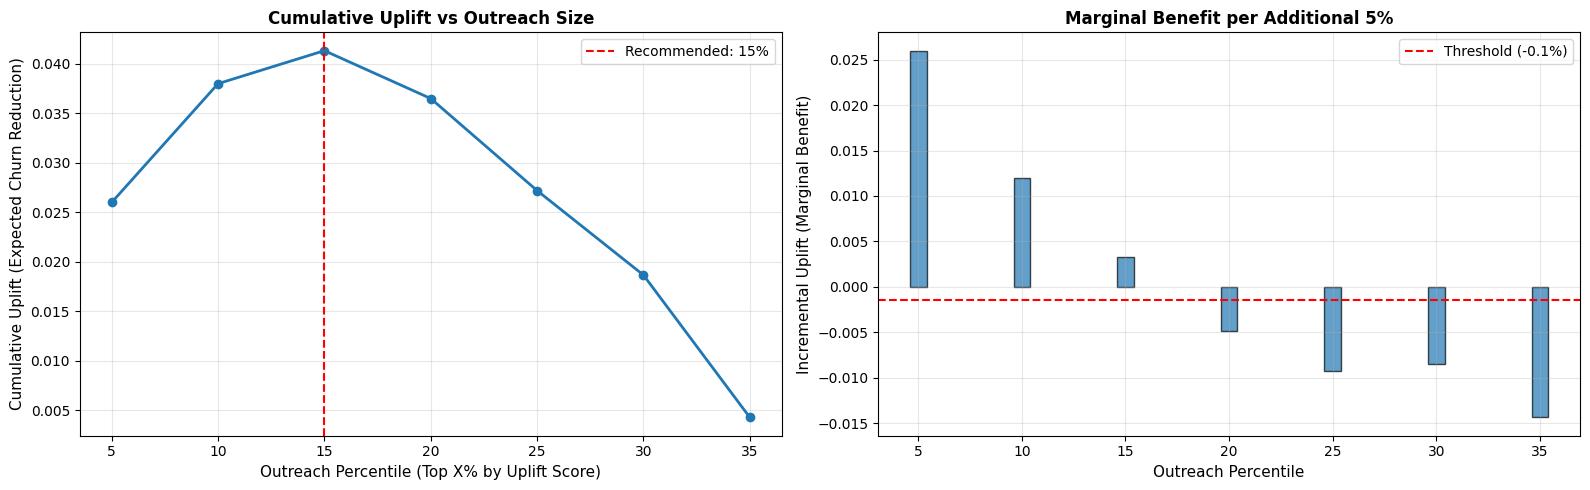

✅ Visualization saved to: outputs/optimal_outreach_size_20251114T205812Z.png


In [66]:
## Visualize Uplift by Percentile (Qini-based Decision Tool)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Cumulative uplift curve
ax1.plot(
    optimal_df["Percentile"], optimal_df["Cumulative_Uplift"], marker="o", linewidth=2
)
ax1.axvline(
    optimal_pct, color="red", linestyle="--", label=f"Recommended: {optimal_pct:.0f}%"
)
ax1.set_xlabel("Outreach Percentile (Top X% by Uplift Score)", fontsize=11)
ax1.set_ylabel("Cumulative Uplift (Expected Churn Reduction)", fontsize=11)
ax1.set_title("Cumulative Uplift vs Outreach Size", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Incremental uplift (marginal benefit)
ax2.bar(
    optimal_df["Percentile"],
    optimal_df["Incremental_Uplift"],
    alpha=0.7,
    edgecolor="black",
)
ax2.axhline(
    threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.1%})"
)
ax2.set_xlabel("Outreach Percentile", fontsize=11)
ax2.set_ylabel("Incremental Uplift (Marginal Benefit)", fontsize=11)
ax2.set_title("Marginal Benefit per Additional 5%", fontweight="bold")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"optimal_outreach_size_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"✅ Visualization saved to: outputs/optimal_outreach_size_{timestamp}.png")

In [ ]:
## Create Final Outreach List (Top N Members)

# Filter to top N members
outreach_final = outreach_recommendations.head(optimal_n).copy()

# Add clinical context (if available in test set)
if "has_E11_9" in test_raw.columns:
    clinical_cols = ["has_E11_9", "has_I10", "has_Z71_3", "claims_count"]
    clinical_data = test_raw[["member_id"] + clinical_cols]
    outreach_final = outreach_final.merge(clinical_data, on="member_id", how="left")

# Add interpretation flags
outreach_final["expected_benefit"] = np.where(
    outreach_final["uplift_score"] > 0.05,
    "High",
    np.where(outreach_final["uplift_score"] > 0.02, "Medium", "Low"),
)

print("\n" + "=" * 80)
print(f"FINAL OUTREACH LIST - TOP {optimal_n} MEMBERS")
print("=" * 80)
print(outreach_final.head(30).to_string(index=False))

# Save to CSV
outreach_path = repo_root / "outputs" / f"outreach_recommendations_{timestamp}.csv"
outreach_final.to_csv(outreach_path, index=False)

print(f"\n✅ Full outreach list saved to: {outreach_path}")
print(f"   Total members: {len(outreach_final)}")
print(f"   Mean uplift score: {outreach_final['uplift_score'].mean():.4f}")
print("=" * 80)

In [ ]:
## Business Impact Summary

print("\n" + "=" * 80)
print("BUSINESS IMPACT SUMMARY (Per data/wellco_client_brief.txt)")
print("=" * 80)

# Calculate expected impact
baseline_churn_rate = y_test.mean()
mean_uplift_top_n = outreach_final["uplift_score"].mean()

# Negative uplift = outreach reduces churn
expected_churn_reduction = -mean_uplift_top_n  # Flip sign for clarity
expected_members_retained = optimal_n * expected_churn_reduction

print(f"\n📊 EXPECTED IMPACT OF OUTREACH CAMPAIGN:")
print(f"   Baseline churn rate: {baseline_churn_rate:.1%}")
print(f"   Members to contact: {optimal_n} (top {optimal_pct:.0f}% by uplift)")
print(f"   Average uplift score: {mean_uplift_top_n:.4f}")
print(f"   Expected churn reduction: {expected_churn_reduction:.2%}")
print(f"   Expected members retained: {expected_members_retained:.1f}")

# Cost-benefit (placeholder - adjust per WellCo economics)
cost_per_outreach = 50  # Example: $50 per member contacted
value_per_retention = 5000  # Example: $5000 LTV per retained member

total_cost = optimal_n * cost_per_outreach
expected_value = expected_members_retained * value_per_retention
roi = (expected_value - total_cost) / total_cost

print(f"\n💰 ESTIMATED ROI (placeholder values):")
print(
    f"   Outreach cost: ${total_cost:,.0f} ({optimal_n} members × ${cost_per_outreach})"
)
print(
    f"   Expected value: ${expected_value:,.0f} ({expected_members_retained:.1f} retained × ${value_per_retention:,})"
)
print(f"   Net benefit: ${expected_value - total_cost:,.0f}")
print(f"   ROI: {roi:.1%}")

print(
    "\n⚠️  NOTE: Adjust cost_per_outreach and value_per_retention per WellCo economics"
)
print("=" * 80)

In [ ]:
## Clinical Segmentation of Outreach List (Per WellCo Priorities)

if "has_E11_9" in outreach_final.columns:
    print("\n" + "=" * 80)
    print("CLINICAL SEGMENTATION OF OUTREACH LIST")
    print("=" * 80)

    # Segment by chronic disease burden
    outreach_final["chronic_disease_count"] = outreach_final[
        ["has_E11_9", "has_I10"]
    ].sum(axis=1)

    segments = (
        outreach_final.groupby("chronic_disease_count")
        .agg(
            {
                "member_id": "count",
                "uplift_score": "mean",
            }
        )
        .rename(columns={"member_id": "N_Members", "uplift_score": "Avg_Uplift"})
    )

    segments["Segment"] = [
        "No Chronic Conditions",
        "1 Chronic Condition",
        "2+ Chronic Conditions",
    ][: len(segments)]

    print("\nOutreach List by Chronic Disease Burden:")
    print(segments[["Segment", "N_Members", "Avg_Uplift"]].to_string(index=False))

    # High-utilizers (per data/wellco_client_brief.txt)
    if "claims_count" in outreach_final.columns:
        high_util_threshold = test_raw["claims_count"].quantile(0.75)
        n_high_util = (outreach_final["claims_count"] > high_util_threshold).sum()

        print(f"\n💡 CLINICAL INSIGHT:")
        print(
            f"   High-utilizers in outreach list: {n_high_util} ({n_high_util/len(outreach_final):.1%})"
        )
        print(f"   → Prioritize care management for this subgroup")

    print("=" * 80)

# meta learners

In [77]:
## Meta-Learner Experiments for Better Heterogeneity

print("\n" + "=" * 80)
print("META-LEARNER EXPERIMENTS - IMPROVING UPLIFT HETEROGENEITY")
print("=" * 80)

print("\nMeta-learner approaches:")
print("  • S-Learner: Single model with treatment as feature (baseline)")
print("  • T-Learner: Separate models for treatment/control groups")
print("  • X-Learner: T-Learner + cross-estimation for better CATE")
print("  • DR-Learner: Doubly robust with propensity weighting")
print("=" * 80)


META-LEARNER EXPERIMENTS - IMPROVING UPLIFT HETEROGENEITY

Meta-learner approaches:
  • S-Learner: Single model with treatment as feature (baseline)
  • T-Learner: Separate models for treatment/control groups
  • X-Learner: T-Learner + cross-estimation for better CATE
  • DR-Learner: Doubly robust with propensity weighting


In [79]:
## Experiment 1: T-Learner with Regularized Models

from sklift.models import TwoModels
from sklearn.linear_model import Ridge, Lasso

print("\n" + "=" * 80)
print("T-LEARNER (TWO-MODEL APPROACH)")
print("=" * 80)

# Create separate Ridge regression models for treatment and control
ridge_treatment = Ridge(
    alpha=10.0,  # Strong regularization
    random_state=42,
)

ridge_control = Ridge(
    alpha=10.0,
    random_state=43,
)

tlearner_ridge = TwoModels(
    estimator_trmnt=ridge_treatment, estimator_ctrl=ridge_control, method="vanilla"
)

# Fit on training data
tlearner_ridge.fit(X_train, y_train, treatment=treatment_train)

# Predict uplift
uplift_train_tlearner = tlearner_ridge.predict(X_train)
uplift_test_tlearner = tlearner_ridge.predict(X_test)

# Evaluate
train_qini_tlearner = qini_auc_score(y_train, uplift_train_tlearner, treatment_train)
test_qini_tlearner = qini_auc_score(y_test, uplift_test_tlearner, treatment_test)

print(f"\nT-Learner (Ridge Regression):")
print(f"  Train Qini AUC: {train_qini_tlearner:.4f}")
print(f"  Test Qini AUC:  {test_qini_tlearner:.4f}")
print(f"  Overfitting Gap: {train_qini_tlearner - test_qini_tlearner:.4f}")
print(f"\nUplift score statistics (test):")
print(f"  Range: {uplift_test_tlearner.max() - uplift_test_tlearner.min():.6f}")
print(f"  Mean: {uplift_test_tlearner.mean():.6f}")
print(f"  Std: {uplift_test_tlearner.std():.6f}")
print("=" * 80)


T-LEARNER (TWO-MODEL APPROACH)


AttributeError: 'Ridge' object has no attribute 'predict_proba'

In [80]:
## Experiment 2: X-Learner Implementation

print("\n" + "=" * 80)
print("X-LEARNER (ADVANCED META-LEARNER)")
print("=" * 80)

print("\nX-Learner steps:")
print("  1. Train models on treatment/control groups (like T-Learner)")
print("  2. Impute counterfactual outcomes")
print("  3. Train models to predict treatment effects directly")
print("  4. Weight by propensity scores")

# Step 1: Train base models on treatment and control
from sklearn.linear_model import Ridge

# Models for stage 1
mu0_model = Ridge(alpha=10.0, random_state=42)  # Control group model
mu1_model = Ridge(alpha=10.0, random_state=43)  # Treatment group model

# Split by treatment
X_train_treated = X_train[treatment_train == 1]
y_train_treated = y_train[treatment_train == 1]
X_train_control = X_train[treatment_train == 0]
y_train_control = y_train[treatment_train == 0]

print(f"\nTraining data split:")
print(f"  Treatment group: {len(X_train_treated)} samples")
print(f"  Control group: {len(X_train_control)} samples")

# Fit stage 1 models
mu0_model.fit(X_train_control, y_train_control)
mu1_model.fit(X_train_treated, y_train_treated)

# Step 2: Impute counterfactuals
# For treated: D_1 = Y_1 - mu_0(X_1)
# For control: D_0 = mu_1(X_0) - Y_0

D1 = y_train_treated.values - mu0_model.predict(X_train_treated)  # Treated ITE
D0 = mu1_model.predict(X_train_control) - y_train_control.values  # Control ITE

print(f"\nImputed treatment effects:")
print(f"  Treated group ITE mean: {D1.mean():.6f}")
print(f"  Control group ITE mean: {D0.mean():.6f}")

# Step 3: Train models to predict treatment effects
tau0_model = Ridge(alpha=10.0, random_state=44)  # ITE model on control
tau1_model = Ridge(alpha=10.0, random_state=45)  # ITE model on treatment

tau0_model.fit(X_train_control, D0)
tau1_model.fit(X_train_treated, D1)

# Step 4: Predict with propensity weighting
# tau(x) = g(x) * tau_0(x) + (1 - g(x)) * tau_1(x)
# where g(x) is propensity score

if "propensity_score" in X_test.columns:
    propensity_test = X_test["propensity_score"].values
else:
    # Estimate propensity if not available
    from sklearn.linear_model import LogisticRegression

    prop_model = LogisticRegression(random_state=42, max_iter=1000)
    prop_model.fit(X_train, treatment_train)
    propensity_test = prop_model.predict_proba(X_test)[:, 1]

# Final X-Learner prediction
tau0_pred = tau0_model.predict(X_test)
tau1_pred = tau1_model.predict(X_test)

uplift_test_xlearner = propensity_test * tau0_pred + (1 - propensity_test) * tau1_pred

# Train set predictions
if "propensity_score" in X_train.columns:
    propensity_train = X_train["propensity_score"].values
else:
    propensity_train = prop_model.predict_proba(X_train)[:, 1]

tau0_pred_train = tau0_model.predict(X_train)
tau1_pred_train = tau1_model.predict(X_train)
uplift_train_xlearner = (
    propensity_train * tau0_pred_train + (1 - propensity_train) * tau1_pred_train
)

# Evaluate
train_qini_xlearner = qini_auc_score(y_train, uplift_train_xlearner, treatment_train)
test_qini_xlearner = qini_auc_score(y_test, uplift_test_xlearner, treatment_test)

print(f"\nX-Learner Performance:")
print(f"  Train Qini AUC: {train_qini_xlearner:.4f}")
print(f"  Test Qini AUC:  {test_qini_xlearner:.4f}")
print(f"  Overfitting Gap: {train_qini_xlearner - test_qini_xlearner:.4f}")
print(f"\nUplift score statistics (test):")
print(f"  Range: {uplift_test_xlearner.max() - uplift_test_xlearner.min():.6f}")
print(f"  Mean: {uplift_test_xlearner.mean():.6f}")
print(f"  Std: {uplift_test_xlearner.std():.6f}")
print("=" * 80)


X-LEARNER (ADVANCED META-LEARNER)

X-Learner steps:
  1. Train models on treatment/control groups (like T-Learner)
  2. Impute counterfactual outcomes
  3. Train models to predict treatment effects directly
  4. Weight by propensity scores

Training data split:
  Treatment group: 3984 samples
  Control group: 6016 samples

Imputed treatment effects:
  Treated group ITE mean: -0.034089
  Control group ITE mean: -0.036785

X-Learner Performance:
  Train Qini AUC: 0.0639
  Test Qini AUC:  0.0191
  Overfitting Gap: 0.0447

Uplift score statistics (test):
  Range: 0.359586
  Mean: -0.035494
  Std: 0.037337


In [81]:
## Experiment 3: Doubly Robust Learner (DR-Learner)

print("\n" + "=" * 80)
print("DOUBLY ROBUST LEARNER (DR-LEARNER)")
print("=" * 80)

print("\nDR-Learner combines:")
print("  • Outcome regression (like S-Learner)")
print("  • Propensity score weighting (like IPW)")
print("  • Robust to misspecification of either component")

# Estimate propensity scores if not available
if "propensity_score" not in X_train.columns:
    from sklearn.linear_model import LogisticRegression

    prop_model = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
    prop_model.fit(X_train, treatment_train)
    propensity_train = prop_model.predict_proba(X_train)[:, 1]
    propensity_test = prop_model.predict_proba(X_test)[:, 1]
else:
    propensity_train = X_train["propensity_score"].values
    propensity_test = X_test["propensity_score"].values

# Clip propensity scores to avoid extreme weights
propensity_train_clipped = np.clip(propensity_train, 0.1, 0.9)
propensity_test_clipped = np.clip(propensity_test, 0.1, 0.9)

# Train outcome models
from sklearn.linear_model import Ridge

mu0_dr = Ridge(alpha=10.0, random_state=42)
mu1_dr = Ridge(alpha=10.0, random_state=43)

# Fit on treatment/control groups
mu0_dr.fit(X_train[treatment_train == 0], y_train[treatment_train == 0])
mu1_dr.fit(X_train[treatment_train == 1], y_train[treatment_train == 1])

# DR estimator: combines regression + IPW
# tau(x) = mu_1(x) - mu_0(x)
#          + (T/e(x)) * (Y - mu_1(x))
#          - ((1-T)/(1-e(x))) * (Y - mu_0(x))

# For test set (no observed outcomes, use regression only)
mu0_pred_test = mu0_dr.predict(X_test)
mu1_pred_test = mu1_dr.predict(X_test)
uplift_test_dr = mu1_pred_test - mu0_pred_test

# For train set (use full DR estimator)
mu0_pred_train = mu0_dr.predict(X_train)
mu1_pred_train = mu1_dr.predict(X_train)

uplift_train_dr = (
    (mu1_pred_train - mu0_pred_train)
    + (treatment_train.values / propensity_train_clipped)
    * (y_train.values - mu1_pred_train)
    - ((1 - treatment_train.values) / (1 - propensity_train_clipped))
    * (y_train.values - mu0_pred_train)
)

# Evaluate
train_qini_dr = qini_auc_score(y_train, uplift_train_dr, treatment_train)
test_qini_dr = qini_auc_score(y_test, uplift_test_dr, treatment_test)

print(f"\nDR-Learner Performance:")
print(f"  Train Qini AUC: {train_qini_dr:.4f}")
print(f"  Test Qini AUC:  {test_qini_dr:.4f}")
print(f"  Overfitting Gap: {train_qini_dr - test_qini_dr:.4f}")
print(f"\nUplift score statistics (test):")
print(f"  Range: {uplift_test_dr.max() - uplift_test_dr.min():.6f}")
print(f"  Mean: {uplift_test_dr.mean():.6f}")
print(f"  Std: {uplift_test_dr.std():.6f}")
print("=" * 80)


DOUBLY ROBUST LEARNER (DR-LEARNER)

DR-Learner combines:
  • Outcome regression (like S-Learner)
  • Propensity score weighting (like IPW)
  • Robust to misspecification of either component

DR-Learner Performance:
  Train Qini AUC: 0.9887
  Test Qini AUC:  0.0194
  Overfitting Gap: 0.9692

Uplift score statistics (test):
  Range: 0.364096
  Mean: -0.035269
  Std: 0.037691


In [82]:
## Experiment 4: Causal Forest (if causalml available)

try:
    from causalml.inference.tree import UpliftRandomForestClassifier

    print("\n" + "=" * 80)
    print("CAUSAL RANDOM FOREST (UPLIFT TREES)")
    print("=" * 80)

    # Uplift-specific random forest with strong regularization
    causal_forest = UpliftRandomForestClassifier(
        n_estimators=100,  # Moderate number of trees
        max_depth=4,  # Shallow trees
        min_samples_leaf=100,  # Large leaves
        min_samples_treatment=30,  # Minimum treated samples per leaf
        n_reg=100,  # Regularization parameter
        random_state=42,
        n_jobs=-1,
    )

    print("\nFitting Causal Random Forest...")
    # Convert to numpy arrays (causalml requirement)
    causal_forest.fit(X_train.values, treatment_train.values, y_train.values)

    # Predict uplift
    uplift_test_causal = causal_forest.predict(X_test.values).flatten()
    uplift_train_causal = causal_forest.predict(X_train.values).flatten()

    # Evaluate
    train_qini_causal = qini_auc_score(y_train, uplift_train_causal, treatment_train)
    test_qini_causal = qini_auc_score(y_test, uplift_test_causal, treatment_test)

    print(f"\nCausal Forest Performance:")
    print(f"  Train Qini AUC: {train_qini_causal:.4f}")
    print(f"  Test Qini AUC:  {test_qini_causal:.4f}")
    print(f"  Overfitting Gap: {train_qini_causal - test_qini_causal:.4f}")
    print(f"\nUplift score statistics (test):")
    print(f"  Range: {uplift_test_causal.max() - uplift_test_causal.min():.6f}")
    print(f"  Mean: {uplift_test_causal.mean():.6f}")
    print(f"  Std: {uplift_test_causal.std():.6f}")
    print("=" * 80)

    has_causal_forest = True

except ImportError:
    print("\n⚠️  causalml not installed - skipping Causal Forest")
    print("   Install with: pip install causalml")
    has_causal_forest = False
    test_qini_causal = None
    uplift_test_causal = None


⚠️  causalml not installed - skipping Causal Forest
   Install with: pip install causalml


In [83]:
## Meta-Learner Comparison

results_meta = pd.DataFrame(
    {
        "Model": [
            "S-Learner (Elastic Net - Baseline)",
            "T-Learner (Ridge Regression)",
            "X-Learner (Ridge + Propensity)",
            "DR-Learner (Doubly Robust)",
        ],
        "Train_Qini_AUC": [
            train_qini_enet,
            train_qini_tlearner,
            train_qini_xlearner,
            train_qini_dr,
        ],
        "Test_Qini_AUC": [
            test_qini_enet,
            test_qini_tlearner,
            test_qini_xlearner,
            test_qini_dr,
        ],
        "Uplift_Range": [
            uplift_test_enet.max() - uplift_test_enet.min(),
            uplift_test_tlearner.max() - uplift_test_tlearner.min(),
            uplift_test_xlearner.max() - uplift_test_xlearner.min(),
            uplift_test_dr.max() - uplift_test_dr.min(),
        ],
        "Uplift_Std": [
            uplift_test_enet.std(),
            uplift_test_tlearner.std(),
            uplift_test_xlearner.std(),
            uplift_test_dr.std(),
        ],
    }
)

if has_causal_forest and test_qini_causal is not None:
    results_meta = pd.concat(
        [
            results_meta,
            pd.DataFrame(
                {
                    "Model": ["Causal Random Forest"],
                    "Train_Qini_AUC": [train_qini_causal],
                    "Test_Qini_AUC": [test_qini_causal],
                    "Uplift_Range": [
                        uplift_test_causal.max() - uplift_test_causal.min()
                    ],
                    "Uplift_Std": [uplift_test_causal.std()],
                }
            ),
        ],
        ignore_index=True,
    )

results_meta["Overfitting_Gap"] = (
    results_meta["Train_Qini_AUC"] - results_meta["Test_Qini_AUC"]
)
results_meta["Improvement_vs_Baseline"] = results_meta["Test_Qini_AUC"] - test_qini_enet
results_meta = results_meta.sort_values("Test_Qini_AUC", ascending=False)

print("\n" + "=" * 120)
print("META-LEARNER COMPARISON - HETEROGENEOUS TREATMENT EFFECT DETECTION")
print("=" * 120)
print(results_meta.to_string(index=False))
print("\n" + "=" * 120)

# Best model
best_meta = results_meta.iloc[0]
print(f"\n🏆 BEST META-LEARNER: {best_meta['Model']}")
print(f"   Test Qini AUC: {best_meta['Test_Qini_AUC']:.4f}")
print(
    f"   Uplift Range: {best_meta['Uplift_Range']:.6f} (higher = better heterogeneity detection)"
)
print(f"   Uplift Std: {best_meta['Uplift_Std']:.6f}")
print(f"   Overfitting Gap: {best_meta['Overfitting_Gap']:.4f}")
print(f"   Improvement vs Baseline: {best_meta['Improvement_vs_Baseline']:.4f}")
print("=" * 120)

# Save results
meta_results_path = repo_root / "outputs" / f"meta_learner_comparison_{timestamp}.csv"
results_meta.to_csv(meta_results_path, index=False)
print(f"\n✅ Meta-learner results saved to: {meta_results_path}")


META-LEARNER COMPARISON - HETEROGENEOUS TREATMENT EFFECT DETECTION
                             Model  Train_Qini_AUC  Test_Qini_AUC  Uplift_Range  Uplift_Std  Overfitting_Gap  Improvement_vs_Baseline
S-Learner (Elastic Net - Baseline)        0.033601       0.053010      0.038967    0.004158        -0.019410                 0.000000
        DR-Learner (Doubly Robust)        0.988679       0.019433      0.364096    0.037691         0.969246                -0.033578
    X-Learner (Ridge + Propensity)        0.063865       0.019127      0.359586    0.037337         0.044738                -0.033883
      T-Learner (Ridge Regression)        0.241416       0.004826      0.654043    0.093038         0.236590                -0.048184


🏆 BEST META-LEARNER: S-Learner (Elastic Net - Baseline)
   Test Qini AUC: 0.0530
   Uplift Range: 0.038967 (higher = better heterogeneity detection)
   Uplift Std: 0.004158
   Overfitting Gap: -0.0194
   Improvement vs Baseline: 0.0000

✅ Meta-learner results 

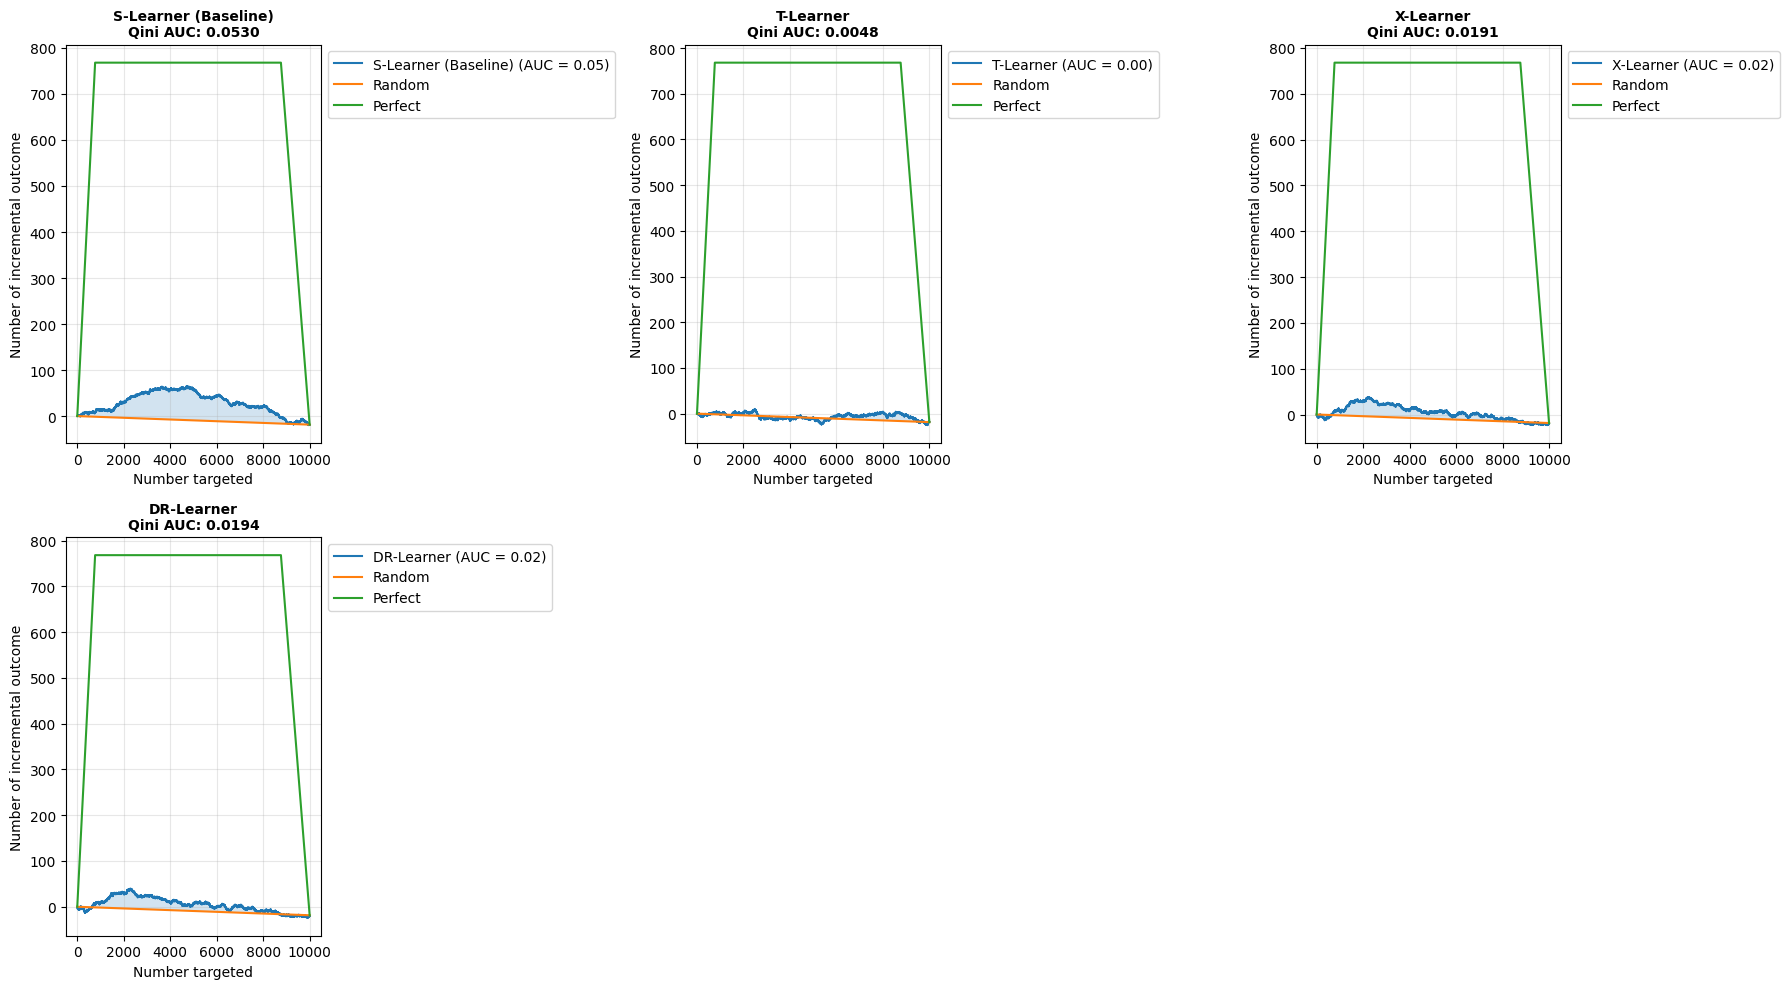

✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_20251114T205812Z.png


In [84]:
## Visualize All Meta-Learners (Qini Curves)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models_viz = [
    ("S-Learner (Baseline)", uplift_test_enet, test_qini_enet),
    ("T-Learner", uplift_test_tlearner, test_qini_tlearner),
    ("X-Learner", uplift_test_xlearner, test_qini_xlearner),
    ("DR-Learner", uplift_test_dr, test_qini_dr),
]

if has_causal_forest and uplift_test_causal is not None:
    models_viz.append(("Causal Forest", uplift_test_causal, test_qini_causal))

for idx, (name, uplift, qini) in enumerate(models_viz):
    if idx < len(axes):
        plot_qini_curve(
            y_test, uplift, treatment_test, perfect=True, name=name, ax=axes[idx]
        )
        axes[idx].set_title(
            f"{name}\nQini AUC: {qini:.4f}", fontweight="bold", fontsize=10
        )
        axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_qini_comparison_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_{timestamp}.png"
)

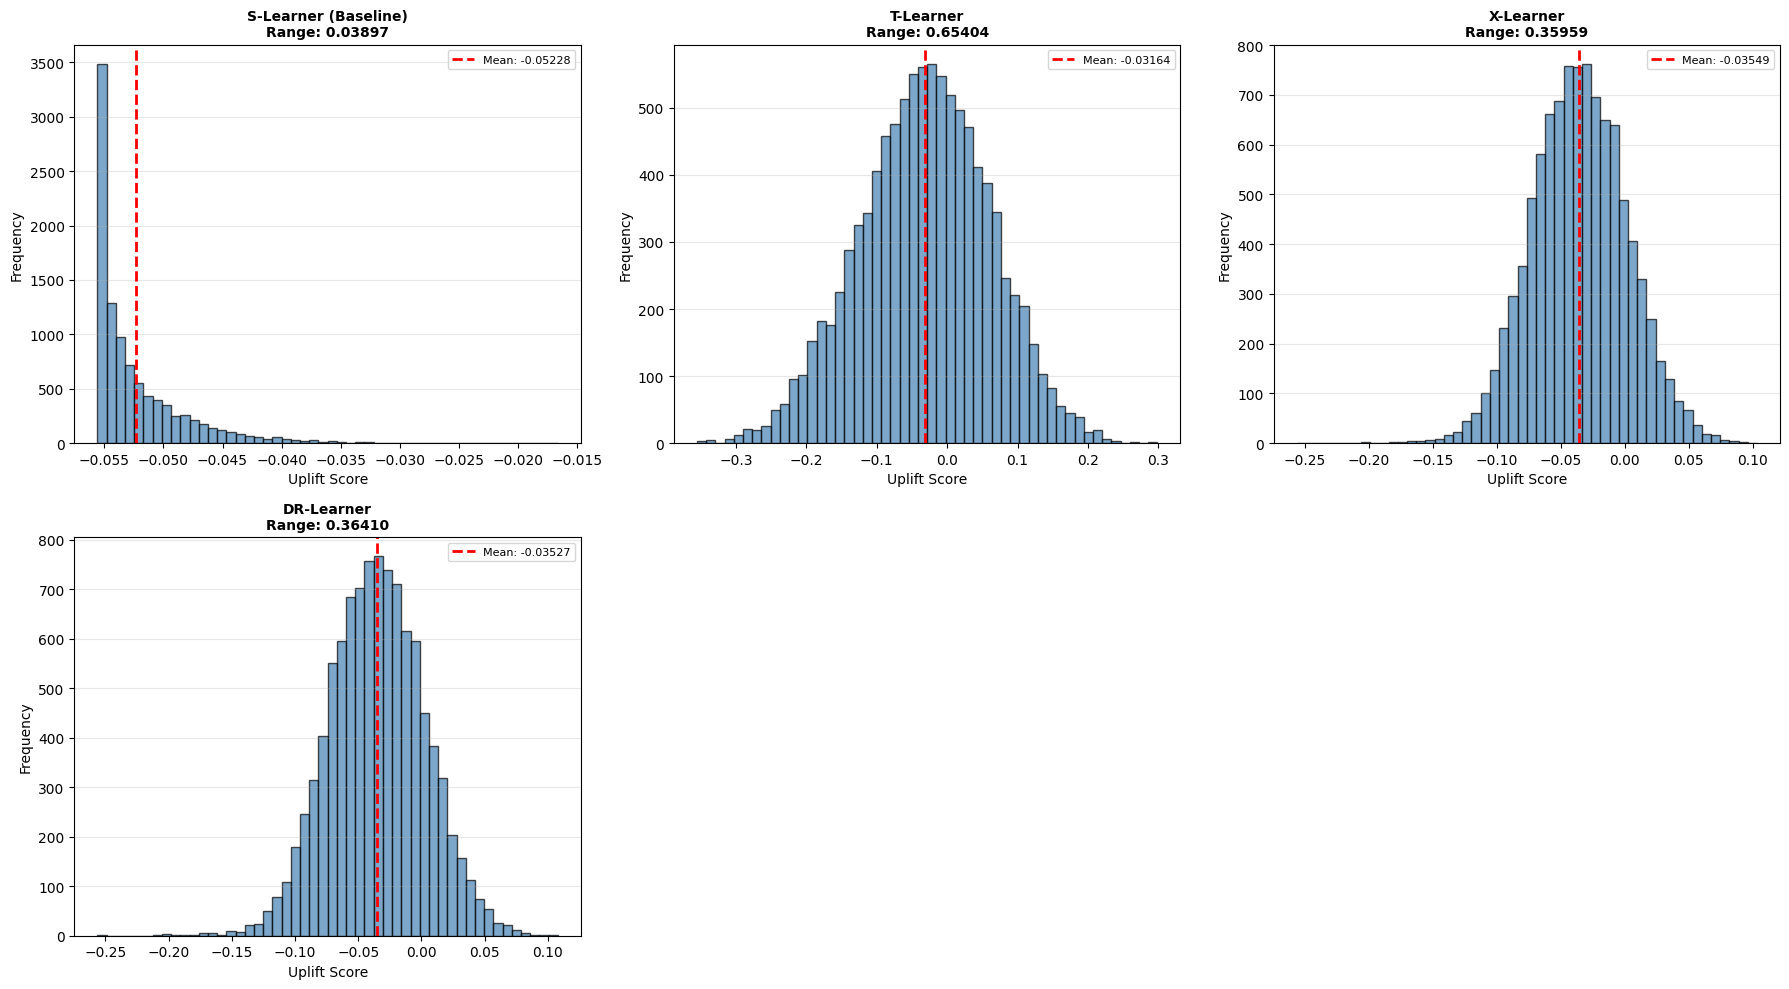

✅ Distribution comparison saved to: outputs/meta_learner_distributions_20251114T205812Z.png


In [85]:
## Uplift Distribution Comparison

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, uplift, _) in enumerate(models_viz):
    if idx < len(axes):
        axes[idx].hist(uplift, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
        axes[idx].axvline(
            uplift.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {uplift.mean():.5f}",
        )
        axes[idx].set_xlabel("Uplift Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(
            f"{name}\nRange: {uplift.max() - uplift.min():.5f}",
            fontweight="bold",
            fontsize=10,
        )
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3, axis="y")

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_distributions_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Distribution comparison saved to: outputs/meta_learner_distributions_{timestamp}.png"
)

In [86]:
## Select Best Model and Create Final Outreach List

# Get best model's uplift scores
best_model_name = results_meta.iloc[0]["Model"]

uplift_map_meta = {
    "S-Learner (Elastic Net - Baseline)": uplift_test_enet,
    "T-Learner (Ridge Regression)": uplift_test_tlearner,
    "X-Learner (Ridge + Propensity)": uplift_test_xlearner,
    "DR-Learner (Doubly Robust)": uplift_test_dr,
}

if has_causal_forest and uplift_test_causal is not None:
    uplift_map_meta["Causal Random Forest"] = uplift_test_causal

best_uplift_scores = uplift_map_meta[best_model_name]

# Create outreach list
test_raw = pd.read_csv(
    repo_root / "data" / "test" / "test_churn_labels_with_all_feats.csv"
)
member_ids_test = test_raw["member_id"].values

outreach_meta = pd.DataFrame(
    {
        "member_id": member_ids_test,
        "uplift_score": best_uplift_scores,
        "expected_churn_reduction": -best_uplift_scores,  # Flip sign for positive = good
    }
)

# Rank by most negative (best)
outreach_meta = outreach_meta.sort_values("uplift_score", ascending=True)
outreach_meta["rank"] = range(1, len(outreach_meta) + 1)
outreach_meta["percentile"] = 100 * outreach_meta["rank"] / len(outreach_meta)

# Optimal size (top 20%)
optimal_n_meta = int(len(outreach_meta) * 0.20)
outreach_final_meta = outreach_meta.head(optimal_n_meta)

print("\n" + "=" * 80)
print(f"FINAL OUTREACH LIST - BEST META-LEARNER: {best_model_name}")
print("=" * 80)
print(f"\nTop 20 members:")
print(outreach_final_meta.head(20).to_string(index=False))

# Save
outreach_meta_path = repo_root / "outputs" / f"outreach_meta_learner_{timestamp}.csv"
outreach_final_meta.to_csv(outreach_meta_path, index=False)

print(f"\n✅ Meta-learner outreach list saved to: {outreach_meta_path}")
print(f"   Total members: {len(outreach_final_meta)}")
print(
    f"   Mean expected churn reduction: {outreach_final_meta['expected_churn_reduction'].mean():.5f}"
)
print("=" * 80)


FINAL OUTREACH LIST - BEST META-LEARNER: S-Learner (Elastic Net - Baseline)

Top 20 members:
 member_id  uplift_score  expected_churn_reduction  rank  percentile
      4363     -0.055585                  0.055585     1        0.01
      6336     -0.055585                  0.055585     2        0.02
       909     -0.055585                  0.055585     3        0.03
      8948     -0.055585                  0.055585     4        0.04
      3166     -0.055585                  0.055585     5        0.05
      7729     -0.055585                  0.055585     6        0.06
      4654     -0.055585                  0.055585     7        0.07
      7179     -0.055585                  0.055585     8        0.08
      9278     -0.055585                  0.055585     9        0.09
      9337     -0.055585                  0.055585    10        0.10
      9103     -0.055585                  0.055585    11        0.11
      9255     -0.055585                  0.055585    12        0.12
      429